In [1]:
%%time
# Data Wranglers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Order 66
%config Completer.use_jedi = False
# Convinience
from glob import glob
from warnings import filterwarnings
from tqdm.notebook import tqdm
filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Wall time: 3.56 s


# Helper Functions

In [2]:
def get_housing_data(*, verbose: bool=True) -> "sample, test, train":
    """
    Reads original CSV files from Directory structure.
    """
    path = r"..\Data\*"
    file_path = [ _ for _ in glob(path) ]
    return [ pd.read_csv(_, verbose=verbose) for _ in file_path ]

def cat_analysis(var_name_1: str, var_name_2: str="SalePrice",* , Violin: bool=False)->None:
    var1, var2 = train.loc[:,var_name_1].astype("category"), train.loc[:,var_name_2]
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
    sns.countplot(y=var1, ax=ax1)
    if Violin:
        sns.violinplot(y=var1, x=var2, ax=ax2)
    else:
        sns.boxplot(y=var1, x=var2, ax=ax2)
    ax1.grid(True); ax2.grid(True)
    ax1.set_title("Count Plot"); ax2.set_title("Box Plot")
    plt.show()

def nan_count(var_name: str)->None:
    nan_counts = train.loc[:, var_name].isna().sum()
    print("{}: Number of NaN values = {:,}".format(var_name, nan_counts))
    
from scipy.stats import skew, kurtosis

def mean_reduction(var_name_1:str, var_name_2:str="SalePrice")->pd.DataFrame:
    tabel    = train.loc[:, [var_name_1, var_name_2]]
    tabel_gb = tabel.groupby(var_name_1)[var_name_2].agg([np.mean, np.std, skew, kurtosis])
    cat_mean, cat_std   = tabel_gb.loc[:, "mean"].mean(), tabel_gb.loc[:, "std"].mean()
    full_mean, full_std = tabel.loc[:, var_name_2].mean(), tabel.loc[:, var_name_2].std()
    print("------MEAN-------")
    print("Total Mean     = {:0.4f}".format(full_mean))
    print("Categ Mean     = {:0.4f}".format(cat_mean))
    print("Mean Reduction = {:0.4f} %".format((1-(cat_mean / full_mean)) * 100))
    print("------STD--------")
    print("Total Mean     = {:0.4f}".format(full_std))
    print("Categ Mean     = {:0.4f}".format(cat_std))
    print("Mean Reduction = {:0.4f} %".format((1-(cat_std / full_std)) * 100))
    return tabel_gb

from scipy.stats import probplot
def num_analysis(*var_names:str)-> None:
    if len(var_names) == 1:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
        sns.histplot(x=train.loc[:, var_names[0]], ax=ax1,kde=True)
        probplot(x=train.loc[:, var_names[0]], plot=ax2, rvalue=True)
        ax1.set_title("HistoGram")
        ax1.grid(True); ax2.grid(True)
        plt.show()
    elif len(var_names) == 2:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
        sns.histplot(x=train.loc[:, var_names[0]], ax=ax1,kde=True)
        sns.regplot(x=train.loc[:,var_names[0]],y=train.loc[:,var_names[1]],ax=ax2)
        ax1.set_title("HistoGram: {}".format(var_names[0]))
        ax2.set_title("Scatter Plot")
        ax1.grid(True); ax2.grid(True)
        plt.show()

from scipy.stats import chi2_contingency
def chi_test(var_name_1:str, var_name_2:str)->pd.DataFrame:
    Cross_Tab = pd.crosstab(train.loc[:,var_name_1], train.loc[:,var_name_2])
    chi_sq, p_val, *_ = chi2_contingency(Cross_Tab)
    print("Chi Sq. Value   = {}".format(chi_sq))
    print("P Vlaue of Hypo = {}".format(p_val))
    return Cross_Tab

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
def tree_fit(var_name:str, *, criterion:str='mse', LOG:bool=False, PLOT:bool=False, PRINT:bool=False):
    dt = DecisionTreeRegressor(criterion=criterion)
    X  = train.loc[:, var_name].values.reshape(-1, 1)
    if LOG:
        y = train.loc[:, "log_SalePrice"].values
    else:
        y = train.loc[:, "SalePrice"].values
    dt.fit(X, y)
    if PLOT:
        fig, ax = plt.subplots(1,1, figsize=(18,12))
        plot_tree(dt, ax=ax, filled=True, fontsize=10)
    if PRINT:
        print("Depth  = {}".format(dt.get_depth()))
        print("Leaves = {}".format(dt.get_n_leaves()))
    y_pred = dt.predict(X)
    return mean_squared_error(y, y_pred)

from sklearn.linear_model import LinearRegression
def line_fit(var_name:str, *, LOG:bool=True):
    lr = LinearRegression(normalize=True)
    X  = train.loc[:, var_name].values.reshape(-1, 1)
    if LOG:
        y = train.loc[:, "log_SalePrice"].values
    else:
        y = train.loc[:, "SalePrice"].values
    lr.fit(X, y)
    y_pred = lr.predict(X)
    return mean_squared_error(y, y_pred)

# Data Preview

In [3]:
sample_sub, test, train = get_housing_data()

Tokenization took: 1.03 ms
Type conversion took: 0.00 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 15.74 ms
Type conversion took: 14.69 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 12.25 ms
Type conversion took: 18.31 ms
Parser memory cleanup took: 0.00 ms


In [4]:
train

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
1455         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1456         Lvl    AllPub    Inside       Gtl       NWAmes       Norm   
1457         Lvl    AllPub    Inside       Gtl      Crawfor       Norm   
1458         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1459         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
2          Norm     1Fam     2Story            7            5       2001   
3          Norm     1Fam     2Story            7            5       1915   
4          Norm     1Fam     2Story            8            5       2000   
...         ...      ...        ...          ...          ...        ...   
1455       Norm     1Fam     2Story            6            5       1999   
1456       Norm     1Fam     1Story            6            6       1978   
1457       Norm     1Fam     2Story            7            9       1941   
1458       Norm     1Fam     1Story            5            6       1950   
1459       Norm     1Fam     1Story            5            6       1965   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd       None   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
1455          2000     Gable  CompShg     VinylSd     VinylSd       None   
1456          1988     Gable  CompShg     Plywood     Plywood      Stone   
1457          2006     Gable  CompShg     CemntBd     CmentBd       None   
1458          1996       Hip  CompShg     MetalSd     MetalSd       None   
1459          1965     Gable  CompShg     HdBoard     HdBoard       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0          196.0        Gd        TA      PConc       Gd       TA   
1            0.0        TA        TA     CBlock       Gd       TA   
2          162.0        Gd        TA      PConc       Gd       TA   
3            0.0        TA        TA     BrkTil       TA       Gd   

In [5]:
train.select_dtypes("object")

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0          RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1          RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   
2          RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
3          RL   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl   
4          RL   Pave   NaN      IR1         Lvl    AllPub       FR2       Gtl   
...       ...    ...   ...      ...         ...       ...       ...       ...   
1455       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1456       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1457       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1458       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1459       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   

     Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle  \
0         CollgCr       Norm       Norm     1Fam     2Story     Gable   
1         Veenker      Feedr       Norm     1Fam     1Story     Gable   
2         CollgCr       Norm       Norm     1Fam     2Story     Gable   
3         Crawfor       Norm       Norm     1Fam     2Story     Gable   
4         NoRidge       Norm       Norm     1Fam     2Story     Gable   
...           ...        ...        ...      ...        ...       ...   
1455      Gilbert       Norm       Norm     1Fam     2Story     Gable   
1456       NWAmes       Norm       Norm     1Fam     1Story     Gable   
1457      Crawfor       Norm       Norm     1Fam     2Story     Gable   
1458        NAmes       Norm       Norm     1Fam     1Story       Hip   
1459      Edwards       Norm       Norm     1Fam     1Story     Gable   

     RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond  \
0     CompShg     VinylSd     VinylSd    BrkFace        Gd        TA   
1     CompShg     MetalSd     MetalSd       None        TA        TA   
2     CompShg     VinylSd     VinylSd    BrkFace        Gd        TA   
3     CompShg     Wd Sdng     Wd Shng       None        TA        TA   
4     CompShg     VinylSd     VinylSd    BrkFace        Gd        TA   
...       ...         ...         ...        ...       ...       ...   
1455  CompShg     VinylSd     VinylSd       None        TA        TA   
1456  CompShg     Plywood     Plywood      Stone        TA        TA   
1457  CompShg     CemntBd     CmentBd       None        Ex        Gd   
1458  CompShg     MetalSd     MetalSd       None        TA        TA   
1459  CompShg     HdBoard     HdBoard       None        Gd        TA   

     Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  \
0         PConc       Gd       TA           No          GLQ          Unf   
1        CBlock       Gd       TA           Gd          ALQ          Unf   
2         PConc       Gd       TA           Mn          GLQ          Unf   
3        BrkTil       TA       Gd           No          ALQ          Unf   
4         PConc       Gd       TA           Av          GLQ          Unf   
...         ...      ...      ...          ...          ...          ...   
1455      PConc       Gd       TA           No          Unf          Unf   
1456     CBlock       Gd       TA           No          ALQ          Rec   
1457      Stone       TA       Gd           No          GLQ          Unf   
1458     CBlock       TA       TA           Mn          GLQ          Rec   
1459     CBlock       TA       TA           No          BLQ          LwQ   

     Heating HeatingQC CentralAir Electrical KitchenQual Functional  \
0       GasA        Ex          Y      SBrkr          Gd        Typ   
1       GasA        Ex          Y      SBrkr          TA        Typ   
2       GasA        Ex          Y      SBrkr          Gd        Typ   
3       GasA        Gd          Y      SBrkr          Gd        Typ   
4       GasA        Ex

# Missing Values

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# nan_data
train.isna().sum().loc[ train.isna().sum() > 0 ]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

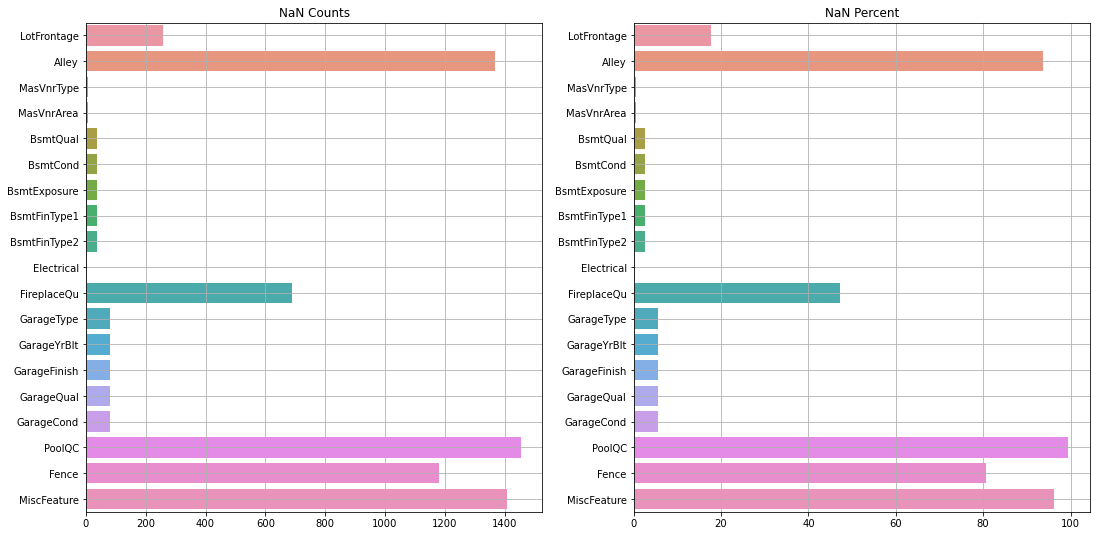

Wall time: 1.96 s


In [8]:
%%time
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,9))
sns.barplot(x=train.isna().sum().loc[ train.isna().sum() > 0 ], y=train.isna().sum().loc[ train.isna().sum() > 0 ].index,ax=ax1)
sns.barplot(x=train.isna().sum().loc[ train.isna().sum()>0 ]*100/train.shape[0], y=train.isna().sum().loc[ train.isna().sum()>0 ].index,ax=ax2)
ax1.grid(True); ax2.grid(True)
ax1.set_title("NaN Counts"); ax2.set_title("NaN Percent") 
plt.show()

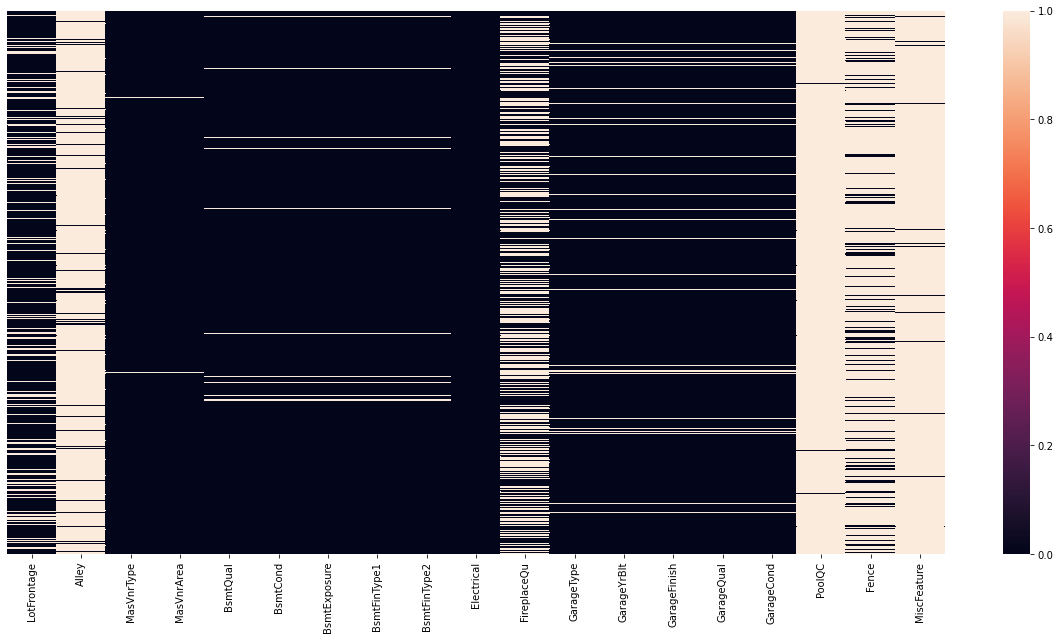

Wall time: 1.06 s


In [9]:
%%time
fig, ax = plt.subplots(1,1, figsize=(21,10))
sns.heatmap(train.isna().loc[ :, train.isna().sum() > 0 ], yticklabels=False, ax=ax)
plt.show()

# Target Veraible : SalePrice

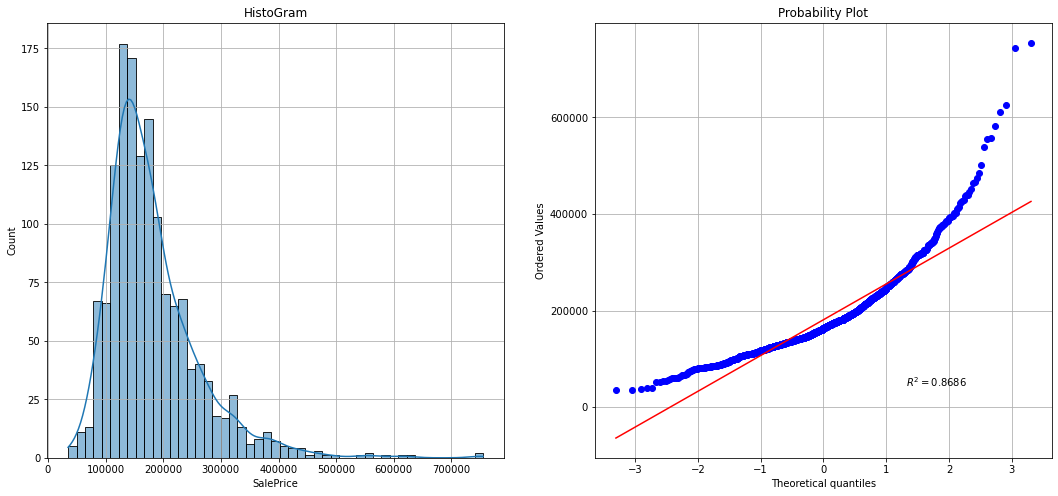

In [10]:
num_analysis("SalePrice")

In [11]:
train["log_SalePrice"] = np.log(train["SalePrice"])

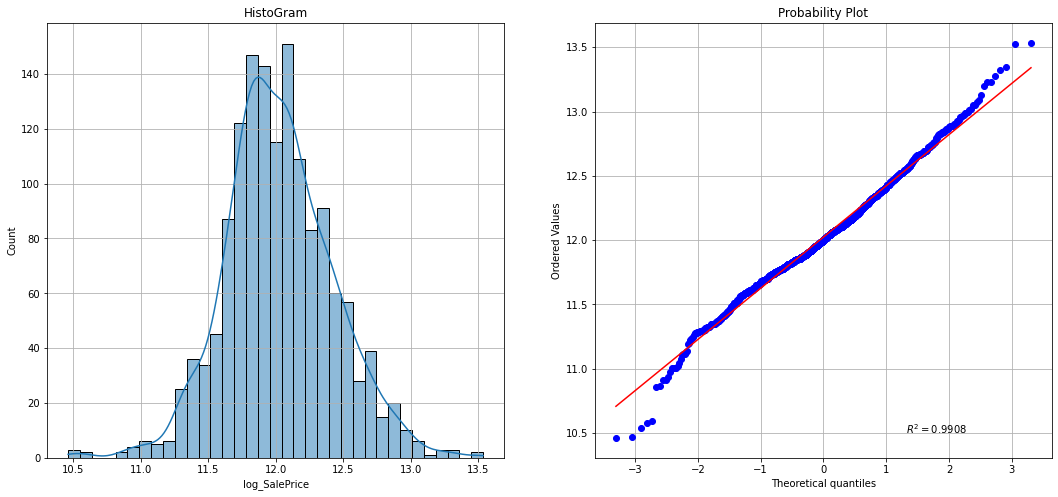

In [12]:
num_analysis("log_SalePrice")

# Engineered Variables

## Area Variables

### Total_SF : Total Floor Area

In [13]:
[ _ for _ in train.columns if ("SF" in _ or "Area" in _ )]

['LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'PoolArea']

In [14]:
(train.GrLivArea - train.loc[:, "1stFlrSF"] - train.loc[:, "2ndFlrSF"]).describe()

count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
dtype: float64

In [15]:
(train.GrLivArea - train.loc[:, "1stFlrSF"] - train.loc[:, "2ndFlrSF"]).loc[(train.GrLivArea - train.loc[:, "1stFlrSF"] - train.loc[:, "2ndFlrSF"])!=0]

51      360
88      513
125     234
170     528
185     572
187     144
197     392
198     371
263     390
267     420
406     473
589     156
635     515
729     360
829      80
831      80
868      53
873     232
883     481
945     120
1009    514
1031    397
1173    479
1349    205
1364     80
1440    384
dtype: int64

In [16]:
# print([_ for _ in train.columns if "SF" in _ and _ is not "Total_SF" ])

SF_List = ['TotalBsmtSF','GrLivArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','GarageArea']


In [17]:
(train.LowQualFinSF - (train.GrLivArea - train.loc[:, "1stFlrSF"] - train.loc[:, "2ndFlrSF"])).describe()

count    1460.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

In [18]:
train["Total_SF"] = train.loc[:, SF_List].sum(axis=1)

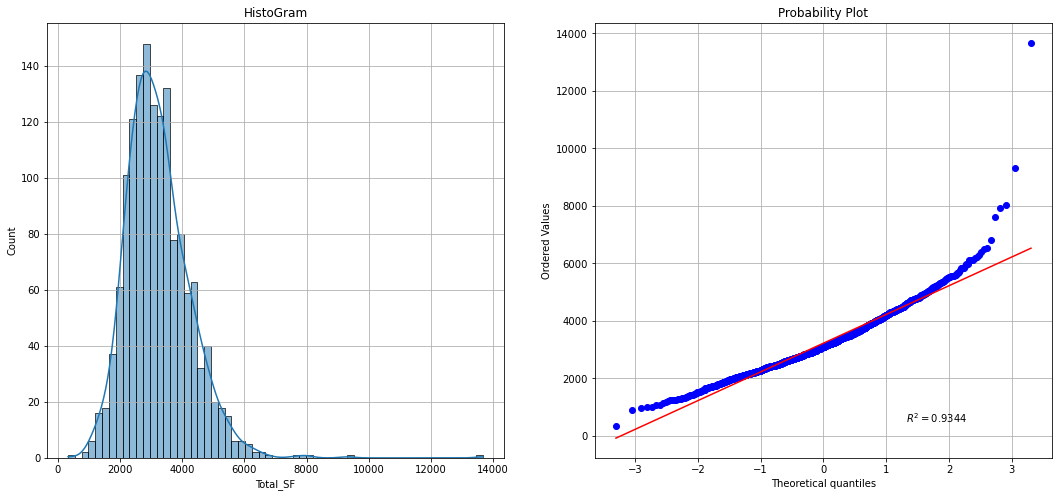

In [19]:
num_analysis("Total_SF")

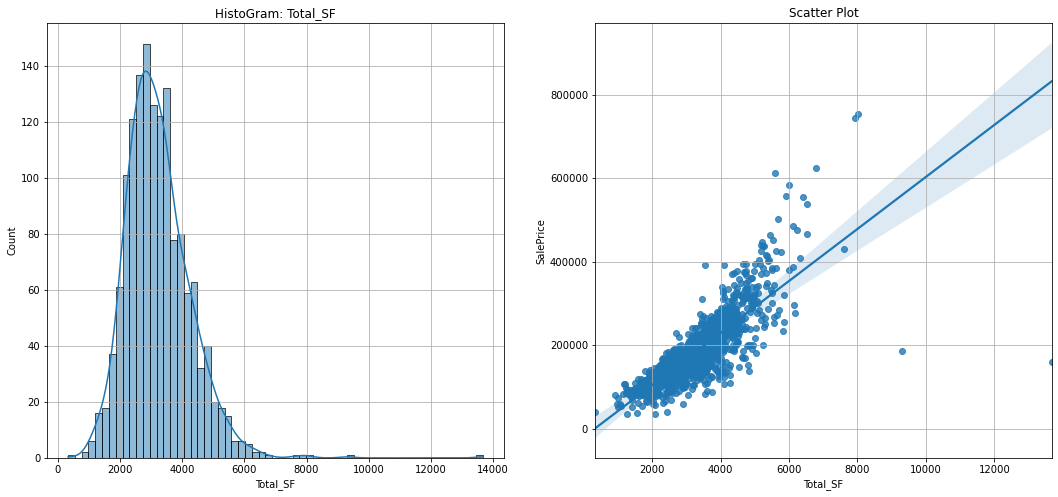

In [20]:
num_analysis("Total_SF", "SalePrice")

In [21]:
from scipy.stats import pearsonr

pearsonr(train.SalePrice, train.Total_SF)

(0.8100877726165194, 0.0)

In [22]:
train.loc[:, SF_List].corr() * 100

TotalBsmtSF   GrLivArea  WoodDeckSF  OpenPorchSF  \
TotalBsmtSF     100.000000   45.486820   23.201861    24.726375   
GrLivArea        45.486820  100.000000   24.743282    33.022396   
WoodDeckSF       23.201861   24.743282  100.000000     5.866061   
OpenPorchSF      24.726375   33.022396    5.866061   100.000000   
EnclosedPorch    -9.547774    0.911321  -12.598889    -9.307932   
3SsnPorch         3.738373    2.064319   -3.277063    -0.584250   
ScreenPorch       8.448899   10.151040   -7.418135     7.430394   
GarageArea       48.666546   46.899748   22.466631    24.143467   

               EnclosedPorch   3SsnPorch  ScreenPorch  GarageArea  
TotalBsmtSF        -9.547774    3.738373     8.448899   48.666546  
GrLivArea           0.911321    2.064319    10.151040   46.899748  
WoodDeckSF        -12.598889   -3.277063    -7.418135   22.466631  
OpenPorchSF        -9.307932   -0.584250     7.430394   24.143467  
EnclosedPorch     100.000000   -3.730528    -8.286424  -12.177672  
3SsnPorch          -3.730528  100.000000    -3.143585    3.508670  
ScreenPorch        -8.286424   -3.143585   100.000000    5.141176  
GarageArea        -12.177672    3.508670     5.141176  100.000000

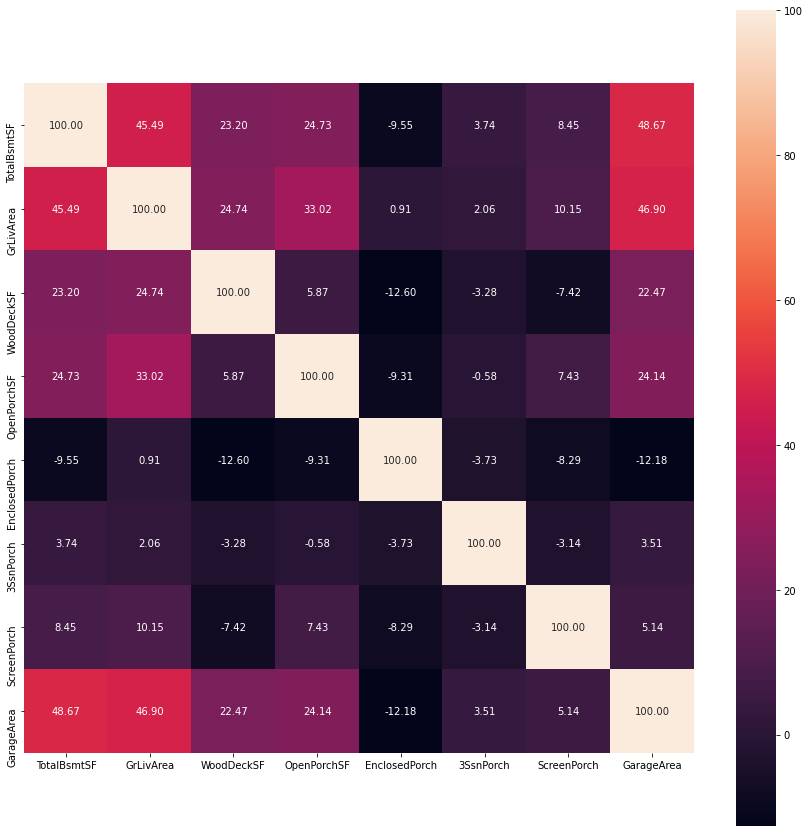

In [23]:
fig, ax = plt.subplots(1,1, figsize=(15, 15))
sns.heatmap(train.loc[:, SF_List].corr()*100, square=True, ax=ax, fmt="0.2f", annot=True)
plt.show()

In [24]:
train.loc[:, [_ for _ in train.columns if "SF" in _ ]].corr().loc[:, "Total_SF"].sort_values(ascending=False) * 100

Total_SF        100.000000
TotalBsmtSF      80.148655
1stFlrSF         78.269775
BsmtFinSF1       41.958503
OpenPorchSF      39.290031
WoodDeckSF       38.394627
BsmtUnfSF        34.424422
2ndFlrSF         33.423223
BsmtFinSF2        5.042387
LowQualFinSF      4.346126
Name: Total_SF, dtype: float64

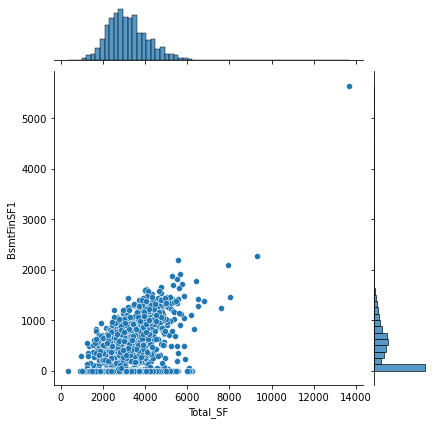

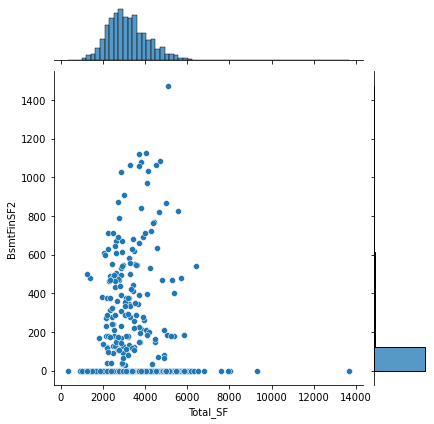

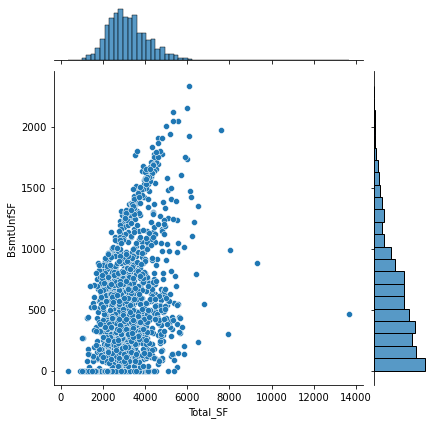

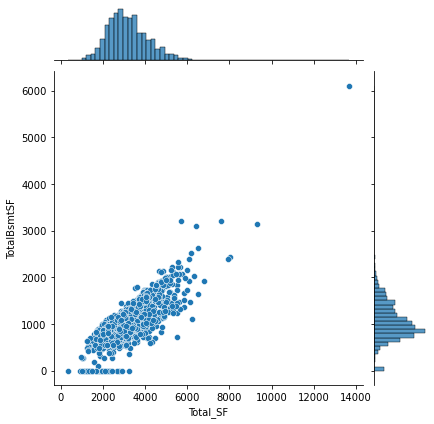

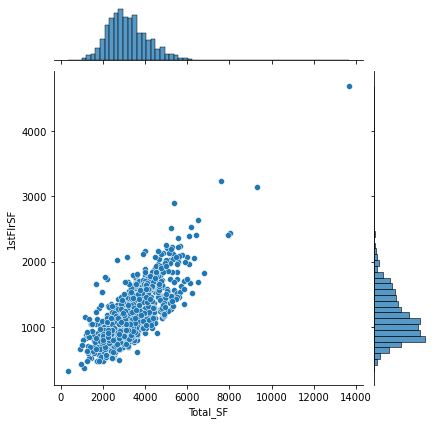

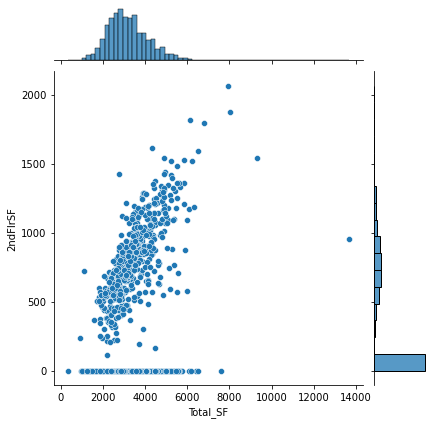

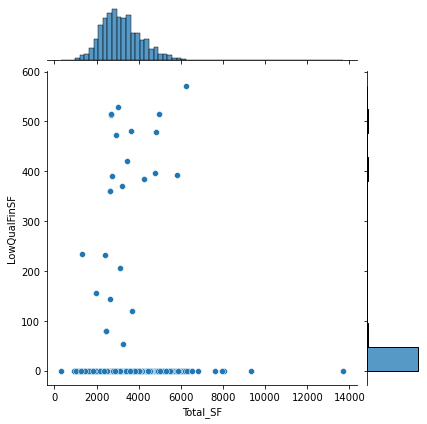

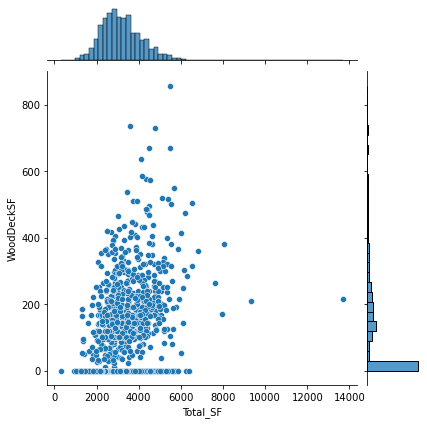

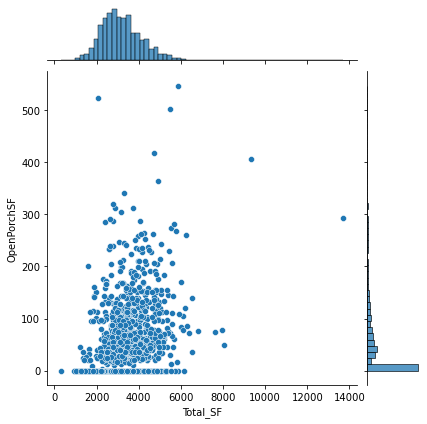

In [25]:
for _ in tqdm([_ for _ in train.columns if "SF" in _ and "Total_SF" not in _ ]):
    sns.jointplot(x=train.loc[:, "Total_SF"], y=train.loc[:, _]); plt.show()

## Age_At_Sale : Age of House On Sale Data

In [26]:
train["Age_At_Sale"] = train.loc[:, "YrSold"] - train.loc[:, "YearBuilt"]

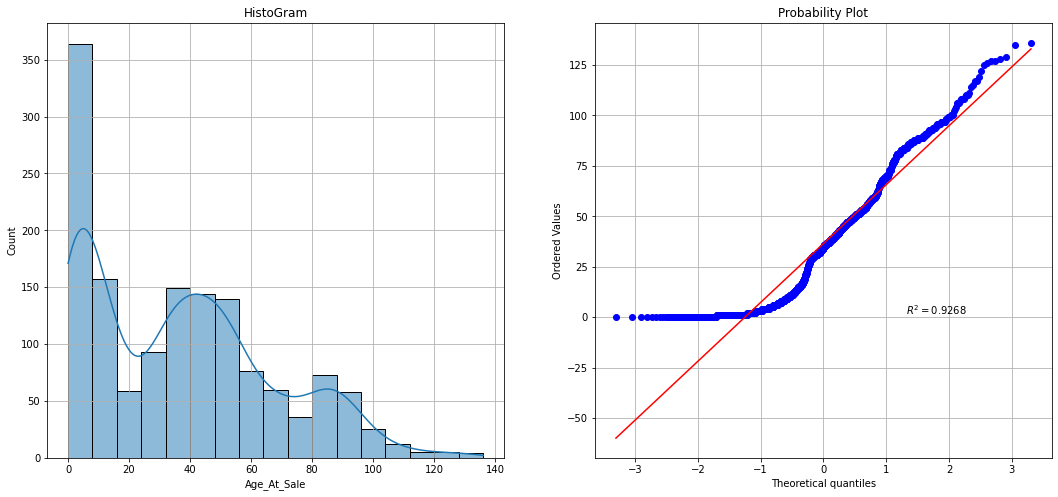

In [27]:
num_analysis("Age_At_Sale")

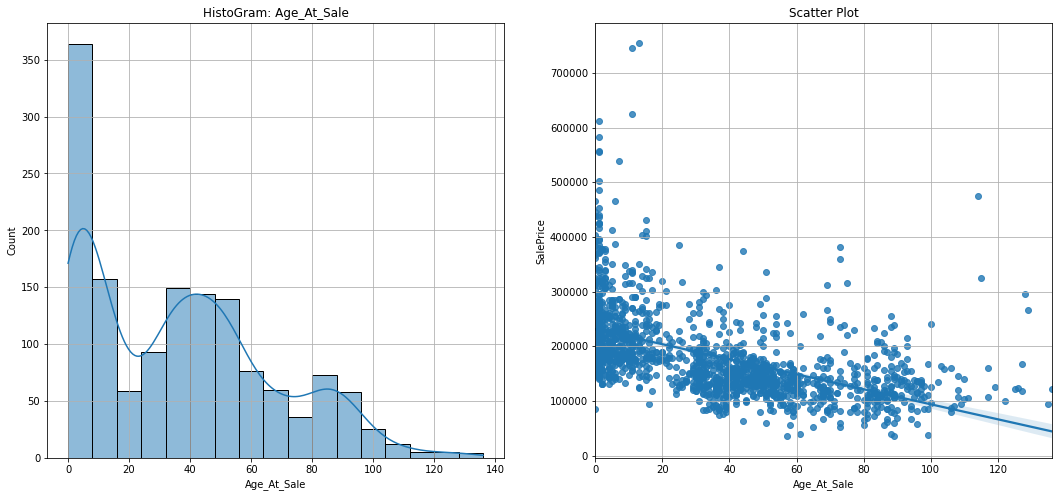

In [28]:
num_analysis("Age_At_Sale", "SalePrice")

In [29]:
[ _ for _ in train.columns if "Y" in _ or "Age" in _ ]

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'Age_At_Sale']

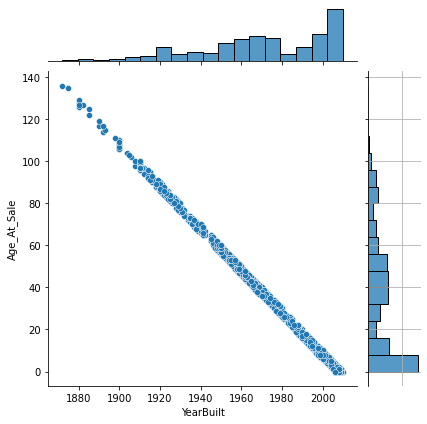

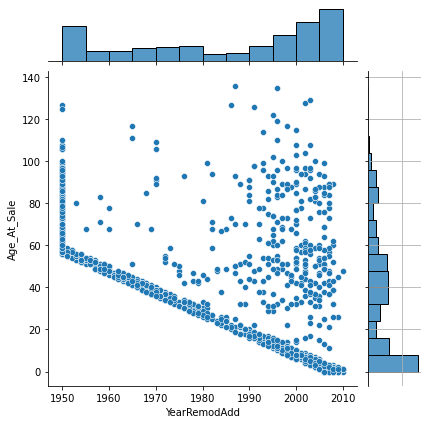

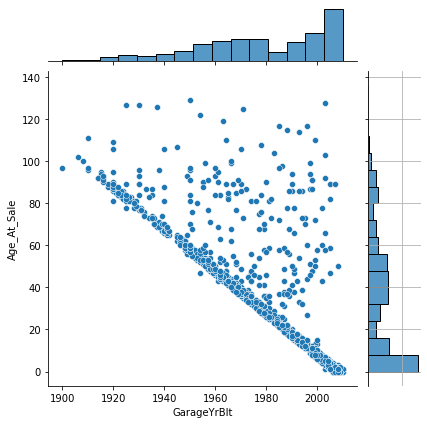

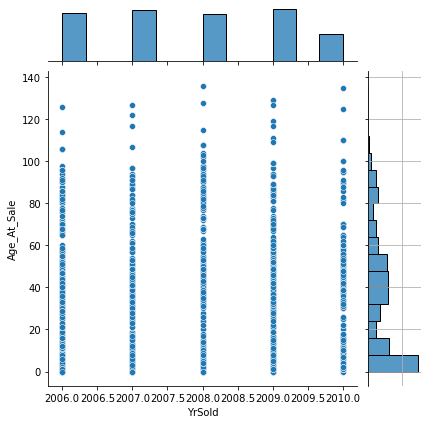

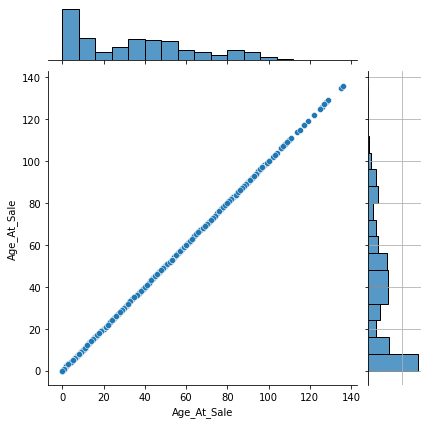

In [30]:
for _ in tqdm([ _ for _ in train.columns if "Y" in _ or "Age" in _ ]):
    sns.jointplot(x=train.loc[:, _], y=train.loc[:, "Age_At_Sale"])
    plt.grid(); plt.show()

## Remodel_Age / Remodel_done

In [31]:
train["Remodel_Age"] = train.YrSold - train.YearRemodAdd

In [32]:
train["Remodel_Done"] = (train.YearRemodAdd - train.YearBuilt).apply(lambda x: 1 if x>0 else 0)

## Bath_Rooms

In [33]:
train.loc[:, [ _ for _ in train.columns if "Bath" in _ ]]

BsmtFullBath  BsmtHalfBath  FullBath  HalfBath
0                1             0         2         1
1                0             1         2         0
2                1             0         2         1
3                1             0         1         0
4                1             0         2         1
...            ...           ...       ...       ...
1455             0             0         2         1
1456             1             0         2         0
1457             0             0         2         0
1458             1             0         1         0
1459             1             0         1         1

[1460 rows x 4 columns]

In [34]:
train["Half_bath"] = train.loc[:, [ _ for _ in train.columns if "Bath" in _ and "Half" in _ ]].sum(axis=1)
train["Full_bath"] = train.loc[:, [ _ for _ in train.columns if "Bath" in _ and "Half" not in _ ]].sum(axis=1)
train["All_bath"]  = train["Full_bath"] + train["Half_bath"]

In [35]:
train.loc[:,["Full_bath", "Half_bath"]].loc[train.loc[:, "Full_bath"] == 0]

Full_bath  Half_bath
597          0          4

# Fields

## MSSubClass

In [36]:
train.MSSubClass.value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

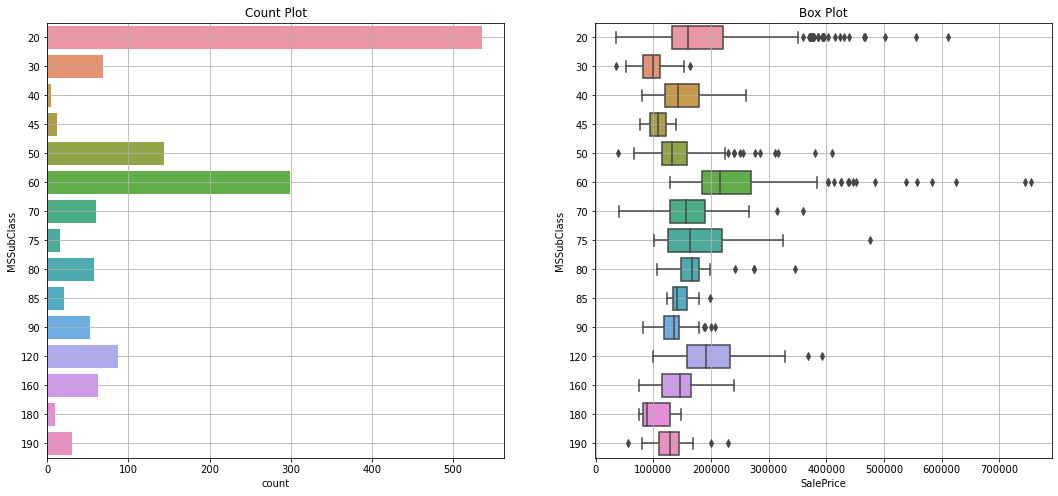

In [37]:
cat_analysis("MSSubClass")

In [38]:
_ = mean_reduction("MSSubClass")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 154044.0011
Mean Reduction = 14.8557 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 49546.4960
Mean Reduction = 37.6323 %


In [39]:
MSS_dict = {}
for obj, key in enumerate(list(_.sort_values(by="mean").index)):
    MSS_dict[key] = obj

In [40]:
train.MSSubClass = train.MSSubClass.map(MSS_dict)

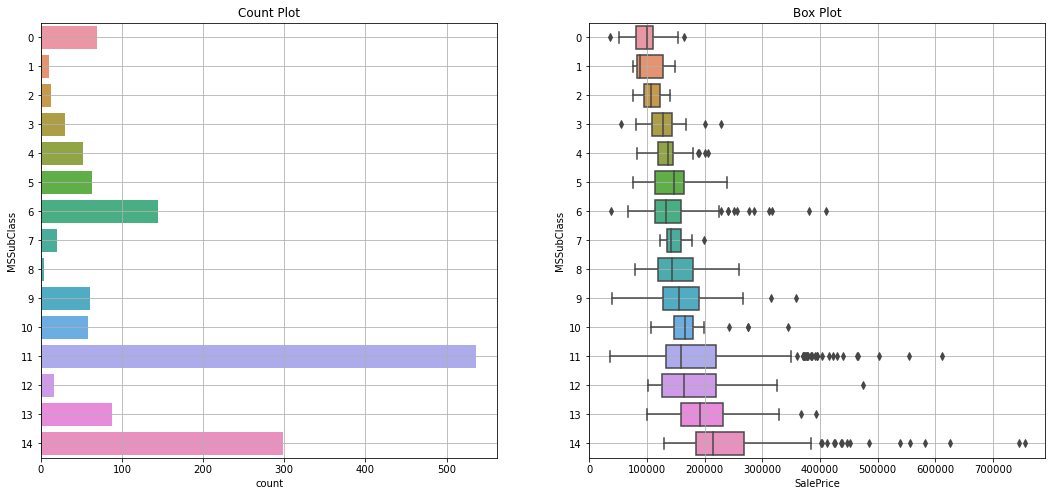

In [41]:
cat_analysis("MSSubClass")

## MSZoning

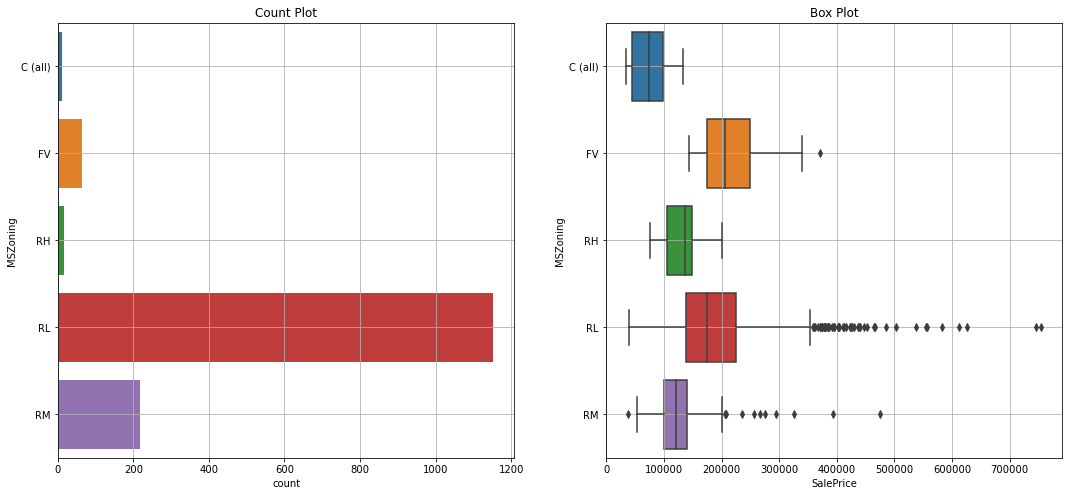

In [42]:
cat_analysis("MSZoning")

In [43]:
_ = mean_reduction("MSZoning")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 147484.4523
Mean Reduction = 18.4814 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 50232.5807
Mean Reduction = 36.7686 %


In [44]:
MSZoning_dict = {}
for obj, key in enumerate(list(_.sort_values("mean").index)):
    MSZoning_dict[key] = obj

In [45]:
train.MSZoning = train.MSZoning.map(MSZoning_dict)

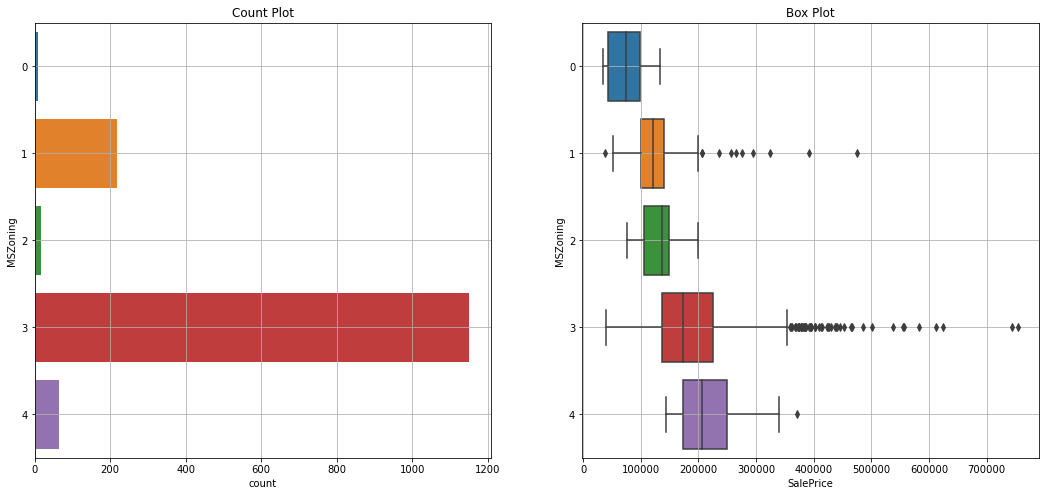

In [46]:
cat_analysis("MSZoning")

## LotFrontage: 

In [47]:
nan_count("LotFrontage")

LotFrontage: Number of NaN values = 259


In [48]:
train.corr().loc["LotFrontage"].sort_values(ascending=False) * 100

LotFrontage      100.000000
Total_SF          46.515483
1stFlrSF          45.718100
LotArea           42.609502
GrLivArea         40.279741
TotalBsmtSF       39.207458
log_SalePrice     35.587847
TotRmsAbvGrd      35.209595
SalePrice         35.179910
GarageArea        34.499672
MSSubClass        30.581128
GarageCars        28.569092
MSZoning          27.143053
Fireplaces        26.663948
BedroomAbvGr      26.316992
OverallQual       25.164578
BsmtFinSF1        23.363317
Full_bath         21.830142
PoolArea          20.616678
All_bath          20.180394
FullBath          19.876868
MasVnrArea        19.345806
OpenPorchSF       15.197223
BsmtUnfSF         13.264374
YearBuilt         12.334947
BsmtFullBath      10.094857
YearRemodAdd       8.886557
WoodDeckSF         8.852093
2ndFlrSF           8.017727
GarageYrBlt        7.024978
3SsnPorch          7.002923
HalfBath           5.353185
BsmtFinSF2         4.989968
Half_bath          4.543870
ScreenPorch        4.138279
LowQualFinSF       3

## LotArea

In [49]:
nan_count("LotArea")

LotArea: Number of NaN values = 0


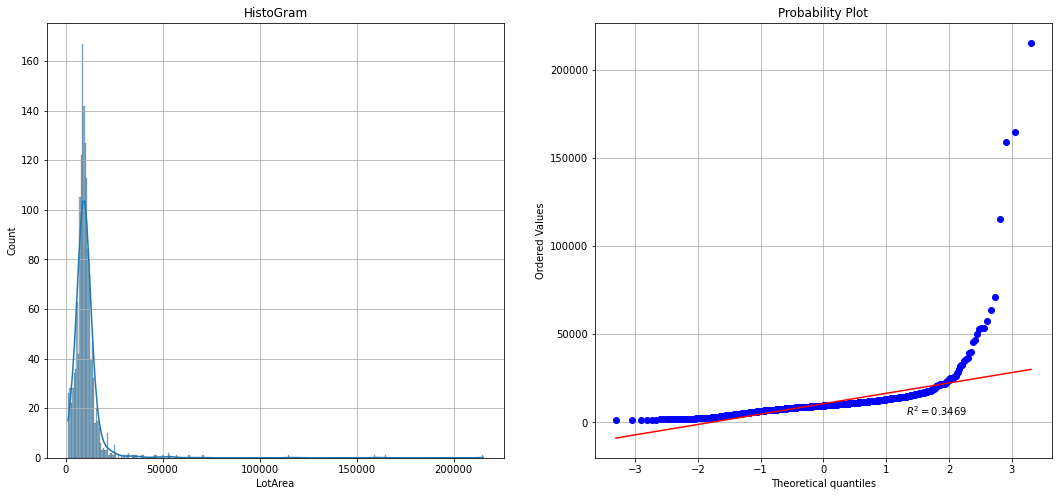

In [50]:
num_analysis("LotArea")

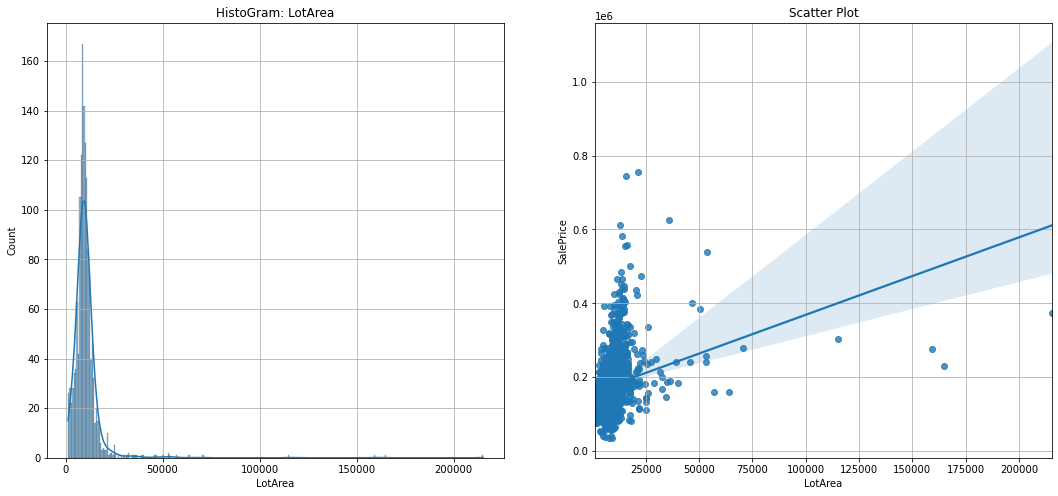

In [51]:
num_analysis("LotArea", "SalePrice")

## Road Study

In [52]:
train.Street.value_counts(dropna=False)

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [53]:
train.Alley.value_counts(dropna=False)

NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

In [54]:
(train.Street + train.Alley.fillna("")).value_counts()

Pave        1363
PaveGrvl      50
PavePave      41
Grvl           6
dtype: int64

In [55]:
train["Road"] = train.Street + train.Alley.fillna("")

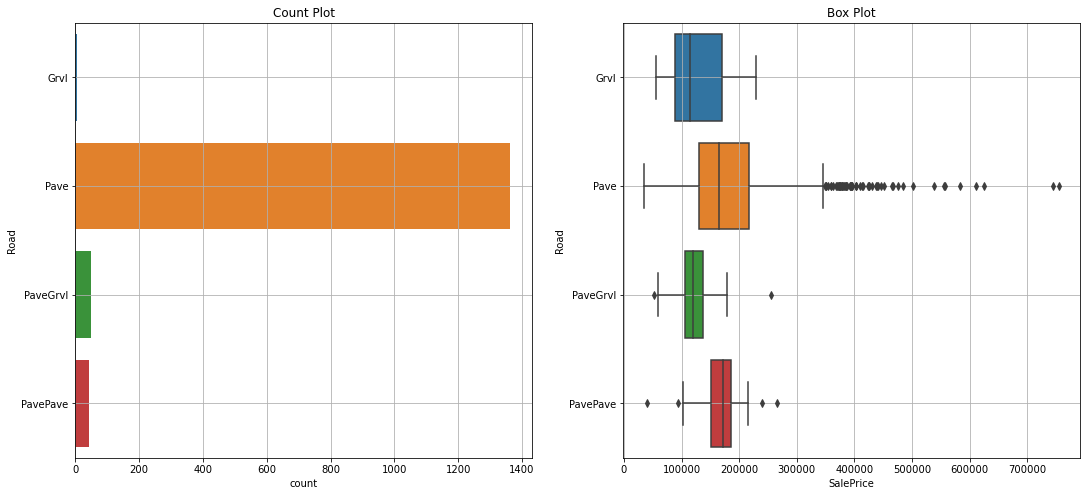

In [56]:
cat_analysis("Road")

In [57]:
road_dict = {}

for obj, key in enumerate(list(mean_reduction("Road").sort_values("mean").index)):
    road_dict[key] = obj

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 151024.1894
Mean Reduction = 16.5249 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 54816.7433
Mean Reduction = 30.9982 %


In [58]:
train.Road = train.Road.map(road_dict)

## LotShape : One Hot Encode

In [59]:
nan_count("LotShape")

LotShape: Number of NaN values = 0


In [60]:
train.LotShape.value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

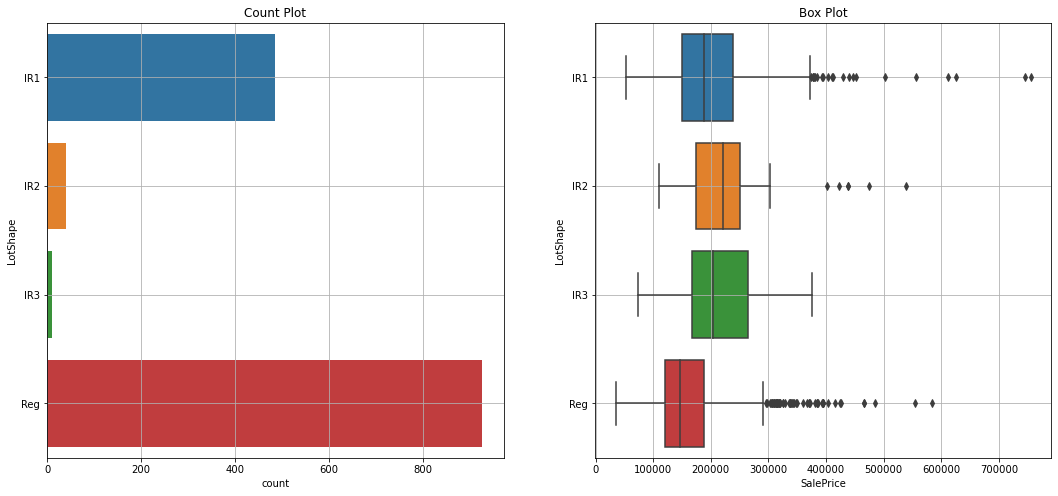

In [61]:
cat_analysis("LotShape")

In [62]:
LotShape_dict = {}

for obj, key in enumerate(mean_reduction("LotShape").sort_values("mean").index):
    LotShape_dict[key] = obj

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 206681.5874
Mean Reduction = -14.2385 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 84435.4197
Mean Reduction = -6.2849 %


In [63]:
train.LotShape = train.LotShape.map(LotShape_dict)

## LandContour : One Hot Encode

In [64]:
nan_count("LandContour")

LandContour: Number of NaN values = 0


In [65]:
train.LandContour.value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

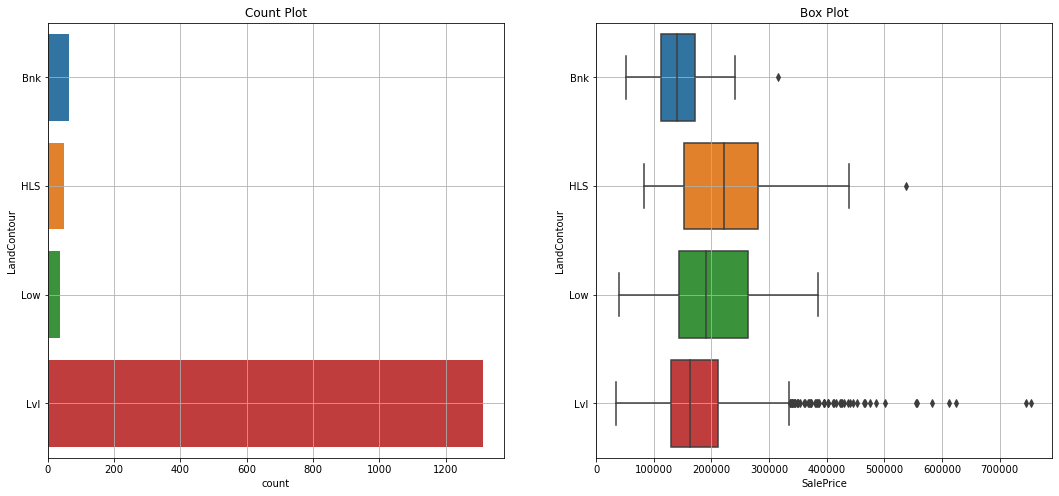

In [66]:
cat_analysis("LandContour")

In [67]:
LandContour_dict = {}

for obj, key in enumerate(mean_reduction("LandContour").sort_values("mean").index):
    LandContour_dict[key] = obj

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 189620.7193
Mean Reduction = -4.8085 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 78387.5763
Mean Reduction = 1.3279 %


In [68]:
train.LandContour = train.LandContour.map(LandContour_dict)

## Utilities (Drop Column No Data)

In [69]:
nan_count("Utilities")

Utilities: Number of NaN values = 0


In [70]:
train.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

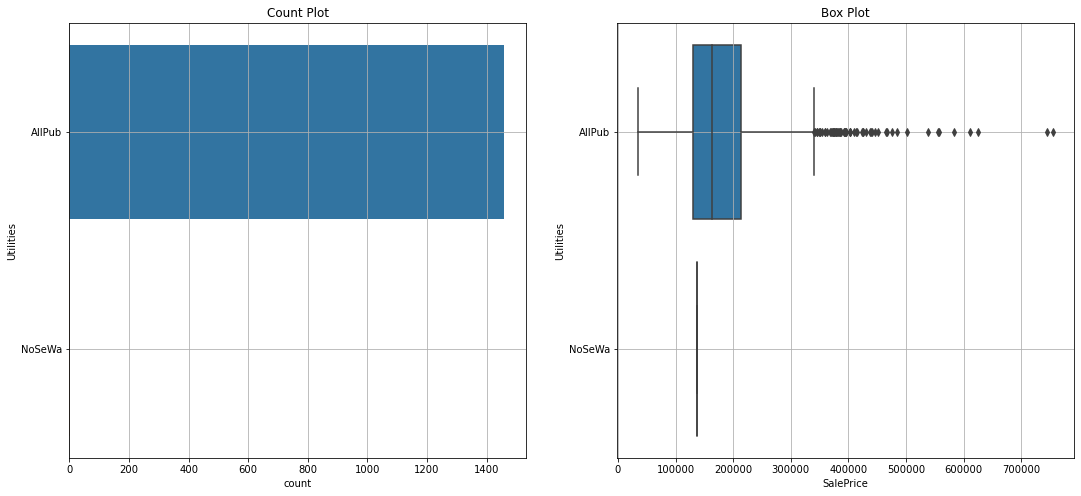

In [71]:
cat_analysis("Utilities")

In [72]:
mean_reduction("Utilities")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 159225.4784
Mean Reduction = 11.9918 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 79461.5998
Mean Reduction = -0.0240 %


mean           std      skew  kurtosis
Utilities                                                
AllPub     180950.95682  79461.599814  1.879863  6.504315
NoSeWa     137500.00000           NaN  0.000000 -3.000000

## LotConfig (One Hot Encode)

In [73]:
nan_count("LotConfig")

LotConfig: Number of NaN values = 0


In [74]:
train.LotConfig.value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

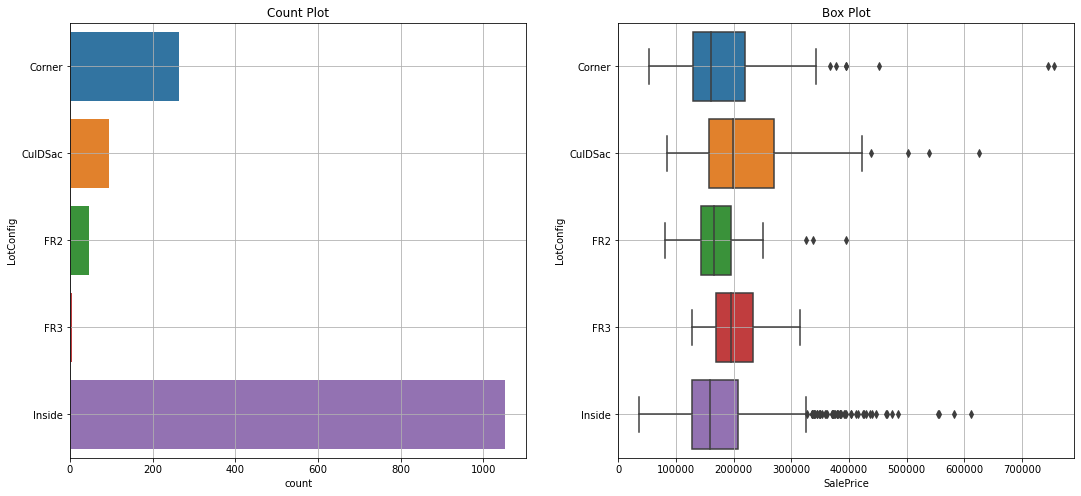

In [75]:
cat_analysis("LotConfig")

In [76]:
LotConfig_dict = {}

for obj, key in enumerate(mean_reduction("LotConfig").sort_values("mean").index):
    LotConfig_dict[key] = obj

train.LotConfig = train.LotConfig.map(LotConfig_dict)

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 193765.1330
Mean Reduction = -7.0992 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 79035.7086
Mean Reduction = 0.5121 %


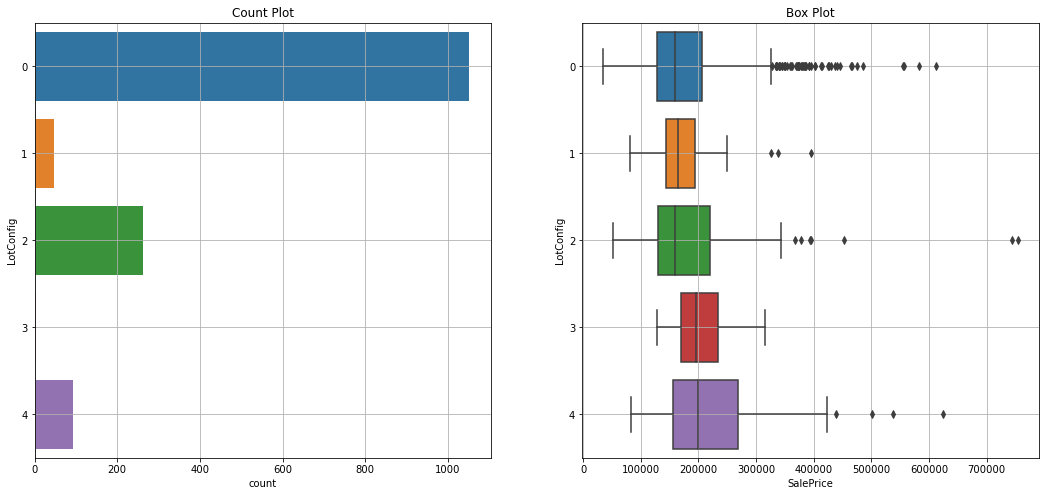

In [77]:
cat_analysis("LotConfig")

## LandSlope (One Hot Encode) (Drop!)

In [78]:
nan_count("LandSlope")

LandSlope: Number of NaN values = 0


In [79]:
train.LandSlope.value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [80]:
train.LandSlope.value_counts(normalize=True).round(4) * 100

Gtl    94.66
Mod     4.45
Sev     0.89
Name: LandSlope, dtype: float64

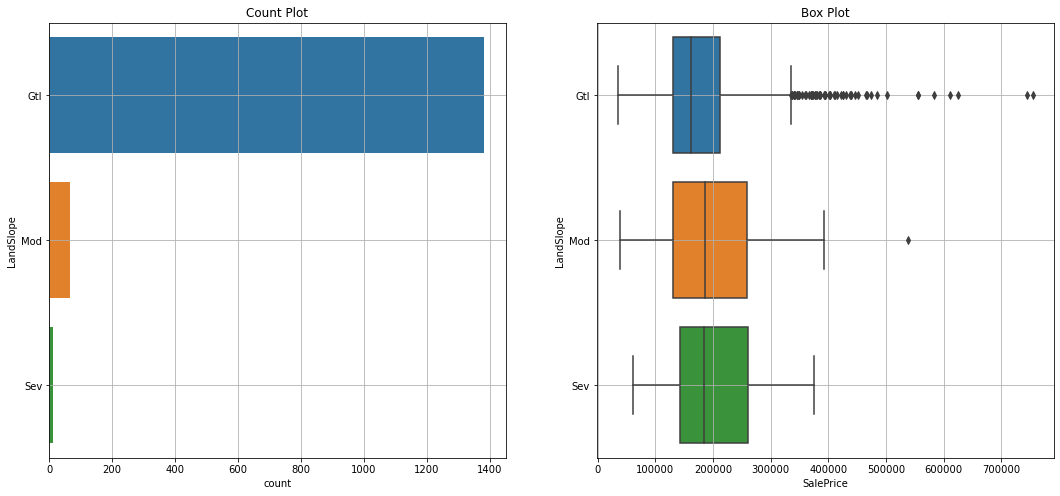

In [81]:
cat_analysis("LandSlope")

In [82]:
mean_reduction("LandSlope")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 193690.0563
Mean Reduction = -7.0577 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 85924.8832
Mean Reduction = -8.1598 %


mean           std      skew  kurtosis
LandSlope                                                 
Gtl        179956.799566  78669.369151  1.959097  7.038784
Mod        196734.138462  92375.358116  0.972794  1.521768
Sev        204379.230769  86729.922409  0.267832 -0.563832

## Neighborhood (One Hot / Ordinal Encode?)

In [83]:
nan_count("Neighborhood")

Neighborhood: Number of NaN values = 0


In [84]:
train.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [85]:
train.Neighborhood.value_counts(normalize=True).round(4) * 100

NAmes      15.41
CollgCr    10.27
OldTown     7.74
Edwards     6.85
Somerst     5.89
Gilbert     5.41
NridgHt     5.27
Sawyer      5.07
NWAmes      5.00
SawyerW     4.04
BrkSide     3.97
Crawfor     3.49
Mitchel     3.36
NoRidge     2.81
Timber      2.60
IDOTRR      2.53
ClearCr     1.92
SWISU       1.71
StoneBr     1.71
Blmngtn     1.16
MeadowV     1.16
BrDale      1.10
Veenker     0.75
NPkVill     0.62
Blueste     0.14
Name: Neighborhood, dtype: float64

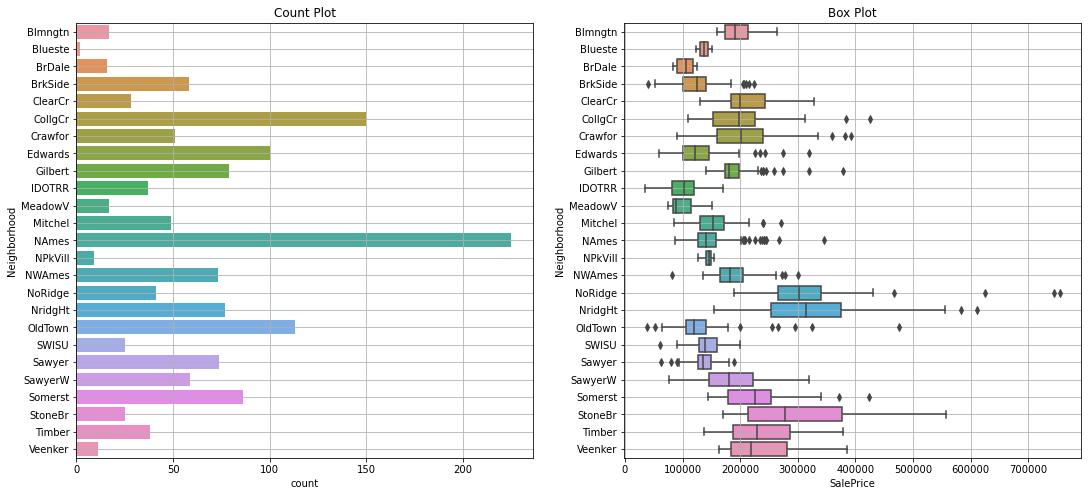

In [86]:
cat_analysis("Neighborhood")

In [87]:
neigh_dict = {}
for obj, key in enumerate(mean_reduction("Neighborhood").sort_values("mean").index):
    neigh_dict[key] = obj

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 183964.8533
Mean Reduction = -1.6823 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 48571.1308
Mean Reduction = 38.8600 %


In [88]:
train.Neighborhood = train.Neighborhood.map(neigh_dict)

## Condition1 (Drop ? One Hot? Ordinal?)

In [89]:
nan_count("Condition1")

Condition1: Number of NaN values = 0


In [90]:
train.Condition1.value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

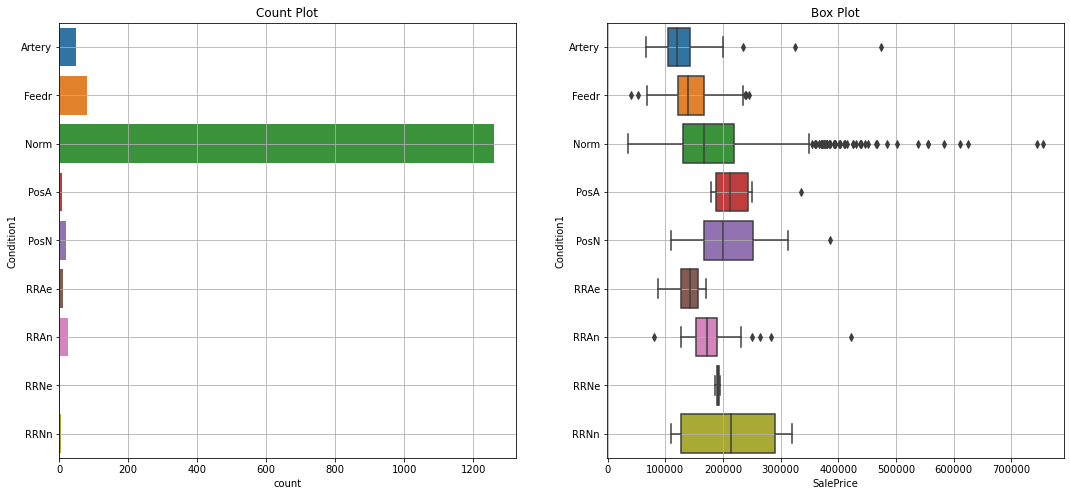

In [91]:
cat_analysis("Condition1")

In [92]:
cond1_dict = {}

for obj, key in enumerate(mean_reduction("Condition1").sort_values("mean").index):
    cond1_dict[key] = obj

train.Condition1 = train.Condition1.map(cond1_dict)

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 181007.6073
Mean Reduction = -0.0478 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 55175.7416
Mean Reduction = 30.5463 %


## Condition2 (Drop ? One Hot? Ordinal?) (DROP!!!)

In [93]:
nan_count("Condition2")

Condition2: Number of NaN values = 0


In [94]:
train.Condition2.value_counts()

Norm      1445
Feedr        6
Artery       2
PosN         2
RRNn         2
RRAn         1
RRAe         1
PosA         1
Name: Condition2, dtype: int64

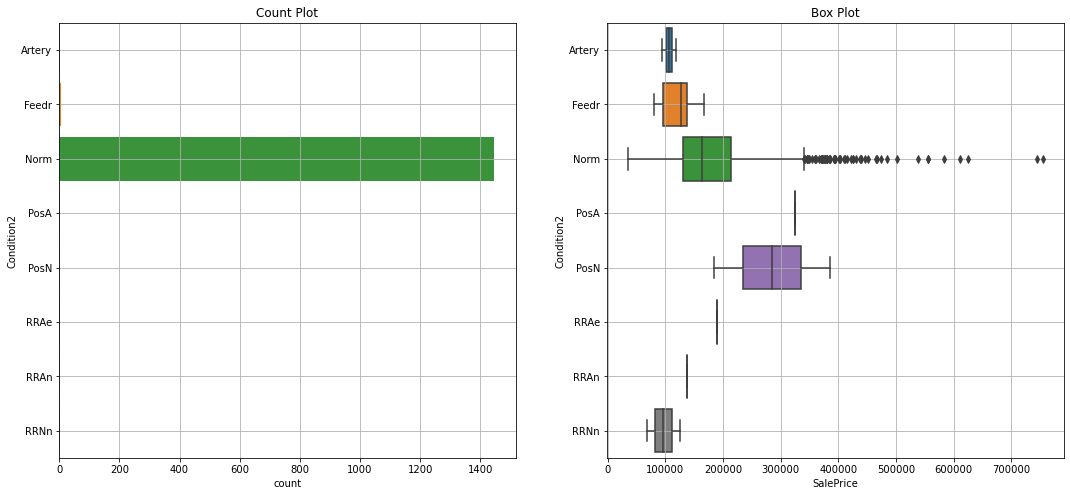

In [95]:
cat_analysis("Condition2")

In [96]:
cond2_dict = {}

for obj, key in enumerate(mean_reduction("Condition2").sort_values("mean").index):
    cond2_dict[key] = obj

train.Condition2 = train.Condition2.map(cond2_dict)

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 180295.7590
Mean Reduction = 0.3457 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 62139.1704
Mean Reduction = 21.7810 %


## BldgType

In [97]:
nan_count("BldgType")

BldgType: Number of NaN values = 0


In [98]:
train.BldgType.value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

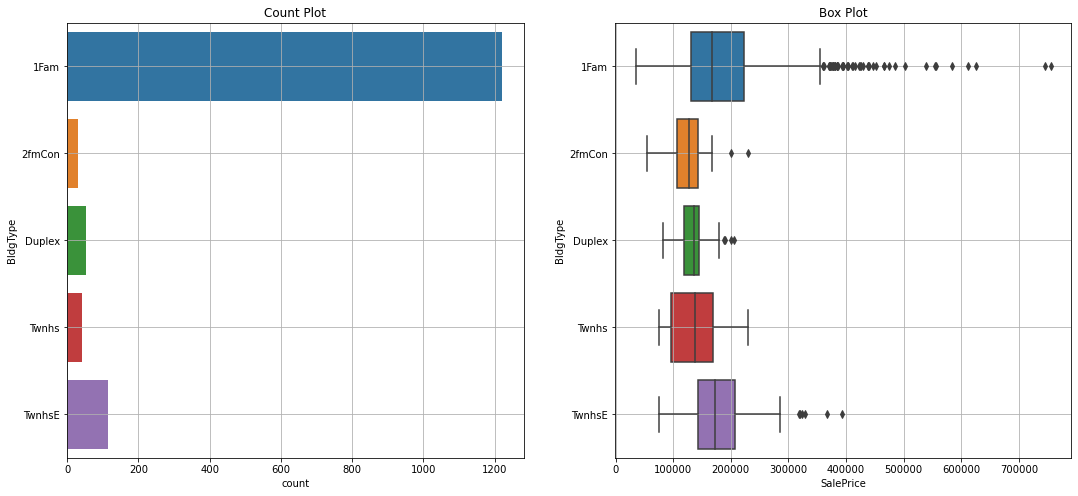

In [99]:
cat_analysis("BldgType")

In [100]:
BldgType_dict = {}
for obj, key in enumerate(mean_reduction("BldgType").sort_values("mean").index):
    BldgType_dict[key] = obj

train.BldgType = train.BldgType.map(BldgType_dict)

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 153121.6225
Mean Reduction = 15.3656 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 49515.9257
Mean Reduction = 37.6707 %


## HouseStyle

In [101]:
nan_count("HouseStyle")

HouseStyle: Number of NaN values = 0


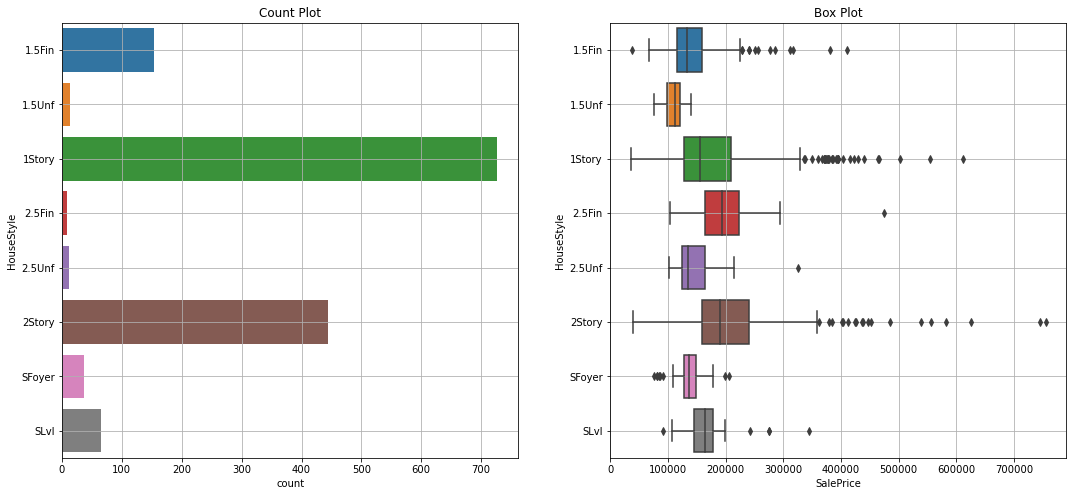

In [102]:
cat_analysis("HouseStyle")

In [103]:
HouseStyle_dict = {}

for obj, key in enumerate(mean_reduction("HouseStyle").sort_values("mean").index):
    HouseStyle_dict[key] = obj

train.HouseStyle = train.HouseStyle.map(HouseStyle_dict)

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 164804.5499
Mean Reduction = 8.9081 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 61080.1884
Mean Reduction = 23.1140 %


## OverallQual

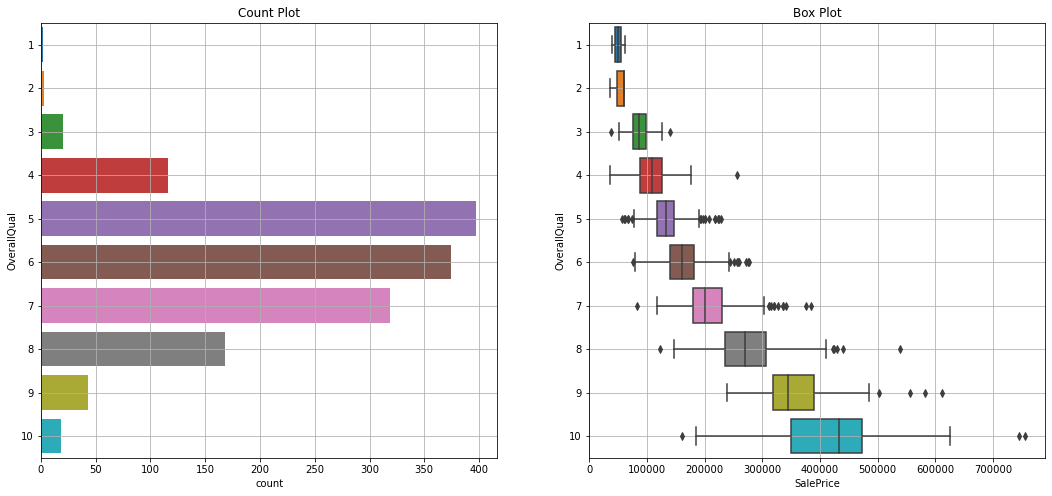

In [104]:
cat_analysis("OverallQual")

In [105]:
mean_reduction("OverallQual")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 188149.4492
Mean Reduction = -3.9952 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 49593.5331
Mean Reduction = 37.5730 %


mean            std      skew  kurtosis
OverallQual                                                  
1             50150.000000   15344.217152  0.000000 -2.000000
2             51770.333333   14254.200796 -0.707107 -1.500000
3             87473.750000   24688.567399  0.154457 -0.080320
4            108420.655172   29022.003886  0.961030  4.838197
5            133523.347607   27107.330927  0.332553  1.111189
6            161603.034759   36090.182933  0.357109  0.406551
7            207716.423197   44466.259414  0.782693  1.280099
8            274735.535714   63898.902253  0.740566  1.318193
9            367513.023256   81278.174849  1.314371  1.610063
10           438588.388889  159785.491058  0.380504 -0.040923

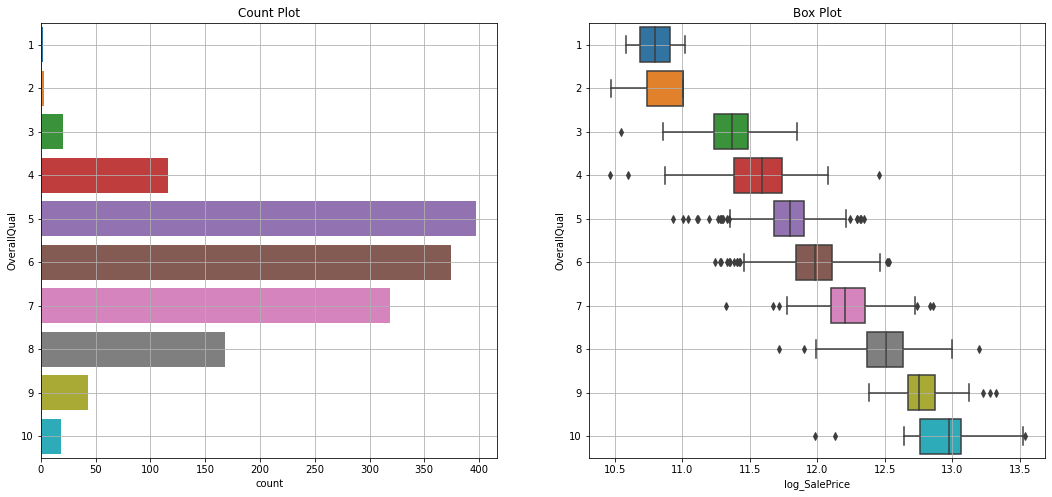

In [106]:
cat_analysis("OverallQual","log_SalePrice")

In [107]:
mean_reduction("OverallQual","log_SalePrice")

------MEAN-------
Total Mean     = 12.0241
Categ Mean     = 11.8700
Mean Reduction = 1.2809 %
------STD--------
Total Mean     = 0.3995
Categ Mean     = 0.2694
Mean Reduction = 32.5562 %


mean       std      skew  kurtosis
OverallQual                                         
1            10.798804  0.310879  0.000000 -2.000000
2            10.825383  0.306082 -0.707107 -1.500000
3            11.337474  0.306716 -0.743512  0.689926
4            11.557148  0.280295 -0.818844  2.715856
5            11.780657  0.211002 -0.609478  1.534935
6            11.967308  0.229888 -0.404589  0.440246
7            12.221773  0.210898 -0.050121  0.889456
8            12.497191  0.231313 -0.143142  0.637664
9            12.793268  0.203521  0.727296  0.556746
10           12.921305  0.403459 -0.745042  0.518987

### Relation Between *OverallCond* and *OverallQual*

In [108]:
chi_test("OverallQual", "OverallCond")

Chi Sq. Value   = 1322.0585284633246
P Vlaue of Hypo = 4.3223202616186964e-229


OverallCond  1  2  3   4    5    6   7   8  9
OverallQual                                  
1            1  0  1   0    0    0   0   0  0
2            0  0  2   0    1    0   0   0  0
3            0  2  3   6    2    5   1   1  0
4            0  1  5  20   44   24  19   2  1
5            0  1  7  21  142  104  89  29  4
6            0  0  6   6  180   83  66  30  3
7            0  0  1   3  247   28  23   8  9
8            0  0  0   1  148    7   7   2  3
9            0  1  0   0   42    0   0   0  0
10           0  0  0   0   15    1   0   0  2

## YearBuilt (Drop, High Correlation to Age_At_Sale)

In [109]:
nan_count("YearBuilt")

YearBuilt: Number of NaN values = 0


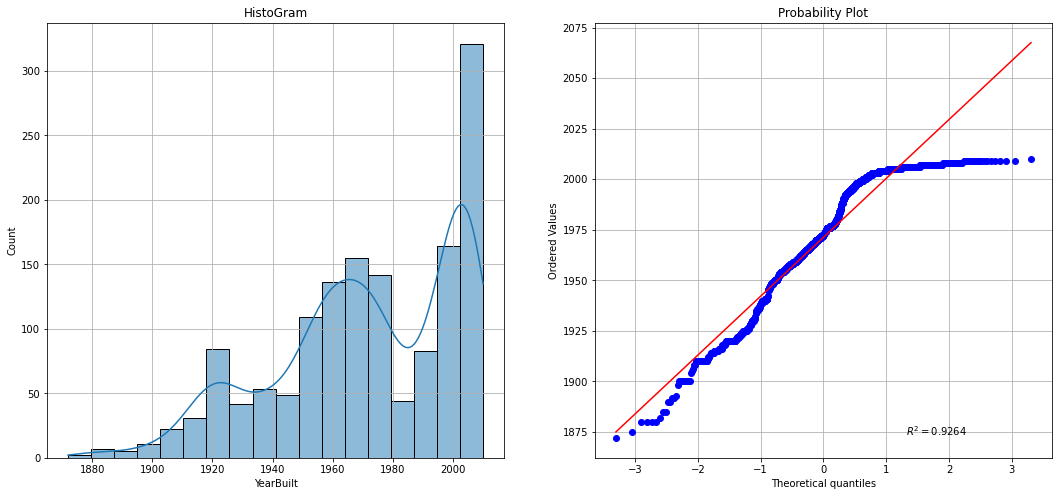

In [110]:
num_analysis("YearBuilt")

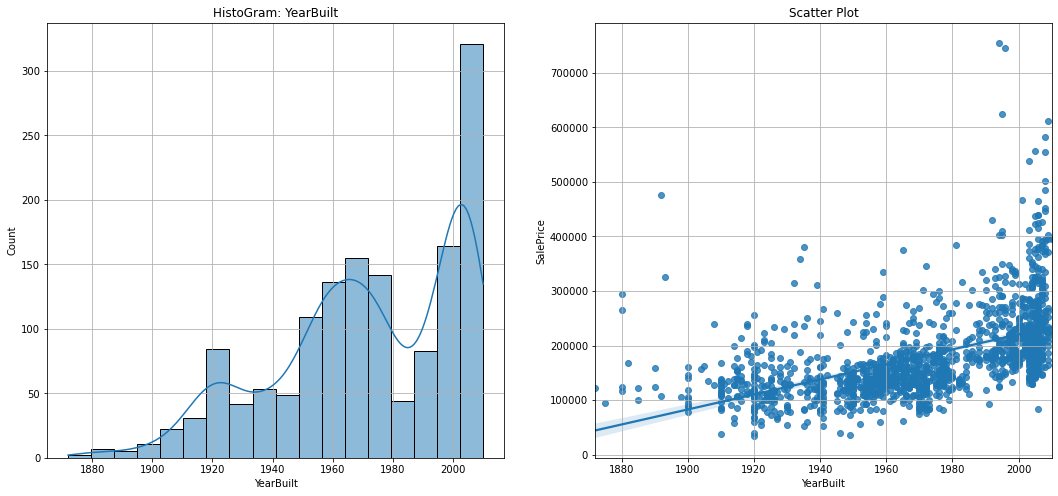

In [111]:
num_analysis("YearBuilt", "SalePrice")

## YearRemodAdd

In [112]:
nan_count("YearRemodAdd")

YearRemodAdd: Number of NaN values = 0


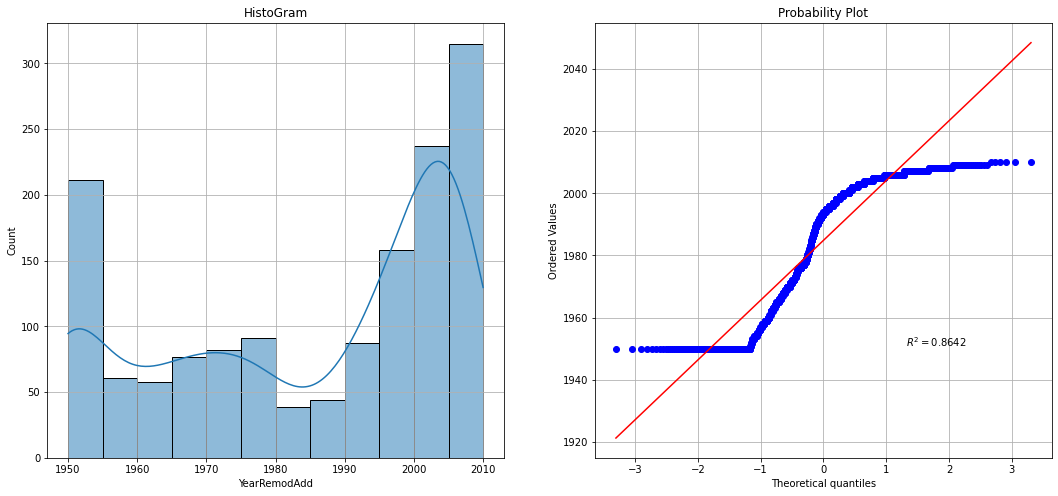

In [113]:
num_analysis("YearRemodAdd")

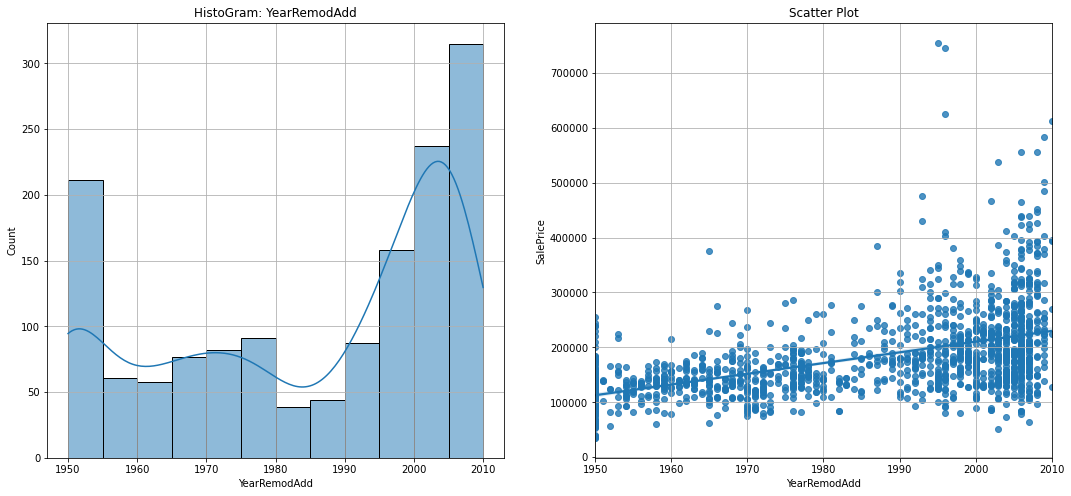

In [114]:
num_analysis("YearRemodAdd", "SalePrice")

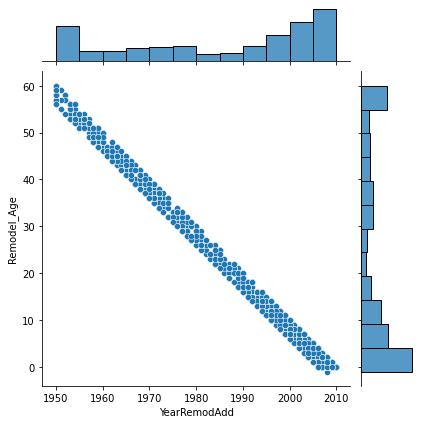

In [115]:
sns.jointplot(x=train.loc[:, "YearRemodAdd"], y=train.loc[:, "Remodel_Age"])

## RoofStyle

In [116]:
nan_count("RoofStyle")

RoofStyle: Number of NaN values = 0


In [117]:
train.RoofStyle.value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

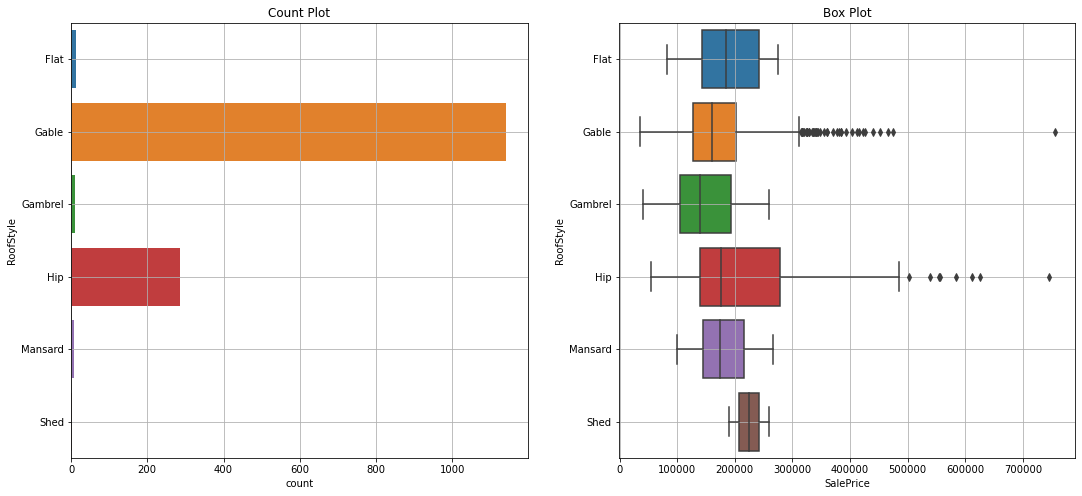

In [118]:
cat_analysis("RoofStyle")

In [119]:
RoofStyle_dict = {}

for obj, key in  enumerate(mean_reduction("RoofStyle").sort_values("mean").index):
    RoofStyle_dict[key] = obj

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 189921.4015
Mean Reduction = -4.9747 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 69162.0719
Mean Reduction = 12.9407 %


In [120]:
train.RoofStyle = train.RoofStyle.map(RoofStyle_dict)

## RoofMatl (Drop)

In [121]:
nan_count("RoofMatl")

RoofMatl: Number of NaN values = 0


In [122]:
train.RoofMatl.value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Membran       1
Roll          1
ClyTile       1
Metal         1
Name: RoofMatl, dtype: int64

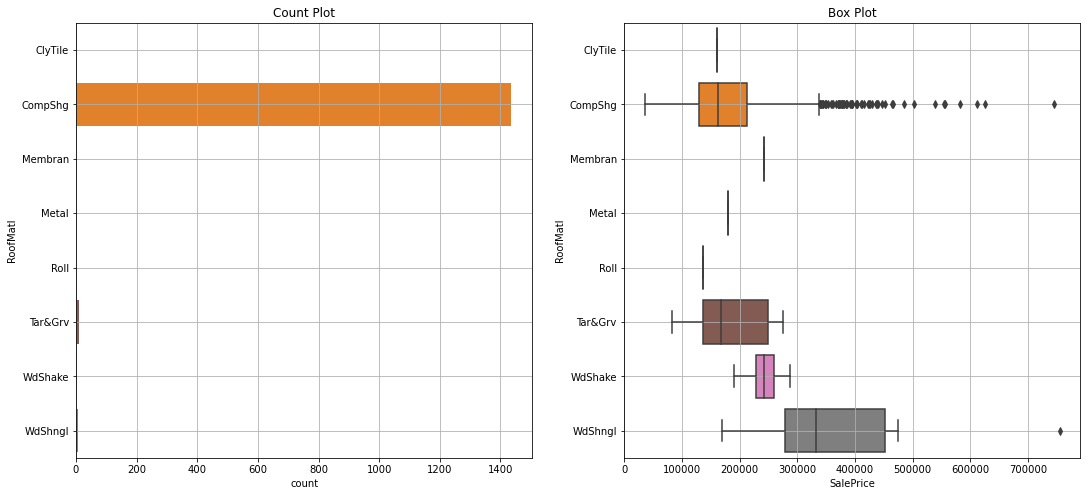

In [123]:
## Drop
cat_analysis("RoofMatl")

> - Drop The RoofMatl Variable
> - It Does Not Contain Much Information

In [124]:
mean_reduction("RoofMatl")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 214420.0054
Mean Reduction = -18.5157 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 96585.0824
Mean Reduction = -21.5786 %


mean            std      skew  kurtosis
RoofMatl                                                  
ClyTile   160000.000000            NaN  0.000000 -3.000000
CompShg   179803.679219   77722.388636  1.749238  5.399991
Membran   241500.000000            NaN  0.000000 -3.000000
Metal     180000.000000            NaN  0.000000 -3.000000
Roll      137000.000000            NaN  0.000000 -3.000000
Tar&Grv   185406.363636   65430.141720  0.091583 -1.288276
WdShake   241400.000000   36218.779659 -0.217368 -0.919664
WdShngl   390250.000000  206969.019421  0.876708 -0.321796

## Exterior1st

In [125]:
nan_count("Exterior1st")

Exterior1st: Number of NaN values = 0


In [126]:
train.Exterior1st.value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
AsphShn      1
CBlock       1
ImStucc      1
Name: Exterior1st, dtype: int64

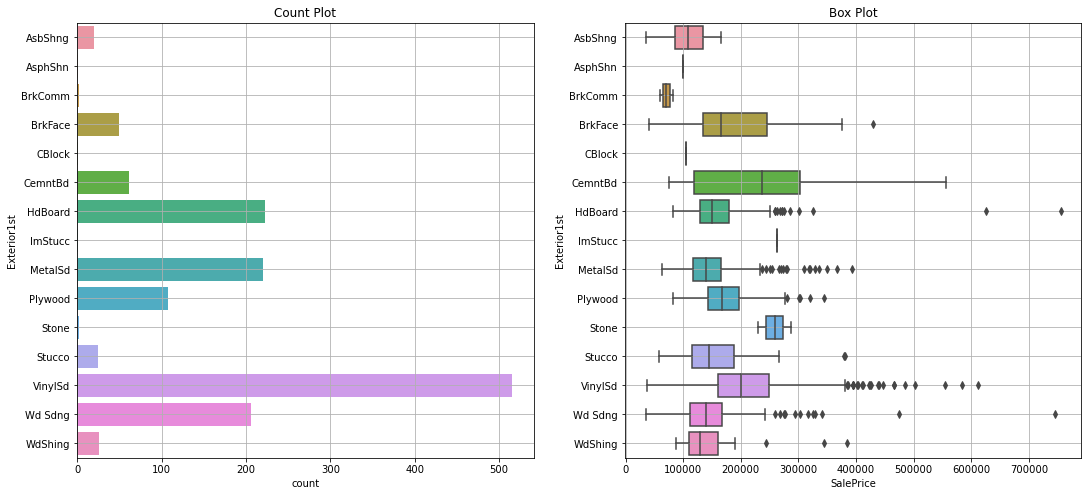

In [127]:
cat_analysis("Exterior1st")

In [128]:
Exterior1st_dict = {}

for obj, key in enumerate(mean_reduction("Exterior1st").sort_values("mean").index):
    Exterior1st_dict[key] = obj

train.Exterior1st = train.Exterior1st.map(Exterior1st_dict)

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 166387.3891
Mean Reduction = 8.0332 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 64267.2633
Mean Reduction = 19.1022 %


In [129]:
train.Exterior1st.value_counts().loc[train.Exterior1st.value_counts() <= 2].index

Int64Index([0, 13, 1, 2, 14], dtype='int64')

In [130]:
Exterior1st_dict = {}

for obj, key in enumerate(mean_reduction("Exterior1st").sort_values("mean").index):
    Exterior1st_dict[key] = obj

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 166387.3891
Mean Reduction = 8.0332 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 64267.2633
Mean Reduction = 19.1022 %


In [131]:
Exterior1st_dict[0] = 0
Exterior1st_dict[13] = 0
Exterior1st_dict[1] = 0
Exterior1st_dict[2] = 0
Exterior1st_dict[14] = 0

In [132]:
train.Exterior1st = train.Exterior1st.map(Exterior1st_dict)

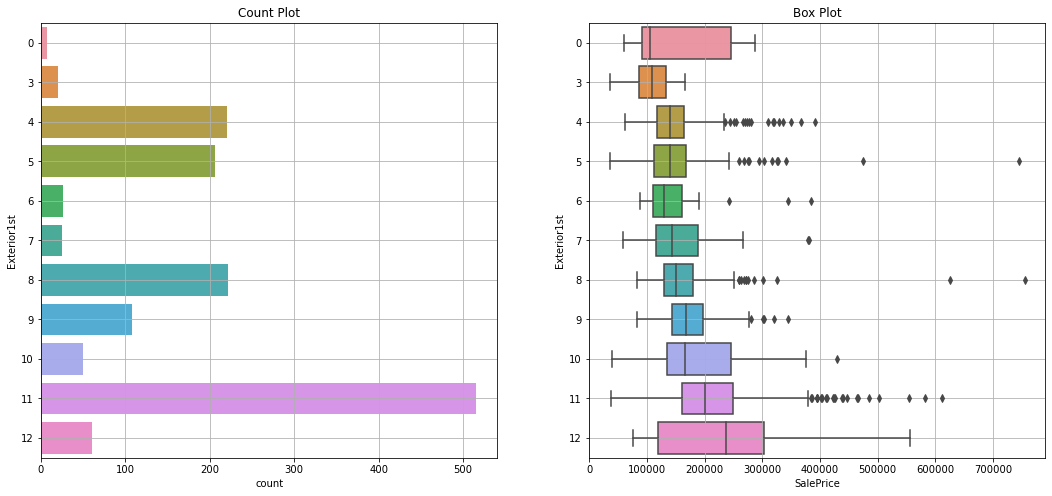

In [133]:
cat_analysis("Exterior1st")

In [134]:
mean_reduction("Exterior1st")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 169106.1800
Mean Reduction = 6.5305 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 73666.7450
Mean Reduction = 7.2704 %


mean            std      skew   kurtosis
Exterior1st                                                   
0            160857.142857   94988.470478  0.305918  -1.695223
3            107385.550000   33756.480660 -0.379896  -0.467595
4            149422.177273   54776.408990  1.835724   4.259495
5            149841.645631   71130.448152  3.719943  24.618274
6            150655.076923   72507.530741  2.127332   3.897955
7            162990.000000   83307.246529  1.357122   1.421784
8            163077.450450   66305.714164  4.955329  37.279846
9            175942.379630   49497.383293  0.993752   1.134094
10           194573.000000   82841.914370  0.790106   0.166320
11           213732.900971   80646.975785  1.292298   2.820233
12           231690.655738  120575.621318  0.573872  -0.180628

## Exterior2nd

In [135]:
train.Exterior2nd.value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64

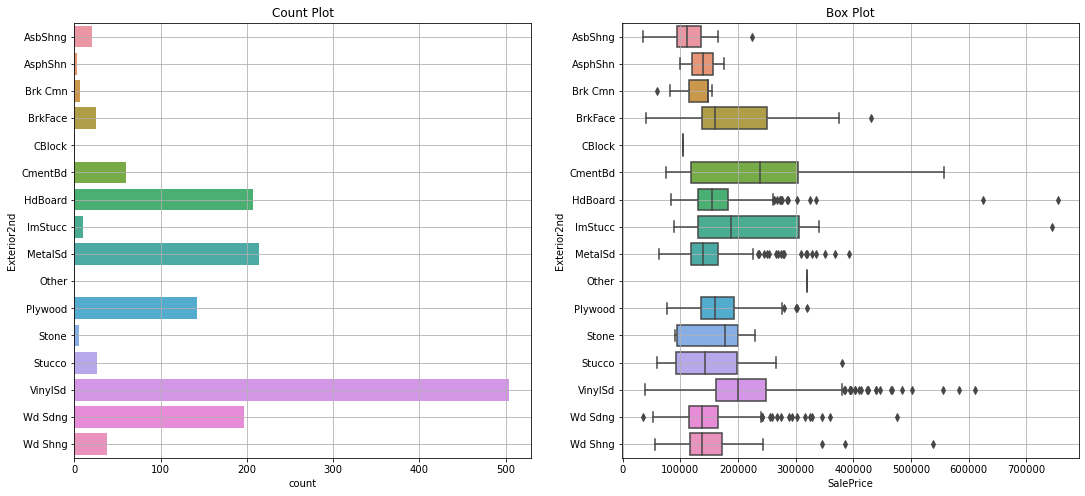

In [136]:
cat_analysis("Exterior2nd")

In [137]:
train.Exterior2nd.value_counts(normalize=True).round(4) * 100

VinylSd    34.52
MetalSd    14.66
HdBoard    14.18
Wd Sdng    13.49
Plywood     9.73
CmentBd     4.11
Wd Shng     2.60
Stucco      1.78
BrkFace     1.71
AsbShng     1.37
ImStucc     0.68
Brk Cmn     0.48
Stone       0.34
AsphShn     0.21
CBlock      0.07
Other       0.07
Name: Exterior2nd, dtype: float64

In [138]:
train.Exterior2nd = train.Exterior2nd.map(
    {
        "VinylSd": "VinylSd",
        "MetalSd": "MetalSd",
        "HdBoard": "HdBoard",
        "Wd Sdng": "Wd Sdng",
        "Plywood": "Plywood",
    }
)

train.Exterior2nd.fillna("REST", inplace=True)

In [139]:
train.Exterior2nd.value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
REST       196
Plywood    142
Name: Exterior2nd, dtype: int64

In [140]:
train.Exterior2nd.value_counts(normalize=True).round(4)* 100

VinylSd    34.52
MetalSd    14.66
HdBoard    14.18
Wd Sdng    13.49
REST       13.42
Plywood     9.73
Name: Exterior2nd, dtype: float64

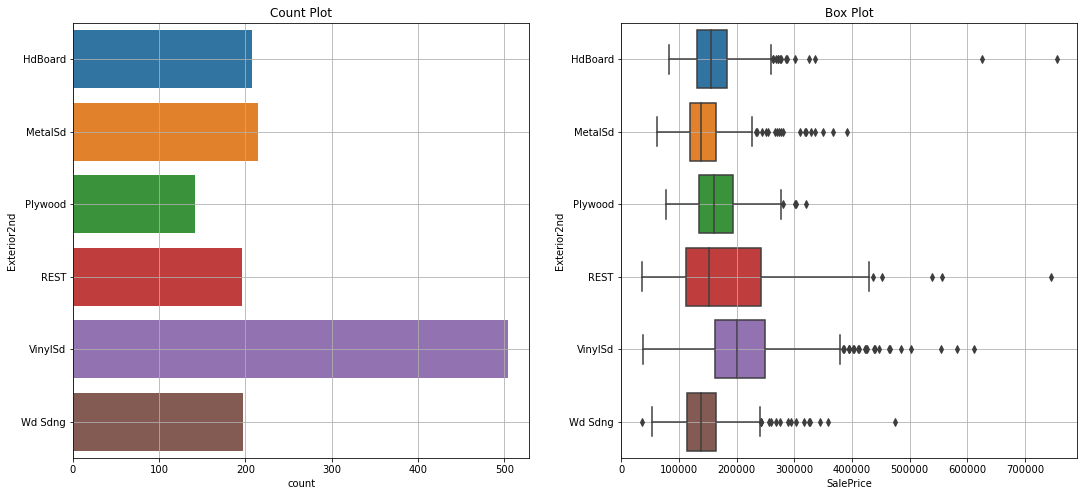

In [141]:
cat_analysis("Exterior2nd")

In [142]:
Exterior2nd_dict = {}

for obj, key in enumerate(mean_reduction("Exterior2nd").sort_values("Exterior2nd").index):
    Exterior2nd_dict[key] = obj

train.Exterior2nd = train.Exterior2nd.map(Exterior2nd_dict)

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 172184.2659
Mean Reduction = 4.8291 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 69882.8090
Mean Reduction = 12.0335 %


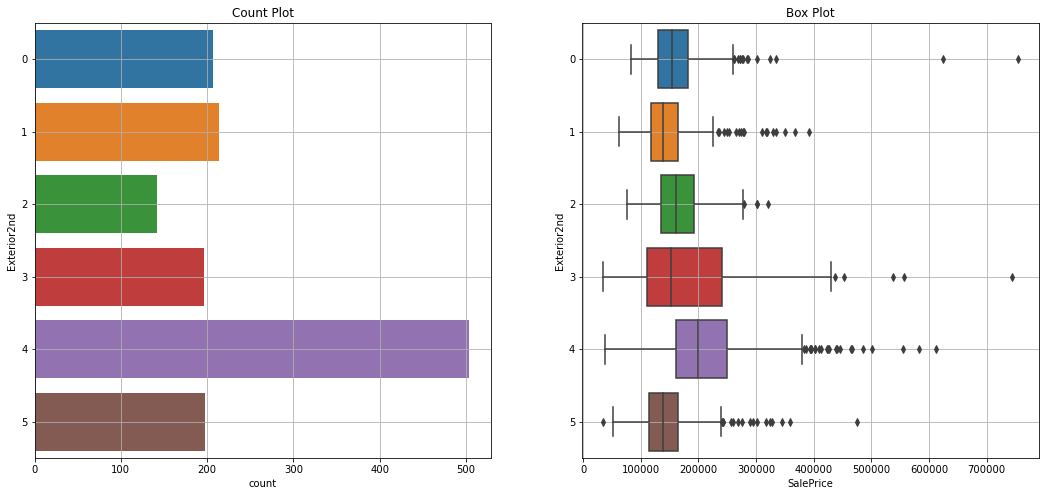

In [143]:
cat_analysis("Exterior2nd")

## MasVnrType

In [144]:
nan_count("MasVnrType")

MasVnrType: Number of NaN values = 8


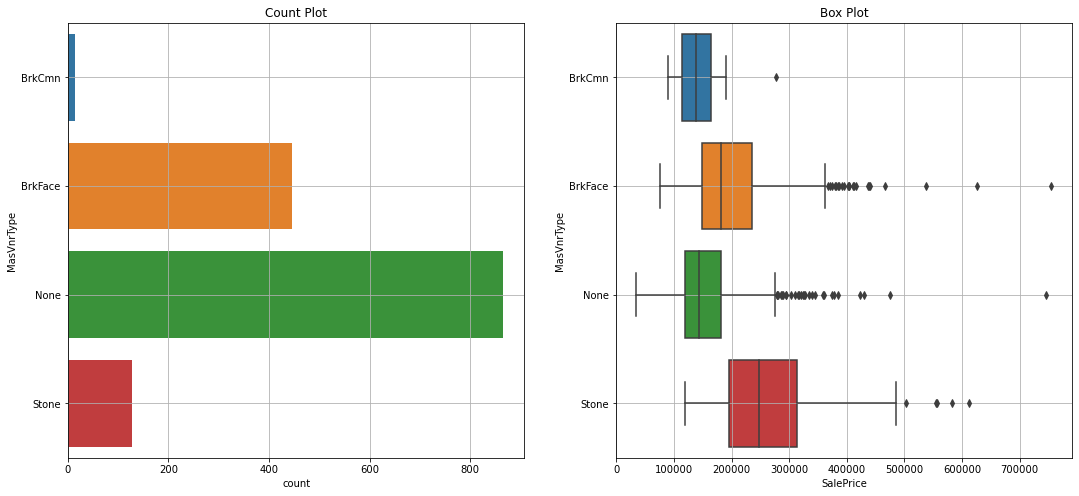

In [145]:
cat_analysis("MasVnrType")

In [146]:
train.MasVnrType.value_counts(dropna=False)

None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

In [147]:
train.MasVnrType.fillna("None", inplace=True)

In [148]:
train.MasVnrType.value_counts(dropna=False)

None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

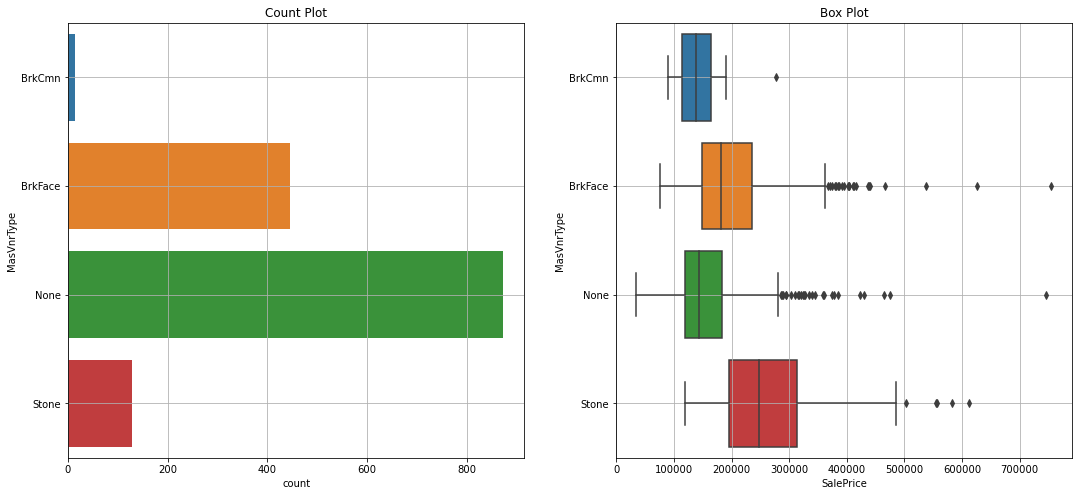

In [149]:
cat_analysis("MasVnrType")

In [150]:
MasVnrType_dict = {}
for obj, key in enumerate(mean_reduction("MasVnrType").sort_values("mean").index):
    MasVnrType_dict[key] = obj

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 193387.9517
Mean Reduction = -6.8907 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 72208.4307
Mean Reduction = 9.1060 %


In [151]:
MasVnrType_dict

{'BrkCmn': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3}

In [152]:
train.MasVnrType = train.MasVnrType.map(MasVnrType_dict)

## MasVnrArea

In [153]:
nan_count("MasVnrArea")

MasVnrArea: Number of NaN values = 8


In [154]:
train.MasVnrArea.describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [155]:
train.MasVnrArea.fillna(0, inplace=True)

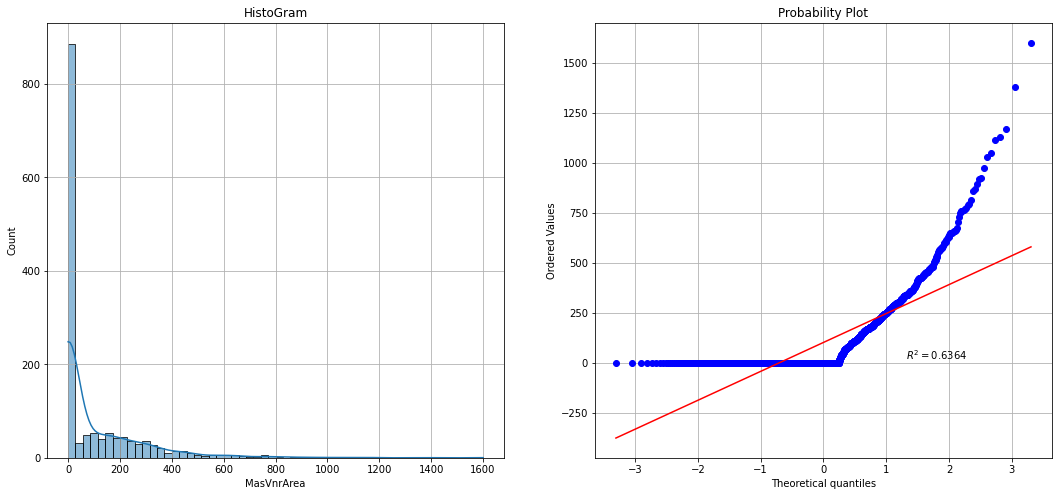

In [156]:
num_analysis("MasVnrArea")

In [157]:
train.loc[:,["MasVnrArea", "MasVnrType"]].loc[train.MasVnrArea == 0].MasVnrType.value_counts()

1    867
2      1
3      1
Name: MasVnrType, dtype: int64

In [158]:
train.loc[:,["MasVnrArea", "MasVnrType"]].loc[train.MasVnrArea != 0].MasVnrType.value_counts()

2    444
3    127
0     15
1      5
Name: MasVnrType, dtype: int64

## ExterQual

In [159]:
nan_count("ExterQual")

ExterQual: Number of NaN values = 0


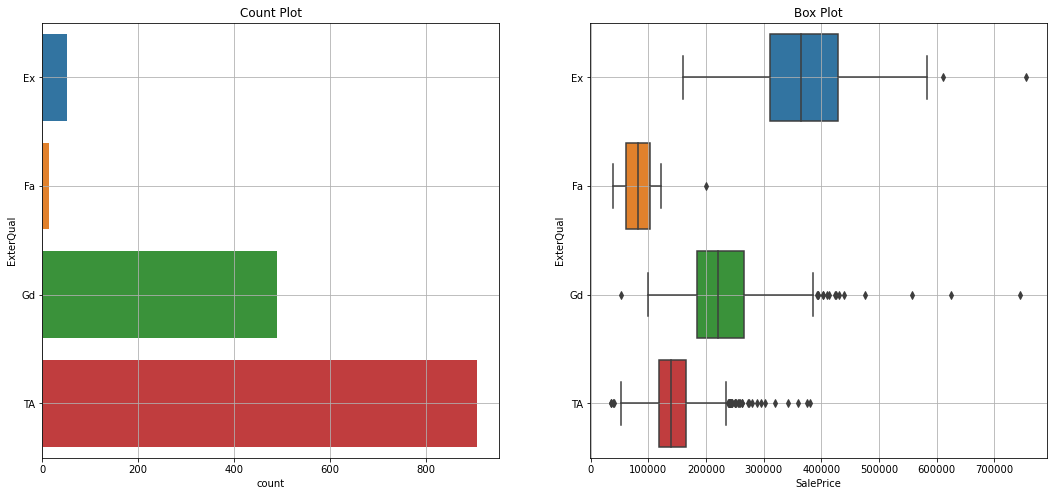

In [160]:
cat_analysis("ExterQual")

In [161]:
mean_reduction("ExterQual")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 207830.2499
Mean Reduction = -14.8734 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 67472.2181
Mean Reduction = 15.0679 %


mean            std      skew  kurtosis
ExterQual                                                  
Ex         367360.961538  116401.264200  0.728383  1.244714
Fa          87985.214286   39826.918794  1.559590  2.534499
Gd         231633.510246   71188.873899  1.793877  7.698168
TA         144341.313466   42471.815703  1.142810  3.590700

In [162]:
train.ExterQual = train.ExterQual.map(
    {
        "Fa": 0,
        "TA": 1,
        "Gd": 2,
        "Ex": 3,
    }
)

## ExterCond (DROP!!)

In [163]:
nan_count("ExterCond")

ExterCond: Number of NaN values = 0


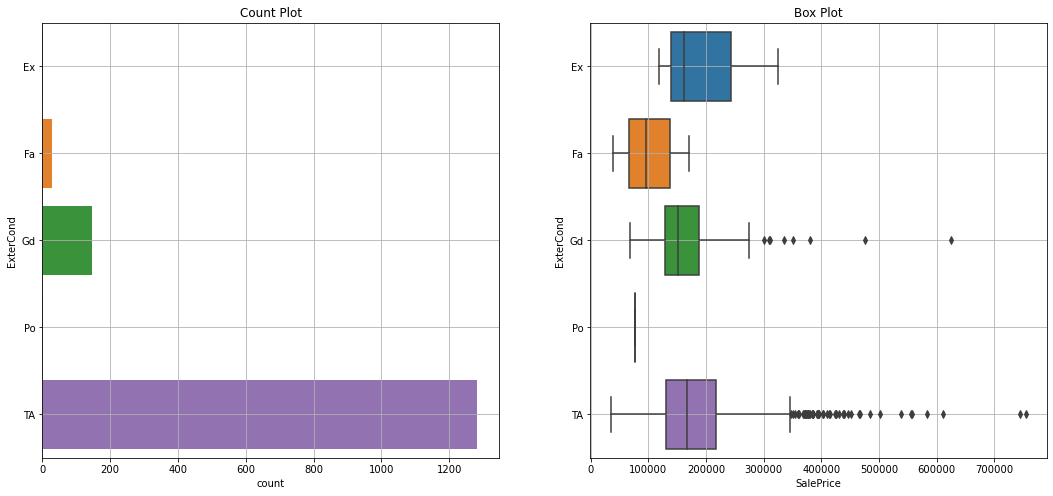

In [164]:
cat_analysis("ExterCond")

## Foundation

In [165]:
nan_count("Foundation")

Foundation: Number of NaN values = 0


In [166]:
train.Foundation.value_counts()

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

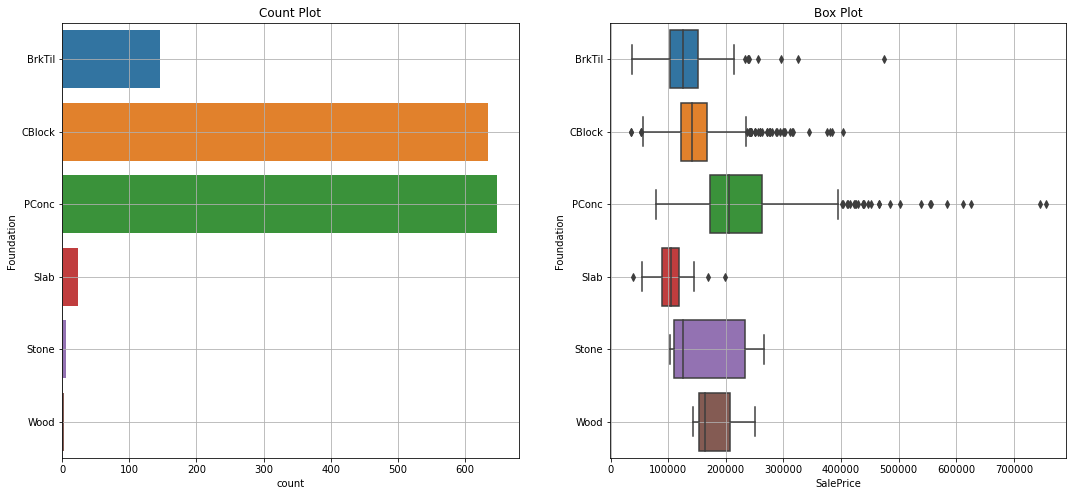

In [167]:
cat_analysis("Foundation")

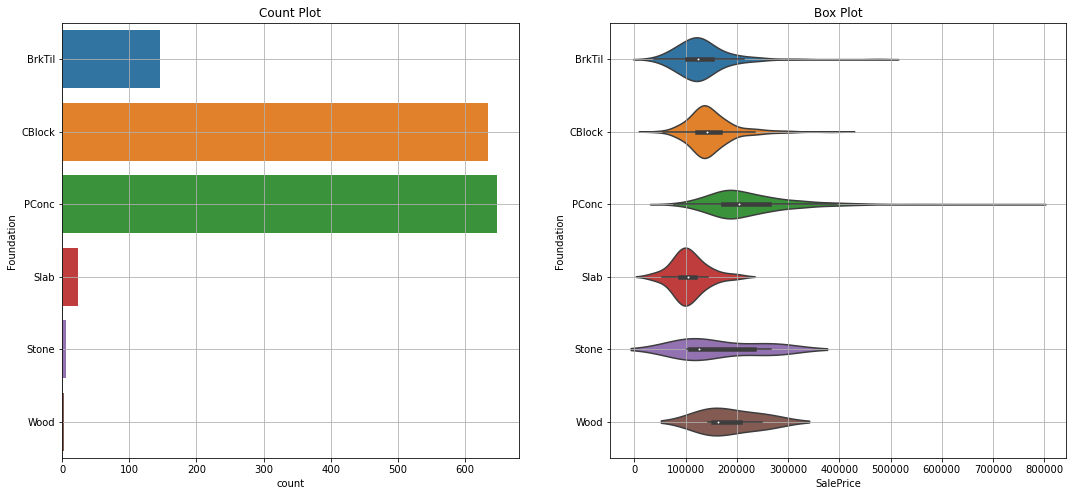

In [168]:
cat_analysis("Foundation", Violin=True)

In [169]:
Foundation_dict = {}

for obj, key in enumerate(mean_reduction("Foundation").sort_values("mean").index):
    Foundation_dict[key] = obj

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 161053.1150
Mean Reduction = 10.9816 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 59870.0314
Mean Reduction = 24.6373 %


In [170]:
train.Foundation = train.Foundation.map(Foundation_dict)

## Basement

In [171]:
Bsmt_index = [ _ for _ in [ _ for _ in train.columns if "Bsm" in _] if "SF" in _ ]

In [172]:
Bsmt_index

['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

In [173]:
[ _ for _ in [ _ for _ in train.columns if "Bsm" in _] if "SF" not in _ ]

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath']

## BsmtQual

In [174]:
train.BsmtQual.value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

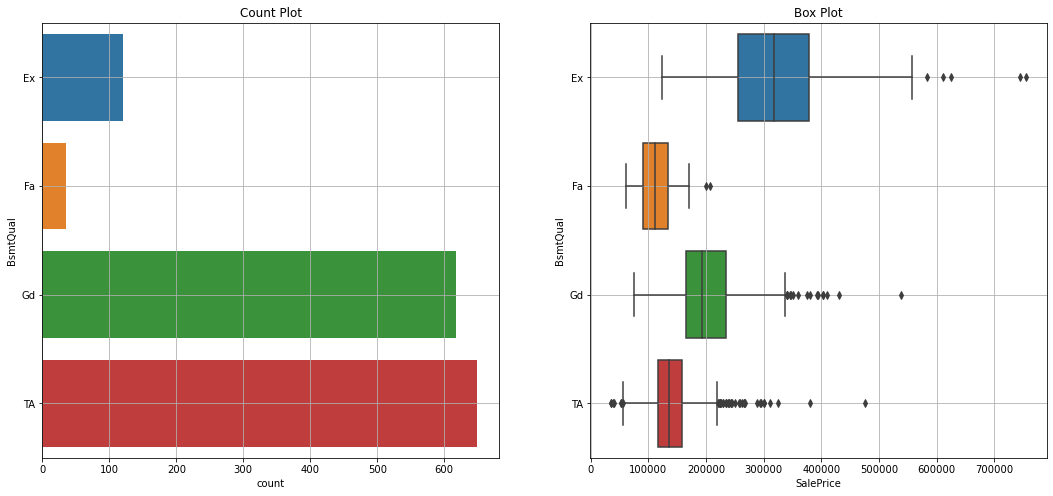

In [175]:
cat_analysis("BsmtQual")

In [176]:
train.BsmtQual = train.BsmtQual.map(
    {
        "Fa": 0,
        "TA": 1,
        "Gd": 2,
        "Ex": 3,
    }
)

In [177]:
train.BsmtQual.fillna(-1, inplace=True)

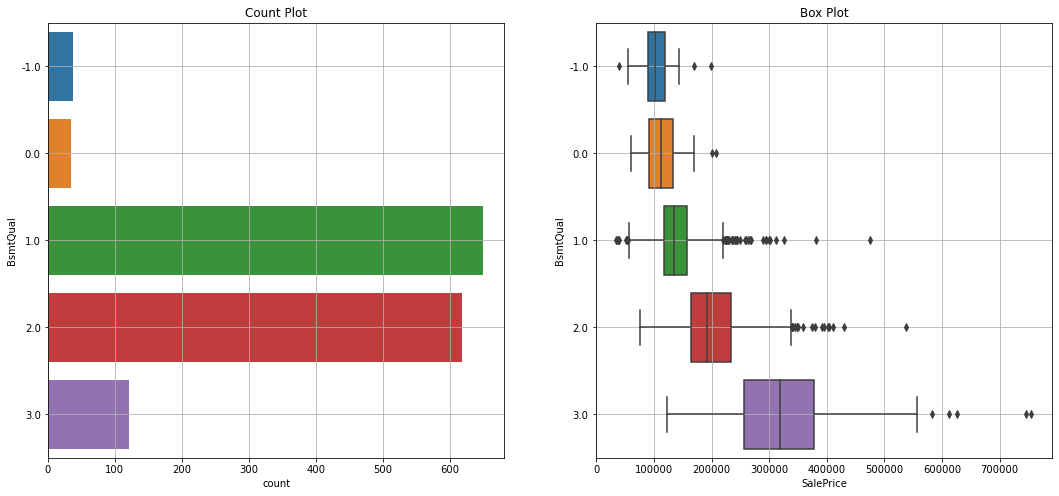

In [178]:
cat_analysis("BsmtQual")

## BsmtCond (Drop!)

In [179]:
train.BsmtCond.value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

## Heating (DROP!)

In [180]:
nan_count("Heating")

Heating: Number of NaN values = 0


In [181]:
train.Heating.value_counts(normalize=True).round(4)*100

GasA     97.81
GasW      1.23
Grav      0.48
Wall      0.27
OthW      0.14
Floor     0.07
Name: Heating, dtype: float64

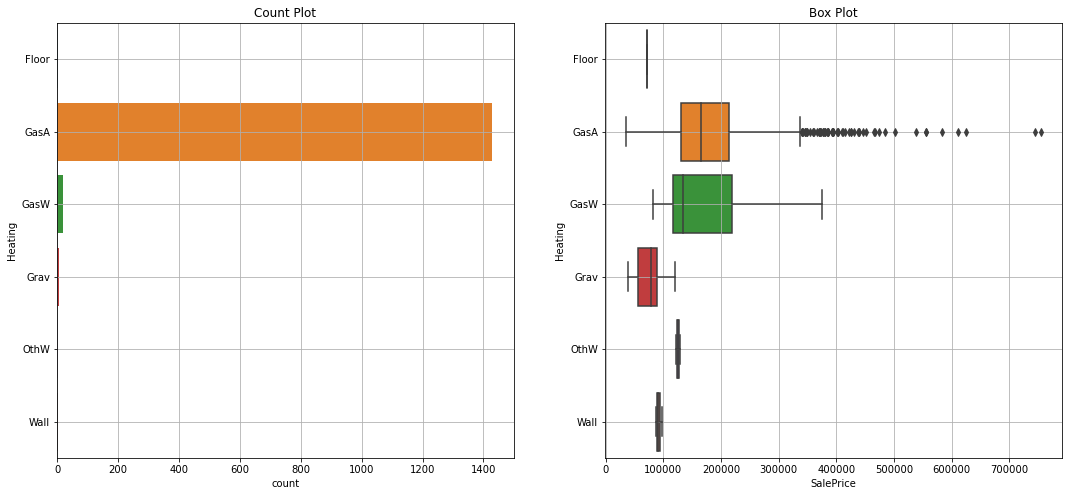

In [182]:
cat_analysis("Heating")

## BsmtExposure

In [183]:
train.BsmtExposure.value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [184]:
train.BsmtExposure = train.BsmtExposure.map(
    {
        "No": 0,
        "Mn": 1,
        "Av": 2,
        "Gd": 3,
    }
)

In [185]:
train.BsmtExposure.fillna(-1, inplace=True)

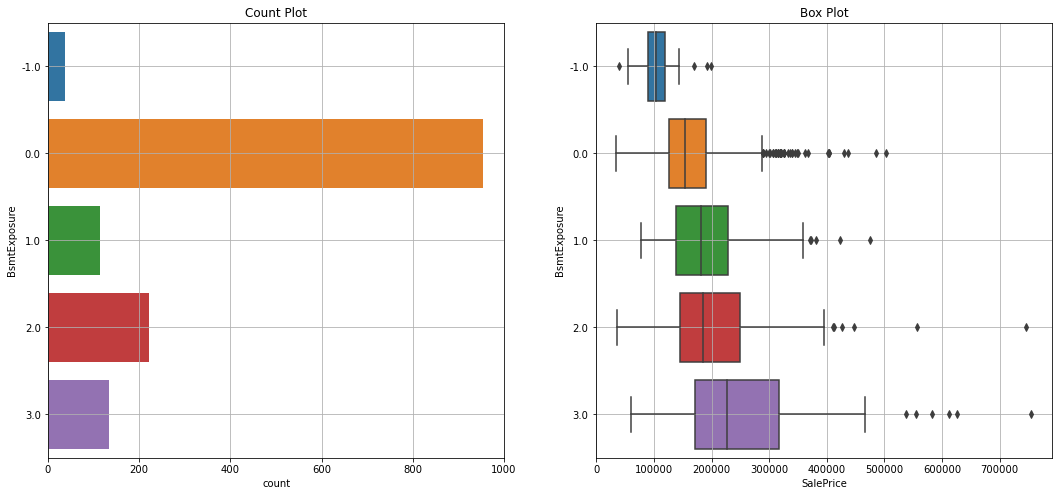

In [186]:
cat_analysis("BsmtExposure")

## BsmtFinType1

In [187]:
train.BsmtFinType1.value_counts(dropna=False)

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NaN     37
Name: BsmtFinType1, dtype: int64

In [188]:
train.BsmtFinType1.value_counts(dropna=False, normalize=True).round(4) * 100

Unf    29.45
GLQ    28.63
ALQ    15.07
BLQ    10.14
Rec     9.11
LwQ     5.07
NaN     2.53
Name: BsmtFinType1, dtype: float64

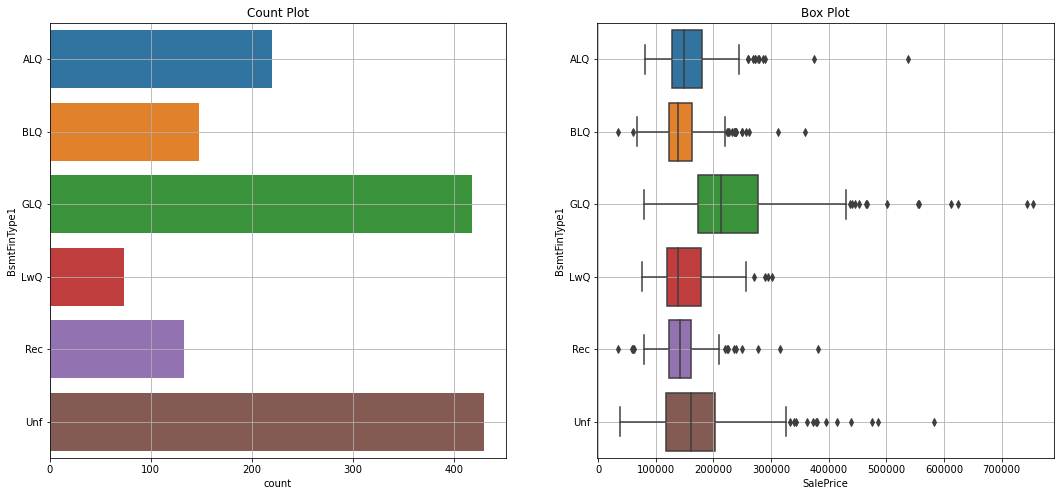

In [189]:
cat_analysis("BsmtFinType1")

In [190]:
train.BsmtFinType1 = train.BsmtFinType1.map(
    {
        "Unf": 0,
        "LwQ": 1,
        "Rec": 2,
        "BLQ": 3,
        "ALQ": 4,
        "GLQ": 5,
    }
)

In [191]:
train.BsmtFinType1.fillna(-1, inplace=True)

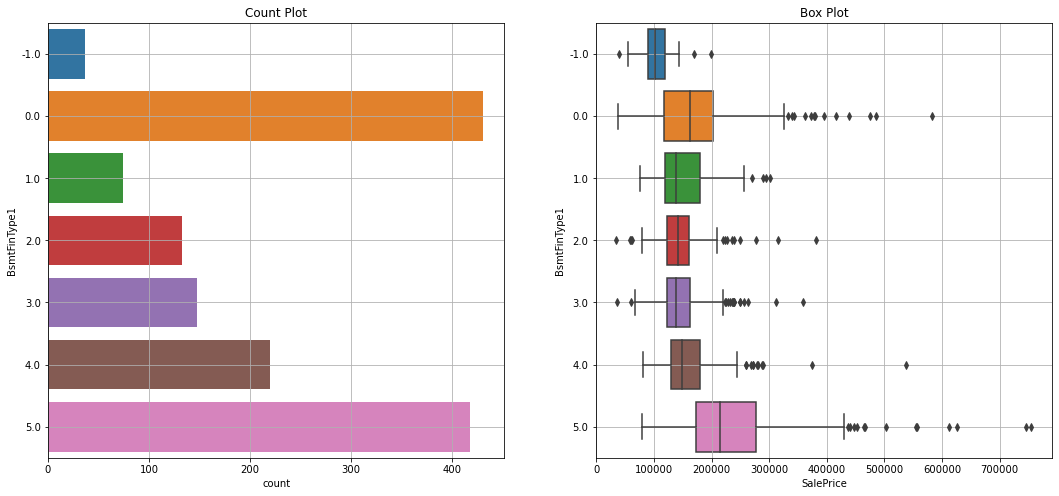

In [192]:
cat_analysis("BsmtFinType1")

In [193]:
mean_reduction("BsmtFinType1")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 160220.8376
Mean Reduction = 11.4416 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 55601.0091
Mean Reduction = 30.0110 %


mean           std      skew   kurtosis
BsmtFinType1                                                  
-1.0          105652.891892  29278.694797  0.787447   1.884873
 0.0          170670.576744  72577.080129  1.416616   3.810829
 1.0          151852.702703  50796.987083  1.174375   1.089927
 2.0          146889.248120  45190.118879  1.578908   6.064493
 3.0          149493.655405  47327.292126  1.203884   2.704081
 4.0          161573.068182  50821.277231  2.591656  13.840377
 5.0          235413.720096  93215.613258  1.698872   5.090662

## BsmtFinType2

In [194]:
nan_count("BsmtFinType2")

BsmtFinType2: Number of NaN values = 38


In [195]:
train.BsmtFinType2.value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [196]:
train.BsmtFinType2 = train.BsmtFinType2.map(
    {
        "Unf": 0,
        "LwQ": 1,
        "Rec": 2,
        "BLQ": 3,
        "ALQ": 4,
        "GLQ": 5,
    }
)

In [197]:
train.BsmtFinType2.fillna(-1, inplace=True)

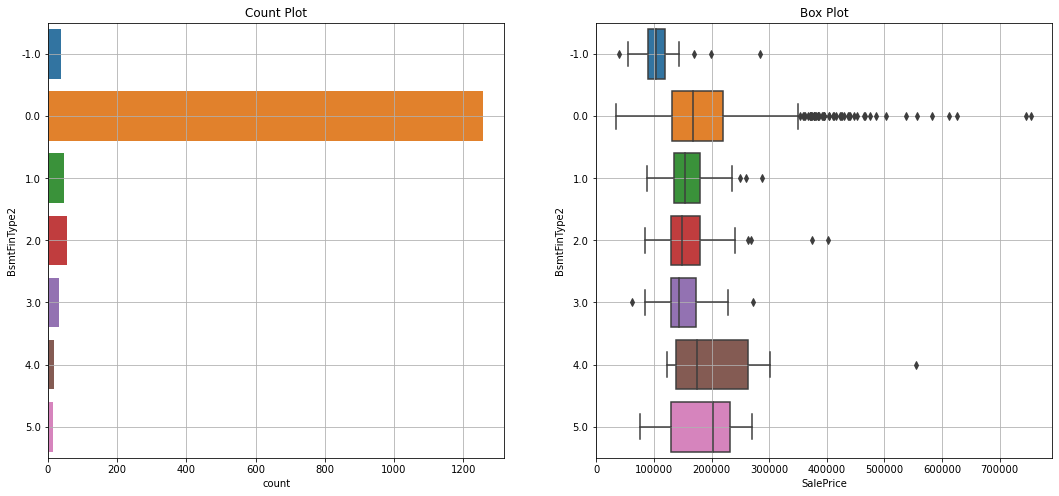

In [198]:
cat_analysis("BsmtFinType2")

## HeatingQC

In [199]:
nan_count("HeatingQC")

HeatingQC: Number of NaN values = 0


In [200]:
train.HeatingQC.value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

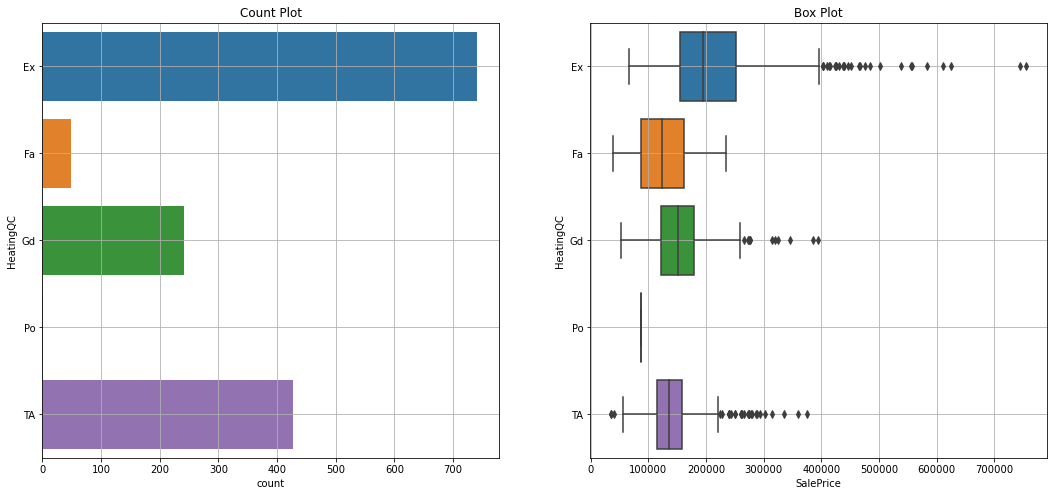

In [201]:
cat_analysis("HeatingQC")

In [202]:
train.HeatingQC.unique()

HeatingQC_dict = {
    "Ex": 0,
    "Gd": 1,
    "TA": 2,
    "Fa": 3,
    "Po": 3,
}

train.HeatingQC.map(HeatingQC_dict).value_counts(normalize=True).round(4) * 100

0    50.75
2    29.32
1    16.51
3     3.42
Name: HeatingQC, dtype: float64

In [203]:
train.HeatingQC = train.HeatingQC.map(HeatingQC_dict)

## CentralAir

In [204]:
nan_count("CentralAir")

CentralAir: Number of NaN values = 0


In [205]:
train.CentralAir.value_counts(normalize=True) .round(4)* 100

Y    93.49
N     6.51
Name: CentralAir, dtype: float64

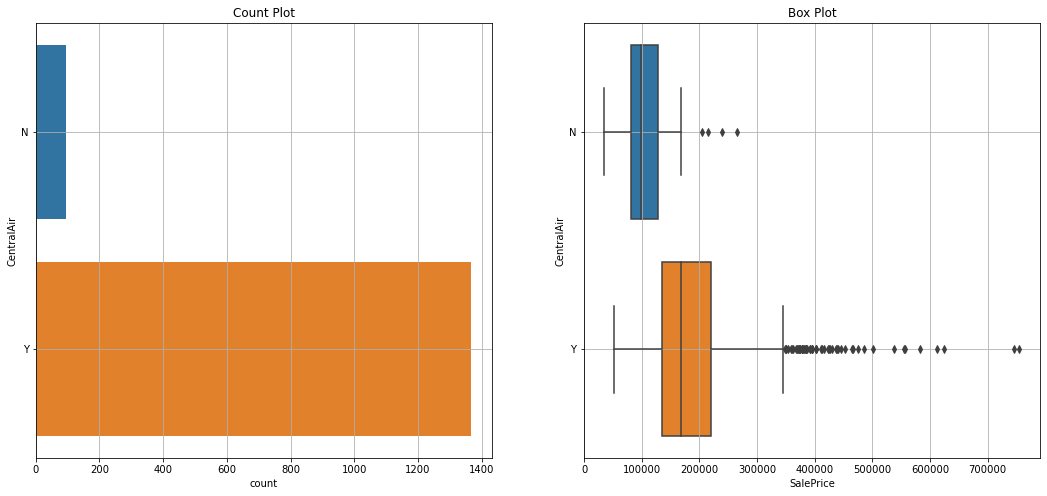

In [206]:
cat_analysis("CentralAir")

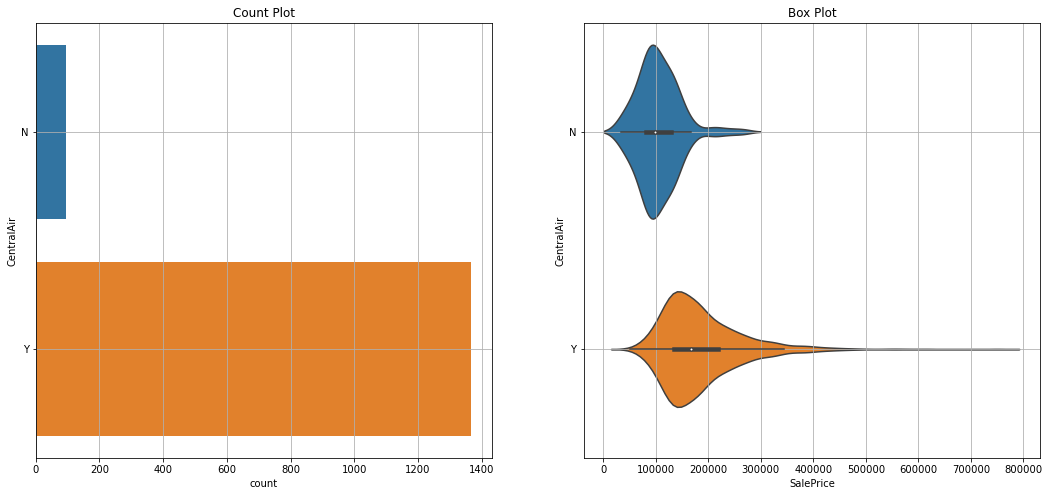

In [207]:
cat_analysis("CentralAir", Violin=True)

In [208]:
mean_reduction("CentralAir")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 145725.3918
Mean Reduction = 19.4537 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 59738.2404
Mean Reduction = 24.8032 %


mean           std      skew  kurtosis
CentralAir                                                 
N           105264.073684  40671.273961  1.169027  2.717054
Y           186186.709890  78805.206820  1.963899  6.807669

In [209]:
CentralAir_dict = {
    "N": 0,
    "Y": 1,
}

train.CentralAir = train.CentralAir.map(CentralAir_dict)

## Electrical

In [210]:
nan_count("Electrical")

Electrical: Number of NaN values = 1


In [211]:
train.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [212]:
train.Electrical.value_counts(normalize=True).round(4) * 100

SBrkr    91.43
FuseA     6.44
FuseF     1.85
FuseP     0.21
Mix       0.07
Name: Electrical, dtype: float64

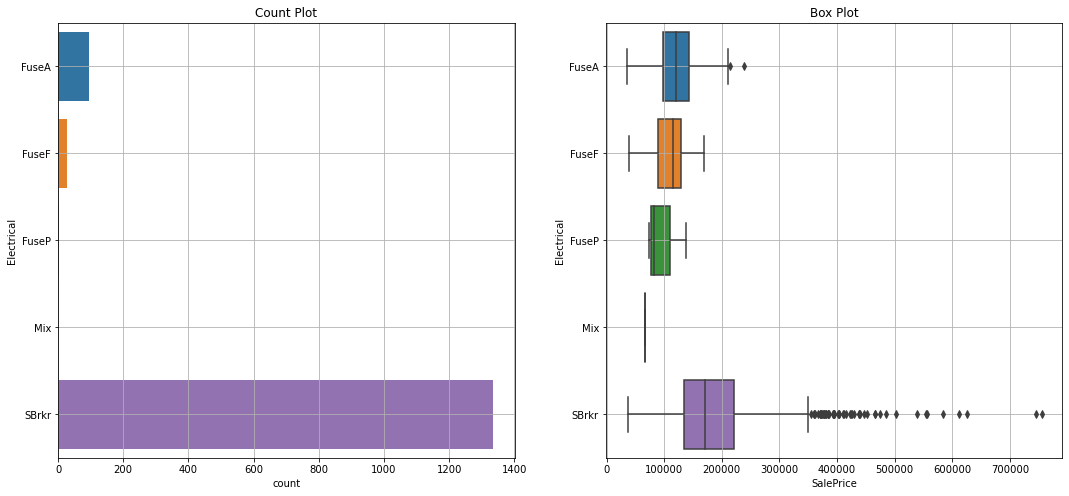

In [213]:
cat_analysis("Electrical")

In [214]:
train.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [215]:
train.Electrical = train.Electrical.apply(lambda x: 1 if (x=="SBrkr") else 0)

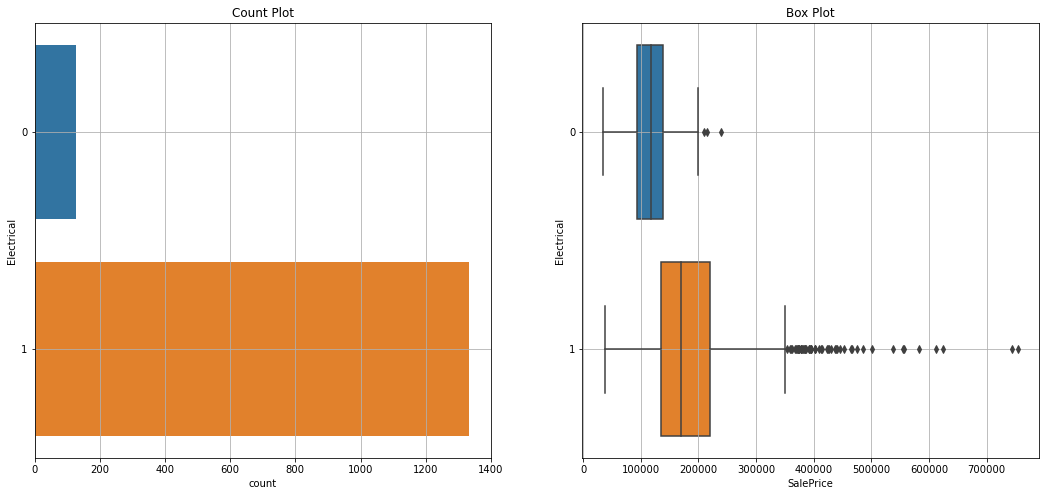

In [216]:
cat_analysis("Electrical")

## BedroomAbvGr

In [217]:
nan_count("BedroomAbvGr")

BedroomAbvGr: Number of NaN values = 0


In [218]:
train.BedroomAbvGr.value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

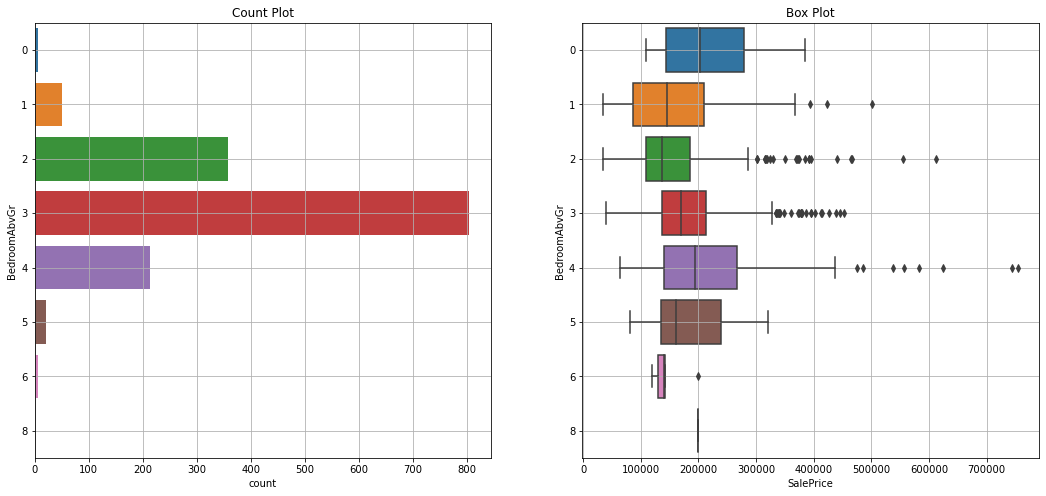

In [219]:
cat_analysis("BedroomAbvGr")

In [220]:
train.BedroomAbvGr.value_counts(normalize=True).round(4) * 100

3    55.07
2    24.52
4    14.59
1     3.42
5     1.44
6     0.48
0     0.41
8     0.07
Name: BedroomAbvGr, dtype: float64

In [221]:
mean_reduction("BedroomAbvGr").sort_values("mean")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 184866.1772
Mean Reduction = -2.1805 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 79440.0528
Mean Reduction = 0.0031 %


mean            std      skew  kurtosis
BedroomAbvGr                                                  
6             143779.000000   26455.384839  1.510435  1.166394
2             158197.659218   78197.106241  2.093612  6.298546
1             173162.420000  102975.067584  1.184939  1.188272
5             180819.047619   68472.480743  0.502166 -0.660556
3             181056.870647   63793.924903  1.217931  1.954024
8             200000.000000            NaN  0.000000 -3.000000
4             220421.253521  109510.516383  1.941543  5.396161
0             221493.166667  106675.888935  0.425696 -1.211711

In [222]:
train.BedroomAbvGr = train.BedroomAbvGr.map(
    {
        0: 1,
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 5,
        6: 5,
        7: 5,
        8: 5,
    }
)

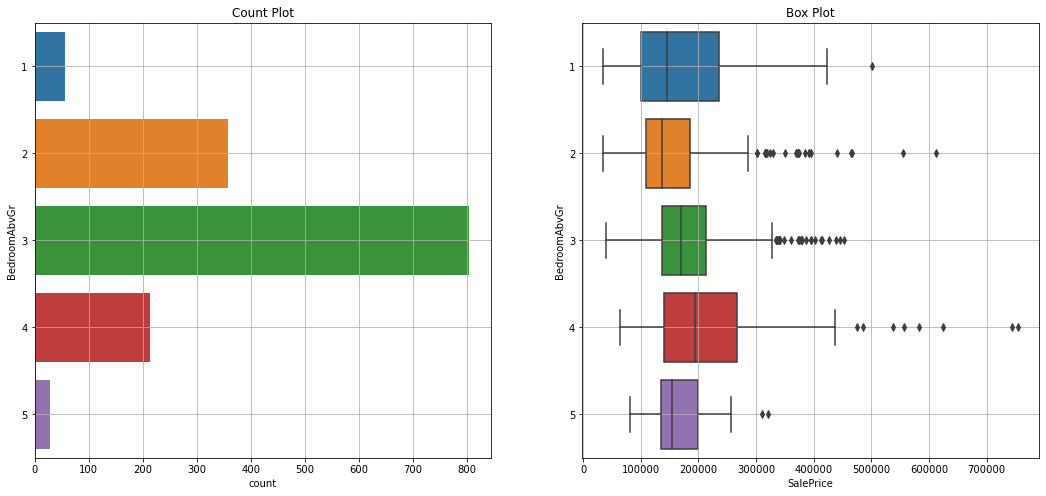

In [223]:
cat_analysis("BedroomAbvGr")

In [224]:
mean_reduction("BedroomAbvGr")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 182111.2513
Mean Reduction = -0.6578 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 83300.1744
Mean Reduction = -4.8559 %


mean            std      skew  kurtosis
BedroomAbvGr                                                  
1             178340.714286  103484.880803  1.074242  0.781505
2             158197.659218   78197.106241  2.093612  6.298546
3             181056.870647   63793.924903  1.217931  1.954024
4             220421.253521  109510.516383  1.941543  5.396161
5             172539.758621   61514.443533  0.801759 -0.051893

## KitchenAbvGr (Not TO Be Used Directly) Dropped

In [225]:
nan_count("KitchenAbvGr")

KitchenAbvGr: Number of NaN values = 0


In [226]:
train.KitchenAbvGr.value_counts()

1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [227]:
train.KitchenAbvGr.value_counts(normalize=True).round(4) * 100

1    95.34
2     4.45
3     0.14
0     0.07
Name: KitchenAbvGr, dtype: float64

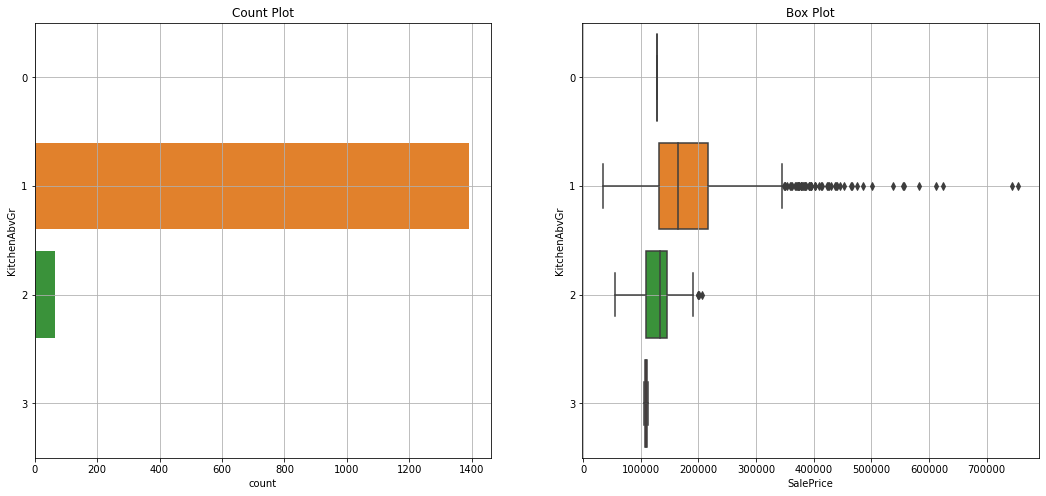

In [228]:
cat_analysis("KitchenAbvGr")

## KitchenQual

In [229]:
nan_count("KitchenQual")

KitchenQual: Number of NaN values = 0


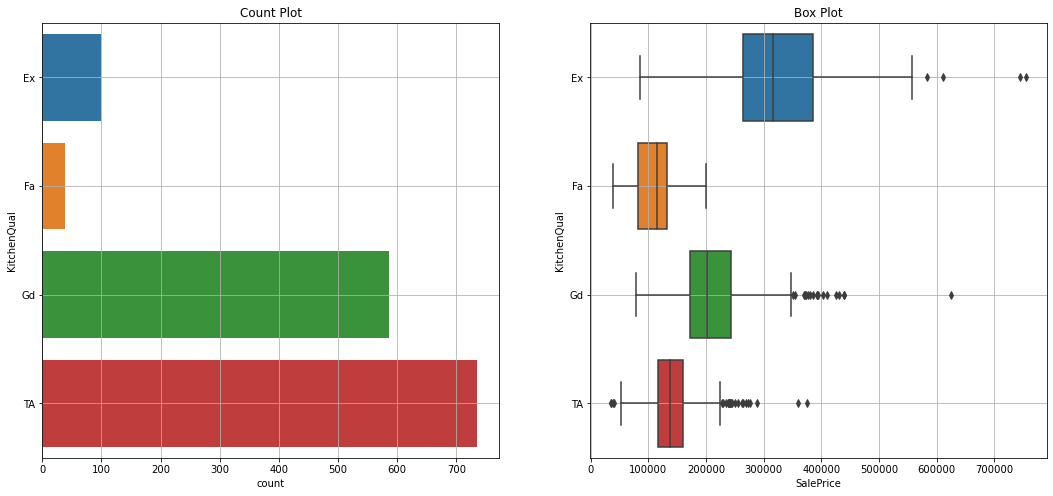

In [230]:
cat_analysis("KitchenQual")

In [231]:
train.KitchenQual.value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

In [232]:
train.KitchenQual = train.KitchenQual.map(
    {
        "Fa": 0,
        "TA": 1,
        "Gd": 2,
        "Ex": 3
    }
)

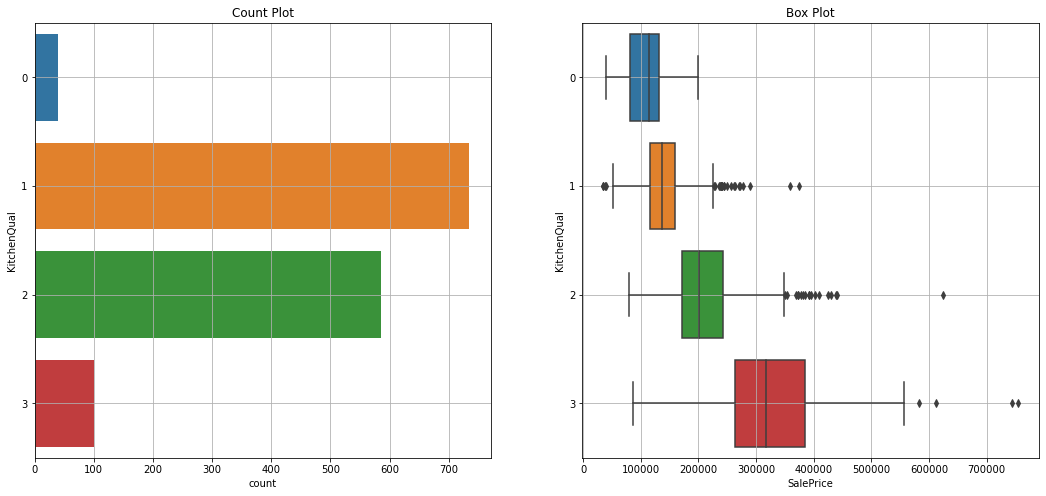

In [233]:
cat_analysis("KitchenQual")

In [234]:
mean_reduction("KitchenQual")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 196549.6026
Mean Reduction = -8.6382 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 64945.9134
Mean Reduction = 18.2479 %


mean            std      skew  kurtosis
KitchenQual                                                  
0            105565.205128   36004.254037  0.232863 -0.255302
1            139962.511565   38896.280336  0.996612  3.652486
2            212116.023891   64020.176702  1.185759  3.366636
3            328554.670000  120862.942573  0.922703  1.820550

## TotRmsAbvGrd

In [235]:
nan_count("TotRmsAbvGrd")

TotRmsAbvGrd: Number of NaN values = 0


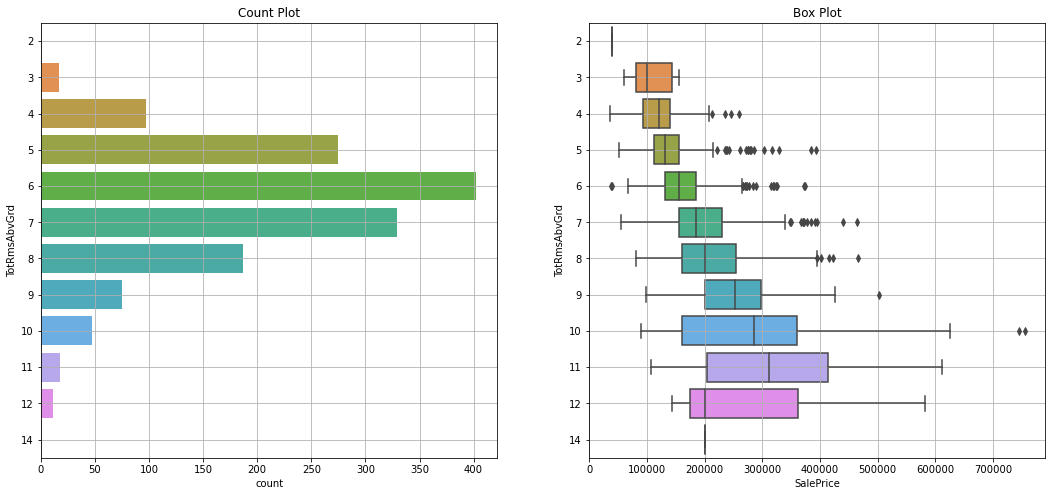

In [236]:
cat_analysis("TotRmsAbvGrd")

In [237]:
train.TotRmsAbvGrd.value_counts().sort_index()

2       1
3      17
4      97
5     275
6     402
7     329
8     187
9      75
10     47
11     18
12     11
14      1
Name: TotRmsAbvGrd, dtype: int64

In [238]:
train.TotRmsAbvGrd = train.TotRmsAbvGrd.map(
    {
        1 : 3,
        2 : 3,
        3 : 3,
        4 : 4,
        5 : 5,
        6 : 6,
        7 : 7,
        8 : 8,
        9 : 9,
        10:10,
        11:11,
        12:12,
        13:12,
        14:12,
    }
)

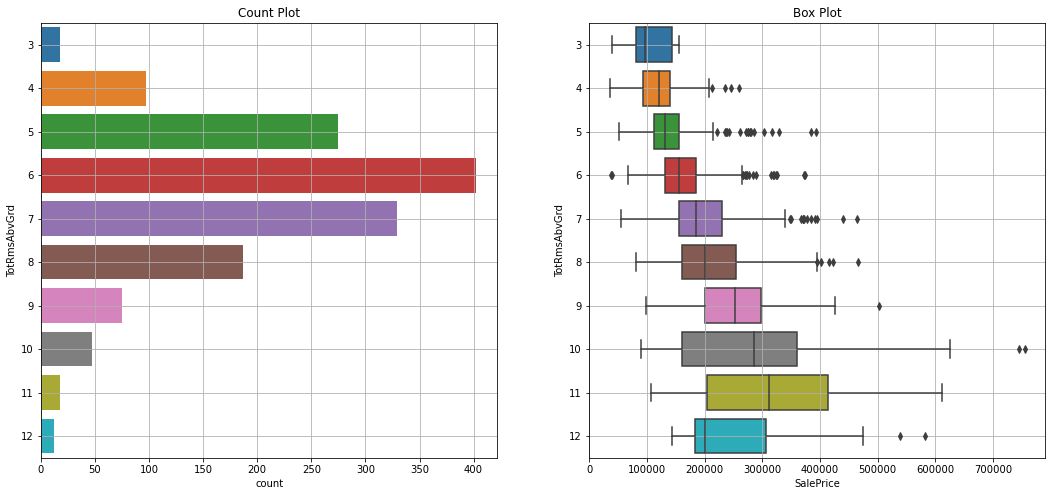

In [239]:
cat_analysis("TotRmsAbvGrd")

In [240]:
mean_reduction("TotRmsAbvGrd")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 208452.8387
Mean Reduction = -15.2175 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 86064.1715
Mean Reduction = -8.3352 %


mean            std      skew  kurtosis
TotRmsAbvGrd                                                  
3             107222.222222   36318.161970 -0.117054 -1.310909
4             122844.628866   41661.805370  0.760222  1.264673
5             141550.749091   49656.905700  1.890533  5.508219
6             161303.296020   48707.372941  0.959624  2.163478
7             196666.784195   64404.686026  1.019251  1.600607
8             213427.529412   73985.715639  0.858471  0.499570
9             252988.173333   83131.922273  0.331793  0.089782
10            296279.170213  155027.992122  1.144008  1.349232
11            318022.000000  148216.975202  0.294642 -0.686301
12            274223.833333  159530.177676  1.124890 -0.489046

## Fireplaces

In [241]:
nan_count("Fireplaces")

Fireplaces: Number of NaN values = 0


In [242]:
train.Fireplaces.value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [243]:
train.Fireplaces.value_counts(normalize=True).round(4) * 100

0    47.26
1    44.52
2     7.88
3     0.34
Name: Fireplaces, dtype: float64

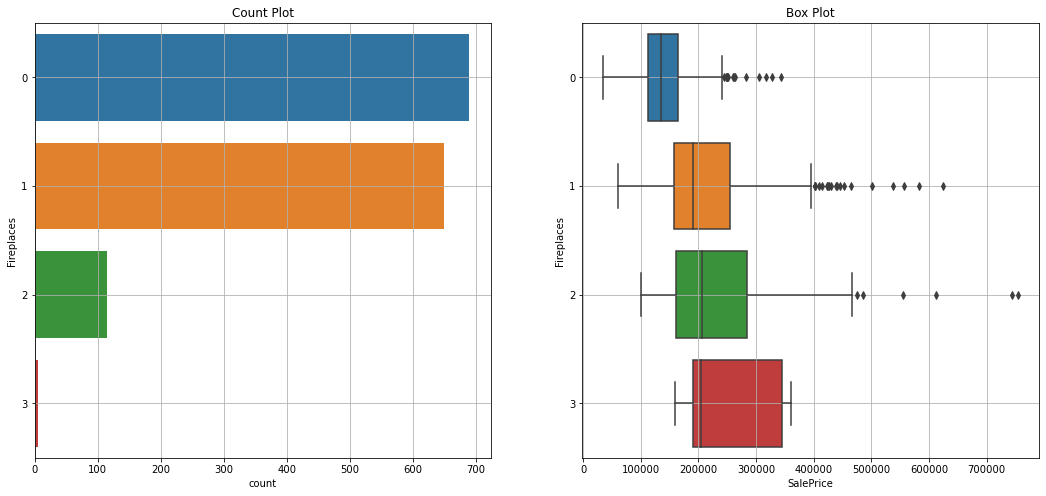

In [244]:
cat_analysis("Fireplaces")

In [245]:
train.Fireplaces = train.Fireplaces.apply(lambda x: 2 if (x > 2) else x)

In [246]:
train.Fireplaces.value_counts()

0    690
1    650
2    120
Name: Fireplaces, dtype: int64

In [247]:
train.Fireplaces.value_counts(normalize=True).round(4) * 100

0    47.26
1    44.52
2     8.22
Name: Fireplaces, dtype: float64

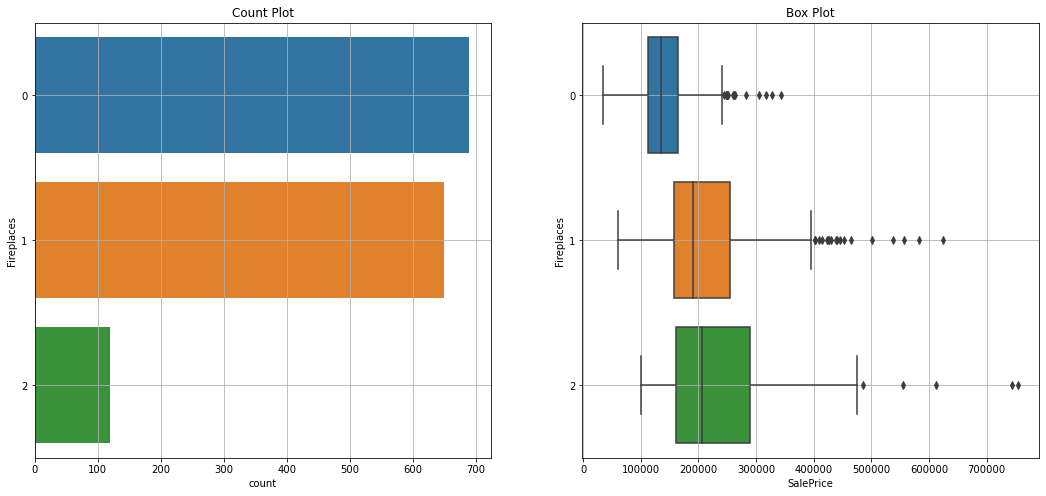

In [248]:
cat_analysis("Fireplaces")

In [249]:
mean_reduction("Fireplaces")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 198079.8028
Mean Reduction = -9.4840 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 80056.0239
Mean Reduction = -0.7723 %


mean            std      skew  kurtosis
Fireplaces                                                  
0           141331.482609   44389.786884  0.763780  1.245669
1           211843.909231   79531.825318  1.339179  2.674325
2           241064.016667  116246.459371  2.043046  5.374948

## FireplaceQu

In [250]:
nan_count("FireplaceQu")

FireplaceQu: Number of NaN values = 690


In [251]:
train.FireplaceQu.value_counts(dropna=False)

NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: FireplaceQu, dtype: int64

In [252]:
train.FireplaceQu.value_counts(normalize=True, dropna=False).round(5) * 100

NaN    47.260
Gd     26.027
TA     21.438
Fa      2.260
Ex      1.644
Po      1.370
Name: FireplaceQu, dtype: float64

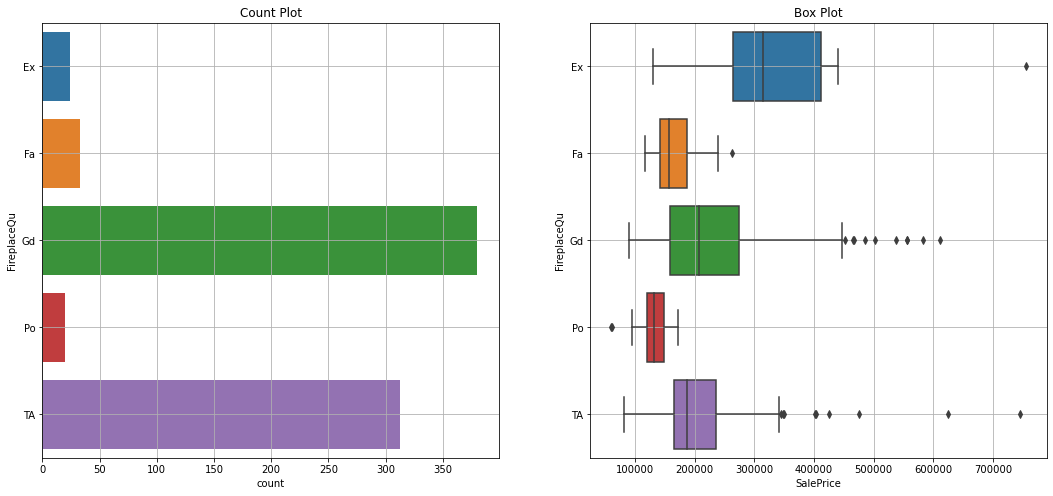

In [253]:
cat_analysis("FireplaceQu")

In [254]:
train.FireplaceQu = train.FireplaceQu.fillna("NA")

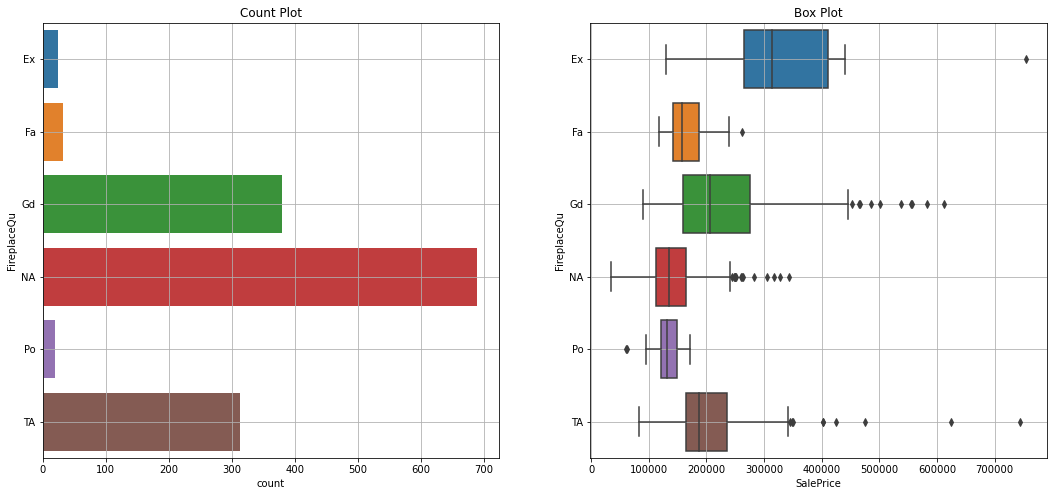

In [255]:
cat_analysis("FireplaceQu")

In [256]:
mean_reduction("FireplaceQu").sort_values("mean")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 201363.5870
Mean Reduction = -11.2991 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 65976.6659
Mean Reduction = 16.9504 %


mean            std      skew   kurtosis
FireplaceQu                                                   
Po           129764.150000   31080.842115 -0.831140   0.278500
NA           141331.482609   44389.786884  0.763780   1.245669
Fa           167298.484848   34287.717564  0.894086   0.373925
TA           205723.488818   71367.028772  2.585307  13.584703
Gd           226351.415789   91123.148369  1.197213   1.767435
Ex           337712.500000  123611.471764  1.386957   3.554678

In [257]:
train.FireplaceQu = train.FireplaceQu.map(
    {
        "Po": 0,
        "NA": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5,
    }
)

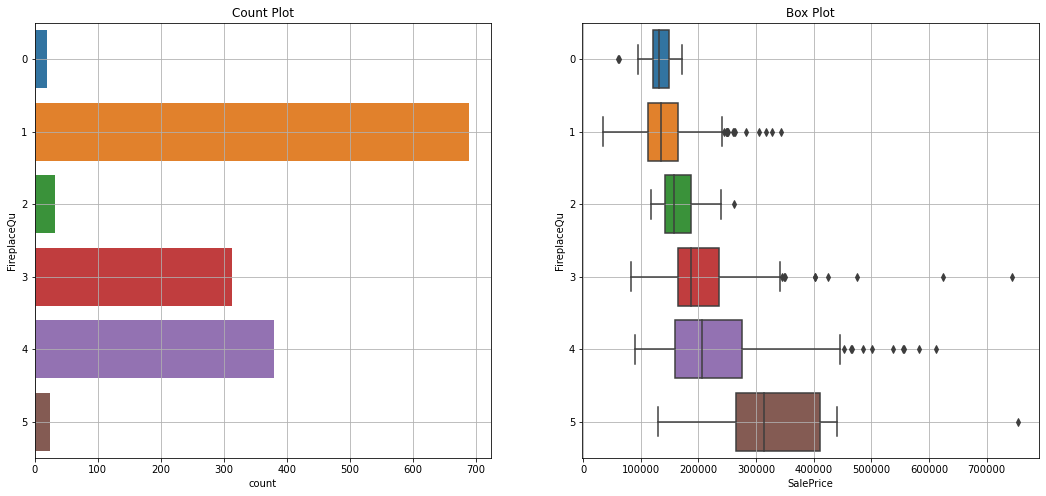

In [258]:
cat_analysis("FireplaceQu")

## GarageType

In [259]:
nan_count("GarageType")

GarageType: Number of NaN values = 81


In [260]:
train.GarageType.fillna("NA", inplace=True)

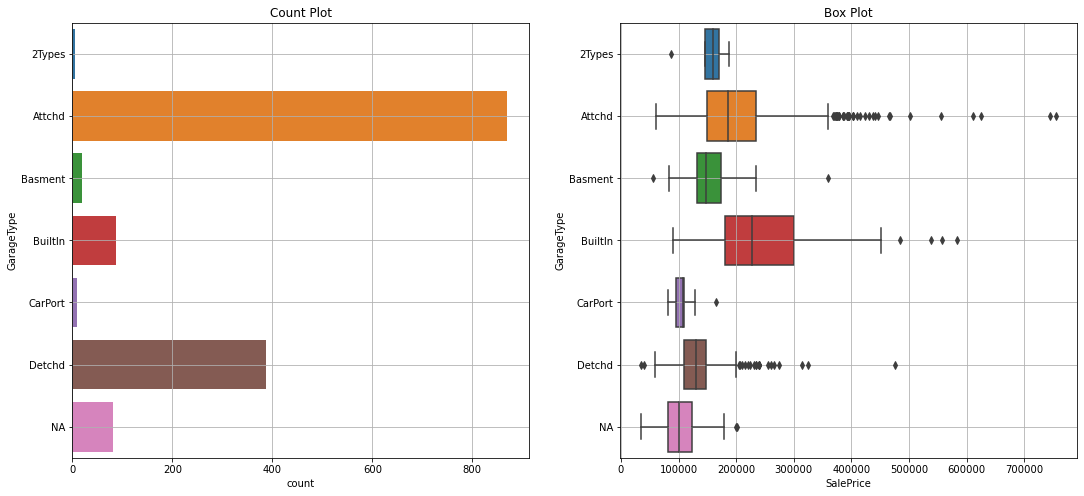

In [261]:
cat_analysis("GarageType")

In [262]:
mean_reduction("GarageType").sort_values("mean")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 159552.7101
Mean Reduction = 11.8109 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 53872.3693
Mean Reduction = 32.1870 %


mean            std      skew   kurtosis
GarageType                                                   
NA          103317.283951   32815.023389  0.482578   0.701521
CarPort     109962.111111   24638.183681  1.232117   0.841136
Detchd      134091.162791   41391.549953  2.400113  13.712168
2Types      151283.333333   34917.068415 -1.076278   0.048402
Basment     160570.684211   63967.283574  1.441136   3.171987
Attchd      202892.656322   77146.621778  2.032313   8.009147
BuiltIn     254751.738636  102230.854394  1.133224   1.163546

In [263]:
GarageType_dict = {}

for obj, key in enumerate(mean_reduction("GarageType").sort_values("mean").index):
    GarageType_dict[key] = obj

print("GarageType_dict = ", GarageType_dict)

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 159552.7101
Mean Reduction = 11.8109 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 53872.3693
Mean Reduction = 32.1870 %
GarageType_dict =  {'NA': 0, 'CarPort': 1, 'Detchd': 2, '2Types': 3, 'Basment': 4, 'Attchd': 5, 'BuiltIn': 6}


In [264]:
train.GarageType = train.GarageType.map(GarageType_dict)

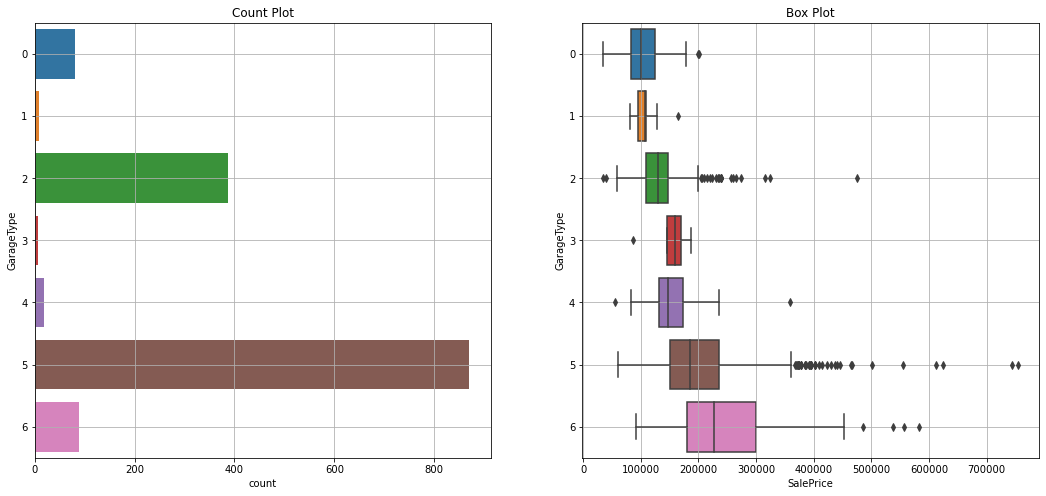

In [265]:
cat_analysis("GarageType")

## GarageYrBlt

In [266]:
nan_count("GarageYrBlt")

GarageYrBlt: Number of NaN values = 81


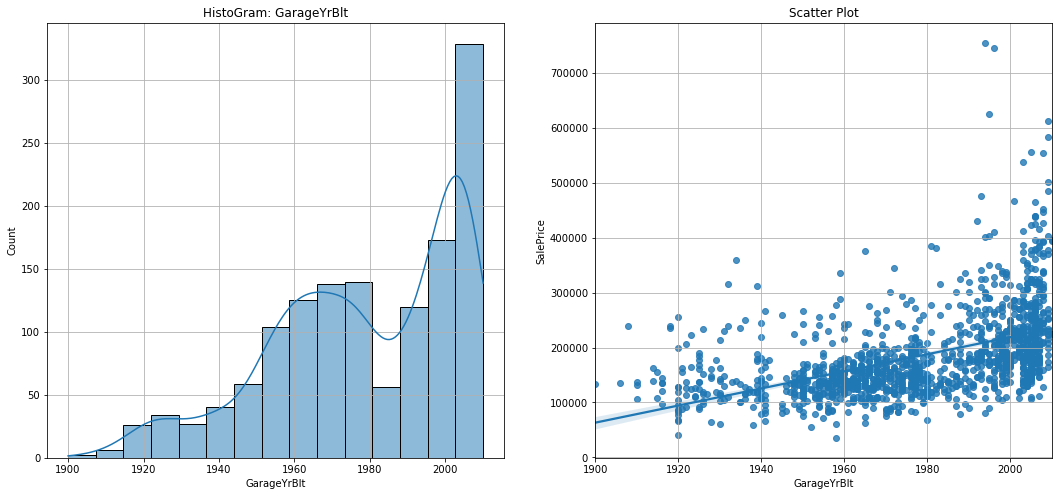

In [267]:
num_analysis("GarageYrBlt", "SalePrice")

In [268]:
train["Age_Garage"] = train.YrSold - train.GarageYrBlt

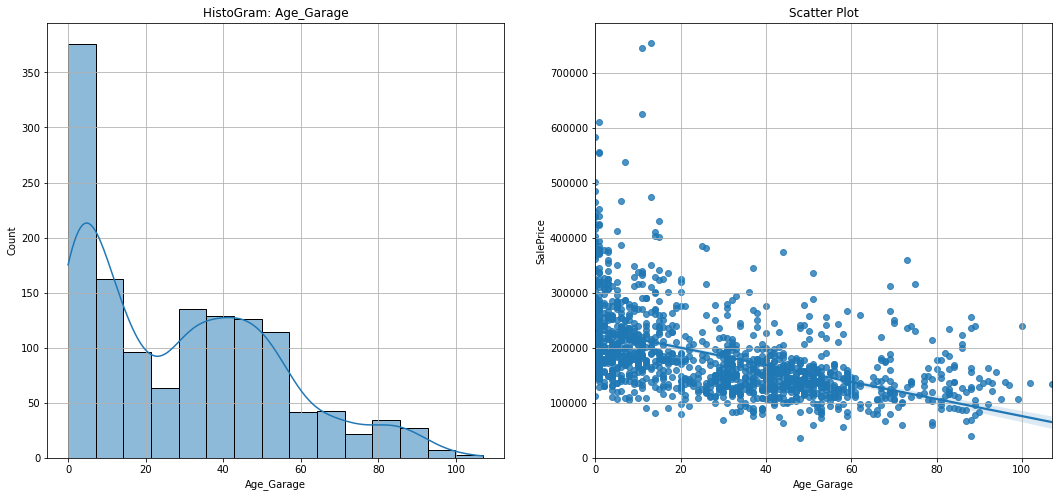

In [269]:
num_analysis("Age_Garage", "SalePrice")

## GarageFinish

In [270]:
nan_count("GarageFinish")

GarageFinish: Number of NaN values = 81


In [271]:
train.GarageFinish.value_counts(dropna=False)

Unf    605
RFn    422
Fin    352
NaN     81
Name: GarageFinish, dtype: int64

In [272]:
train.GarageFinish.fillna("NA", inplace=True)

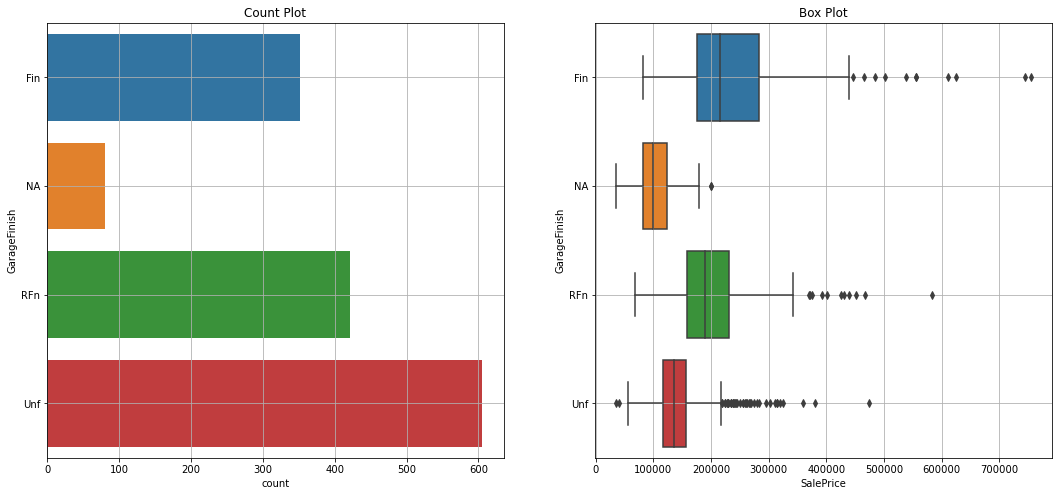

In [273]:
cat_analysis("GarageFinish")

In [274]:
mean_reduction("GarageFinish").sort_values("mean")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 171898.8168
Mean Reduction = 4.9869 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 59952.5918
Mean Reduction = 24.5334 %


mean           std      skew  kurtosis
GarageFinish                                                 
NA            103317.283951  32815.023389  0.482578  0.701521
Unf           142156.423140  46498.528211  1.964609  7.467639
RFn           202068.869668  63536.222518  1.547033  4.583898
Fin           240052.690341  96960.593232  1.762373  4.911414

In [275]:
train.GarageFinish = train.GarageFinish.map(
    {
        "NA" : 0,
        "Unf": 1,
        "RFn": 2,
        "Fin": 3,
    }
)

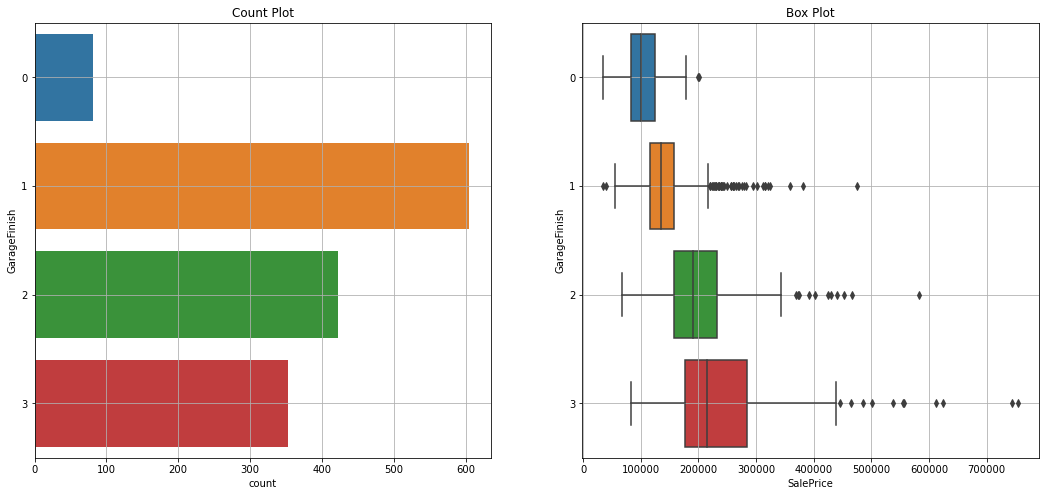

In [276]:
cat_analysis("GarageFinish")

## GarageCars

In [277]:
nan_count("GarageCars")

GarageCars: Number of NaN values = 0


In [278]:
train.GarageCars.value_counts()

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

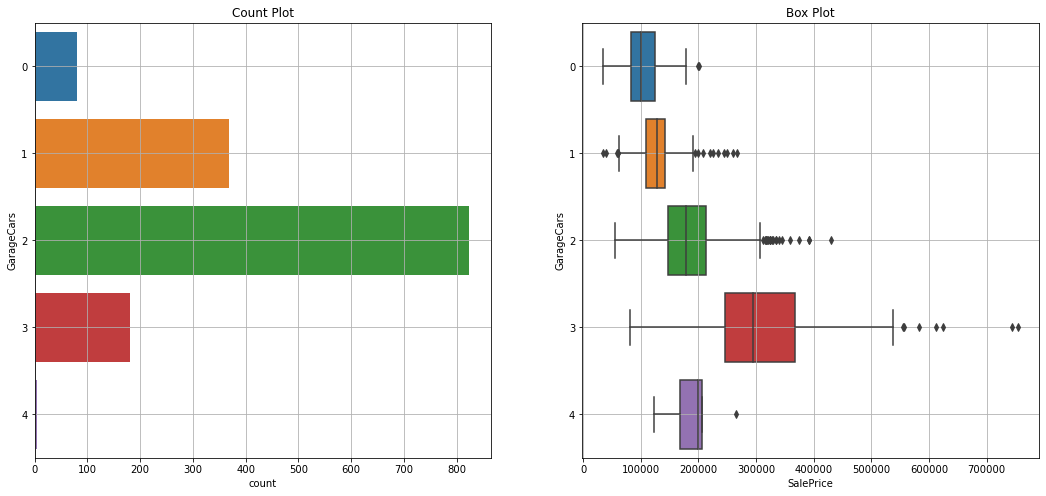

In [279]:
cat_analysis("GarageCars")

In [280]:
train.GarageCars = train.GarageCars.apply(lambda x: 3 if (x >= 3) else x)

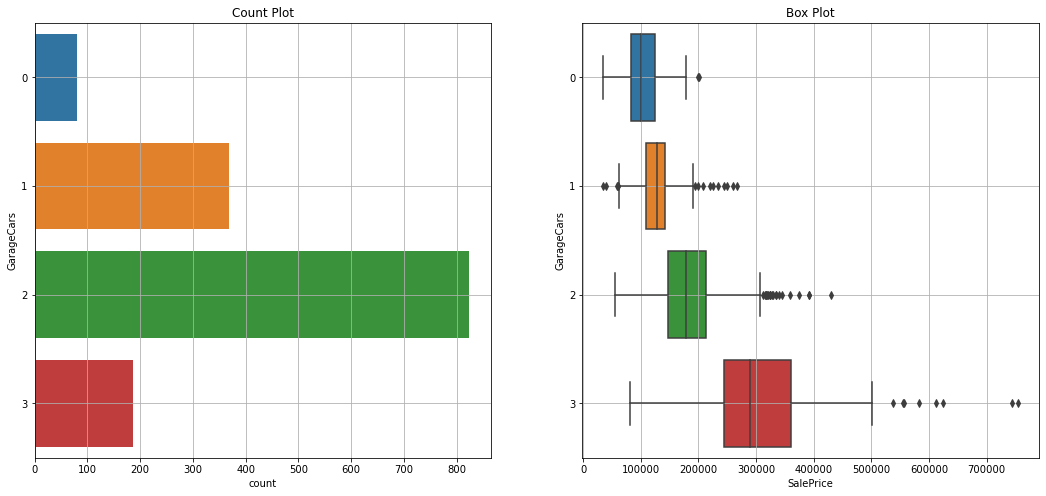

In [281]:
cat_analysis("GarageCars")

In [282]:
mean_reduction("GarageCars")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 180444.2813
Mean Reduction = 0.2636 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 55549.2937
Mean Reduction = 30.0761 %


mean            std      skew  kurtosis
GarageCars                                                  
0           103317.283951   32815.023389  0.482578  0.701521
1           128116.688347   30412.386890  0.801926  3.337260
2           183851.663835   51617.144258  0.863292  1.425320
3           306491.489247  107352.620315  1.067008  2.733433

## GarageArea

In [283]:
nan_count("GarageArea")

GarageArea: Number of NaN values = 0


In [284]:
train.GarageArea.describe()

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

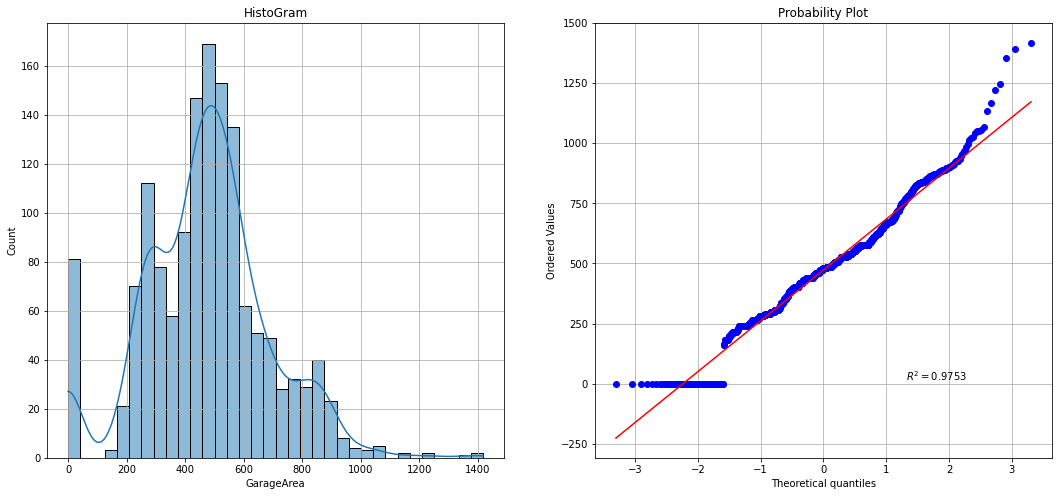

In [285]:
num_analysis("GarageArea")

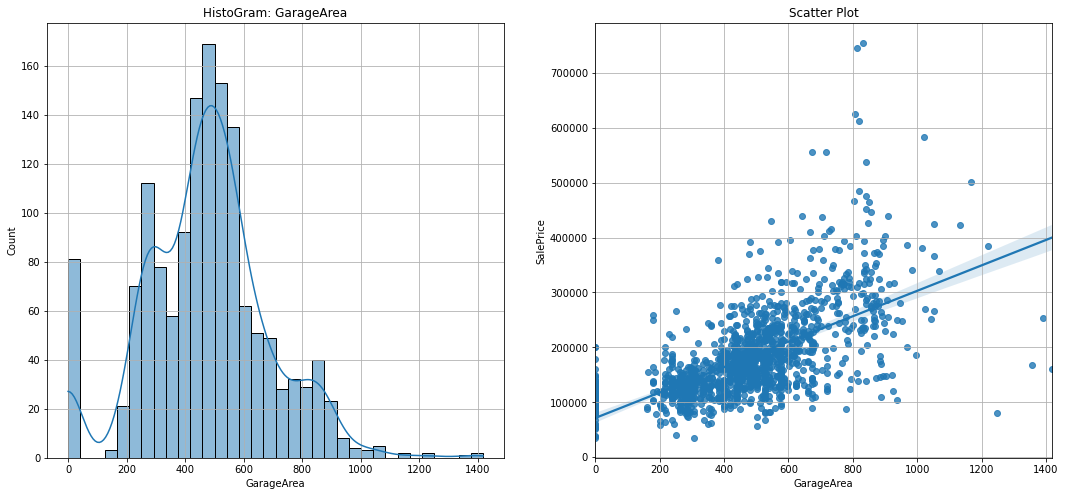

In [286]:
num_analysis("GarageArea", "SalePrice")

## GarageQual

In [287]:
nan_count("GarageQual")

GarageQual: Number of NaN values = 81


In [288]:
train.GarageQual.fillna("NA", inplace=True)

In [289]:
train.GarageQual.value_counts()

TA    1311
NA      81
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

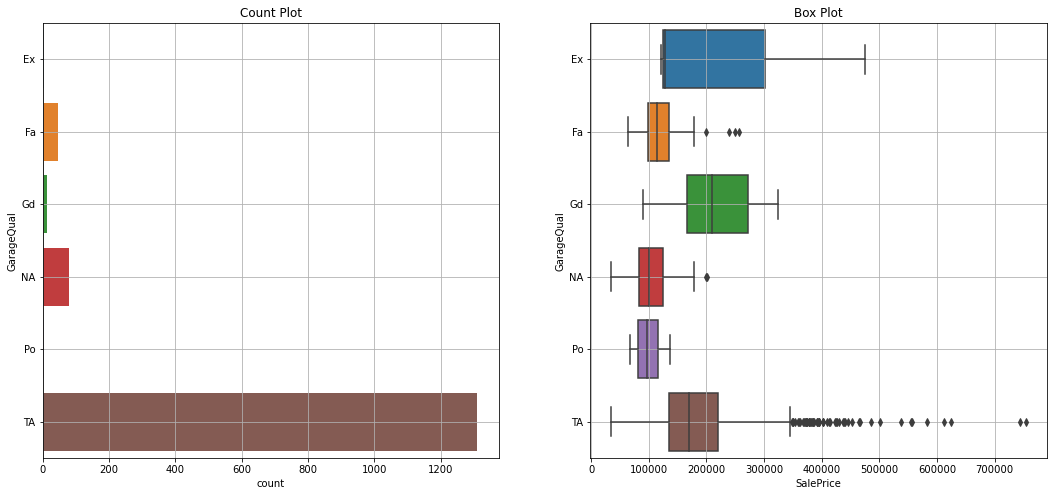

In [290]:
cat_analysis("GarageQual")

In [291]:
train.GarageQual = train.GarageQual.map(
    {
        "Po": 0,
        "NA": 0,
        "Fa": 1,
        "TA": 2,
        "Gd": 3,
        "Ex": 3,
    }
)

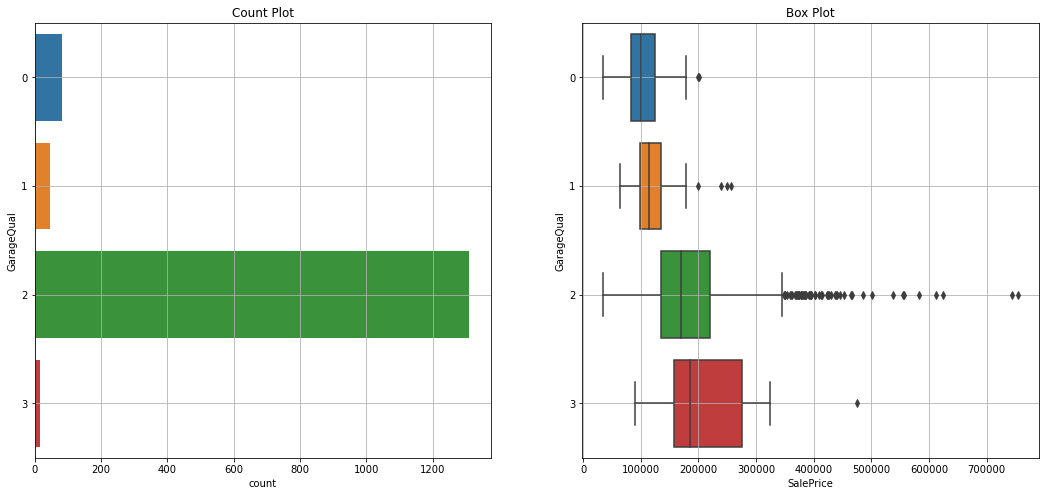

In [292]:
cat_analysis("GarageQual")

In [293]:
mean_reduction("GarageQual")

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 158641.2527
Mean Reduction = 12.3147 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 63225.0390
Mean Reduction = 20.4141 %


mean           std      skew  kurtosis
GarageQual                                                 
0           103204.761905  32680.443121  0.477718  0.664171
1           123573.354167  42971.440985  1.553764  2.396546
2           187489.836003  78774.948567  1.966493  6.927358
3           220297.058824  98473.323213  0.921633  0.583568

## GarageCond

In [294]:
nan_count("GarageCond")

GarageCond: Number of NaN values = 81


In [295]:
train.GarageCond.fillna("NA", inplace=True)

In [296]:
train.GarageCond.value_counts()

TA    1326
NA      81
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

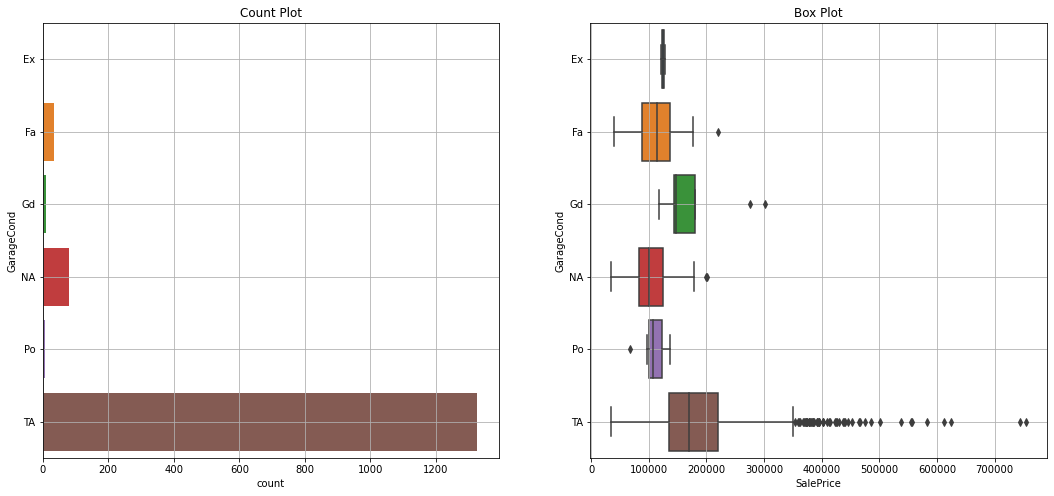

In [297]:
cat_analysis("GarageCond")

In [298]:
train.GarageCond = train.GarageCond.map(
    {
        "Po": 0,
        "NA": 0,
        "Fa": 1,
        "TA": 2,
        "Gd": 3,
        "Ex": 3
    }
)

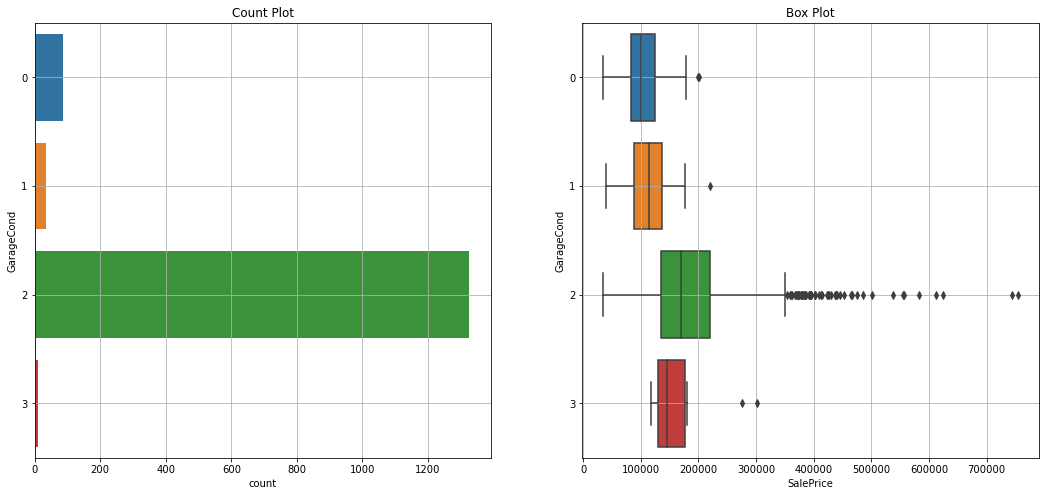

In [299]:
cat_analysis("GarageCond")

In [300]:
train.GarageCond.value_counts()

2    1326
0      88
1      35
3      11
Name: GarageCond, dtype: int64

## PavedDrive

In [301]:
nan_count("PavedDrive")

PavedDrive: Number of NaN values = 0


In [302]:
train.PavedDrive.value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [303]:
train.PavedDrive.value_counts(normalize=True).round(4) * 100

Y    91.78
N     6.16
P     2.05
Name: PavedDrive, dtype: float64

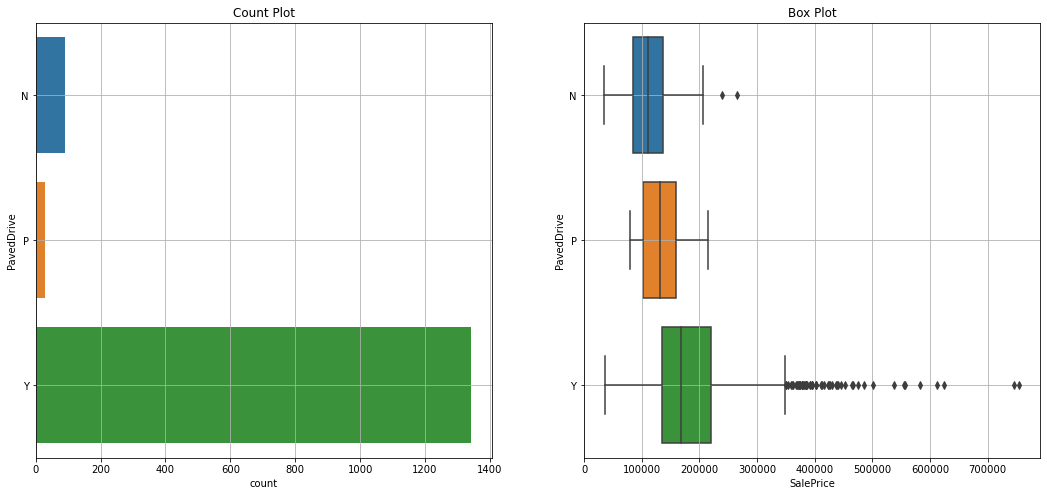

In [304]:
cat_analysis("PavedDrive")

In [305]:
PavedDrive_dict = {}

for obj, key in  enumerate(mean_reduction("PavedDrive").sort_values("mean").index):
    PavedDrive_dict[key] = obj

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 144601.0320
Mean Reduction = 20.0751 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 52507.0189
Mean Reduction = 33.9056 %


In [306]:
train.PavedDrive = train.PavedDrive.map(PavedDrive_dict)

## PoolArea (Drop!)

In [307]:
nan_count("PoolArea")

PoolArea: Number of NaN values = 0


In [308]:
train.PoolArea.describe()

count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

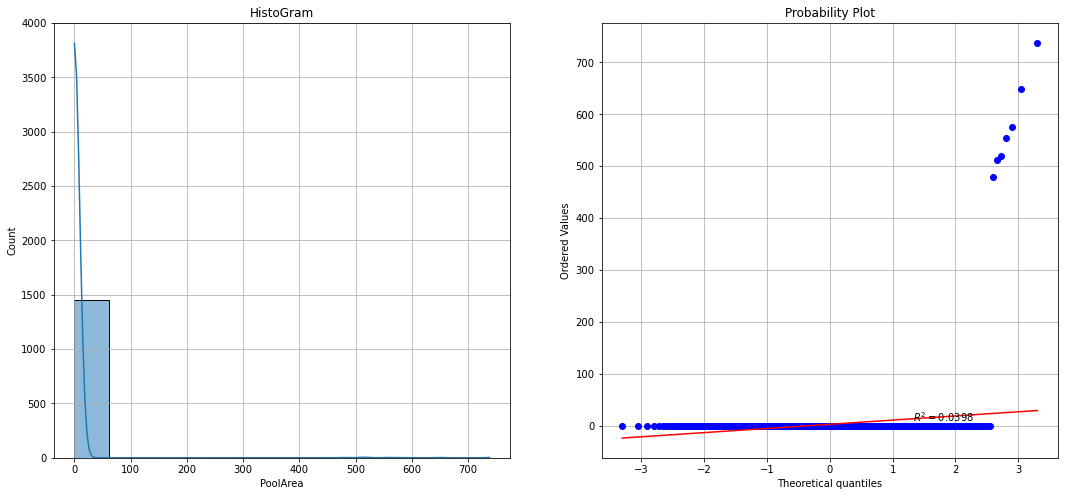

In [309]:
num_analysis("PoolArea")

In [310]:
(train.PoolArea != 0).sum()

7

## PoolQC (Drop!)

In [311]:
train.PoolQC.value_counts(dropna=False)

NaN    1453
Gd        3
Ex        2
Fa        2
Name: PoolQC, dtype: int64

## Fence (Drop)

In [312]:
train.Fence.value_counts(dropna=False)

NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

<AxesSubplot:>

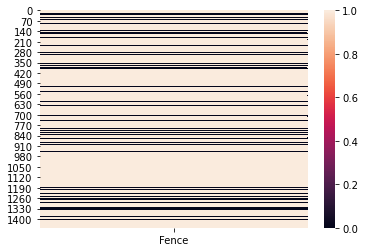

In [313]:
sns.heatmap(train.loc[:,["Fence"]].isna())

In [314]:
train.Fence.fillna("NA", inplace=True)

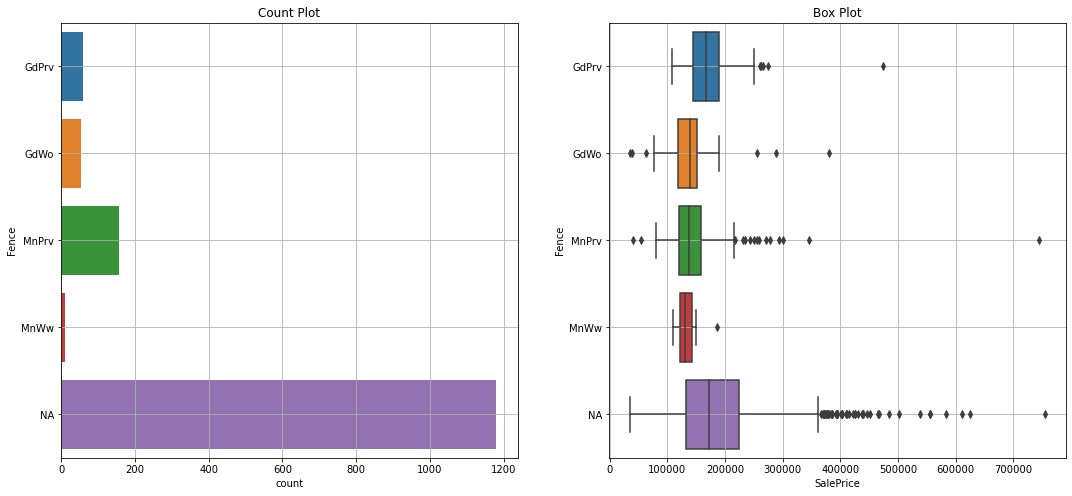

In [315]:
cat_analysis("Fence")

## MiscFeature (Drop!)

In [316]:
train.MiscFeature.value_counts(dropna=False)

NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64

In [317]:
train.MiscFeature.value_counts(dropna=False, normalize=True).round(4) * 100

NaN     96.30
Shed     3.36
Gar2     0.14
Othr     0.14
TenC     0.07
Name: MiscFeature, dtype: float64

## MiscVal

In [318]:
train.MiscVal.value_counts(dropna=False)

0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
480         2
1200        2
2500        1
350         1
560         1
54          1
620         1
8300        1
800         1
1150        1
15500       1
1300        1
1400        1
3500        1
Name: MiscVal, dtype: int64

In [319]:
train.MiscVal.value_counts(dropna=False, normalize=True).round(4) * 100

0        96.44
400       0.75
500       0.55
700       0.34
450       0.27
600       0.27
2000      0.27
480       0.14
1200      0.14
2500      0.07
350       0.07
560       0.07
54        0.07
620       0.07
8300      0.07
800       0.07
1150      0.07
15500     0.07
1300      0.07
1400      0.07
3500      0.07
Name: MiscVal, dtype: float64

## SaleType

In [320]:
train.SaleType.value_counts(dropna=False)

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [321]:
train.SaleType.value_counts(normalize=True, dropna=False).round(4) * 100

WD       86.78
New       8.36
COD       2.95
ConLD     0.62
ConLI     0.34
ConLw     0.34
CWD       0.27
Oth       0.21
Con       0.14
Name: SaleType, dtype: float64

In [322]:
train.SaleType = train.SaleType.apply( lambda x: 0 if (x == "WD") else 1 )

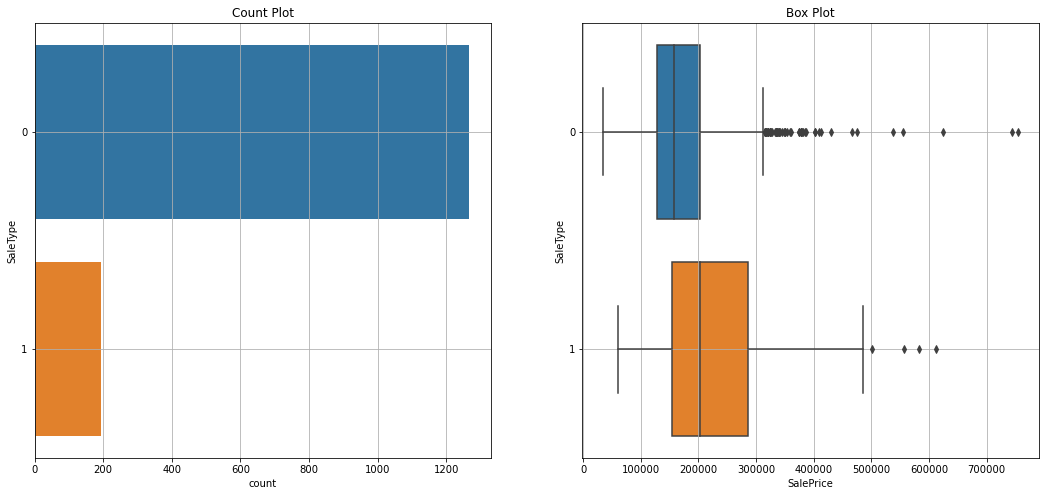

In [323]:
cat_analysis("SaleType")

## SaleCondition

In [324]:
train.SaleCondition.value_counts(dropna=False)

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

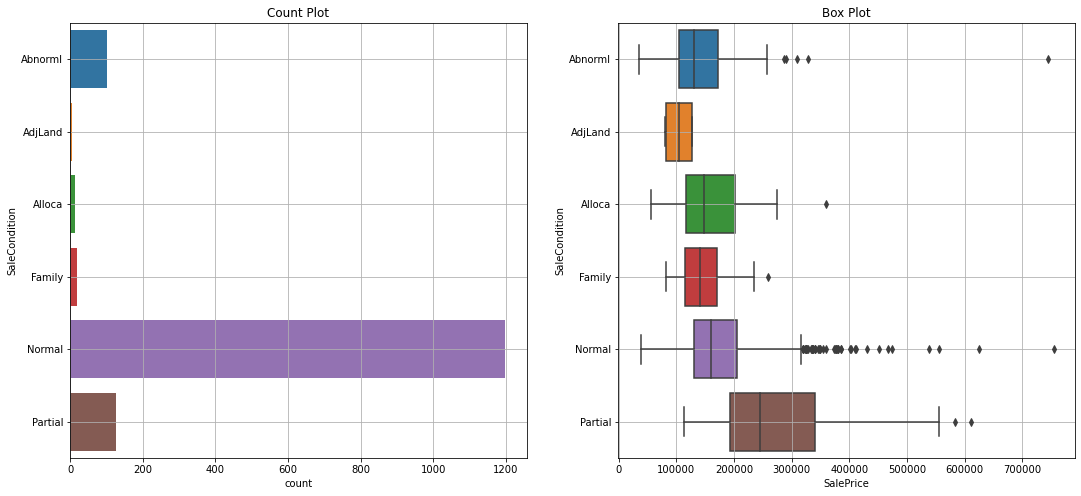

In [325]:
cat_analysis("SaleCondition")

In [326]:
SaleCondition_dict = {}

for obj, key in enumerate(mean_reduction("SaleCondition").sort_values("mean").index):
    SaleCondition_dict[key] = obj

------MEAN-------
Total Mean     = 180921.1959
Categ Mean     = 169187.1687
Mean Reduction = 6.4857 %
------STD--------
Total Mean     = 79442.5029
Categ Mean     = 69103.7080
Mean Reduction = 13.0142 %


In [327]:
train.SaleCondition = train.SaleCondition.map(SaleCondition_dict)

## GrLivArea

In [328]:
nan_count("GrLivArea")

GrLivArea: Number of NaN values = 0


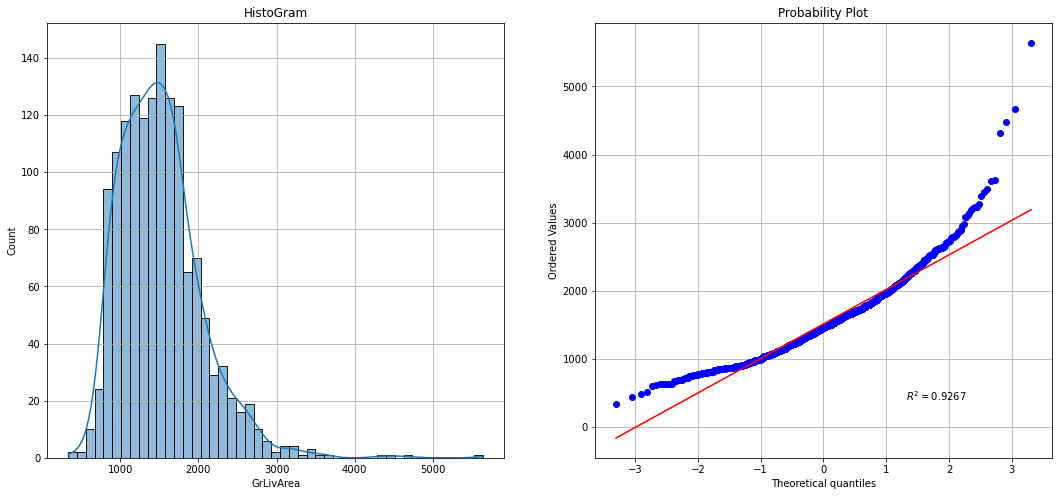

In [329]:
num_analysis("GrLivArea")

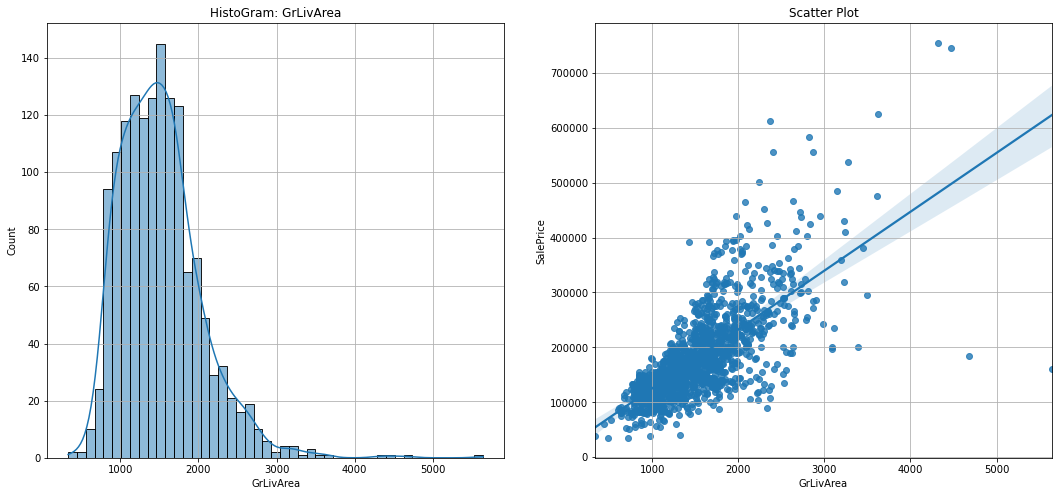

In [330]:
num_analysis("GrLivArea", "SalePrice")

## MoSold

In [331]:
train.MoSold.value_counts(dropna=False).sort_index()

1      58
2      52
3     106
4     141
5     204
6     253
7     234
8     122
9      63
10     89
11     79
12     59
Name: MoSold, dtype: int64

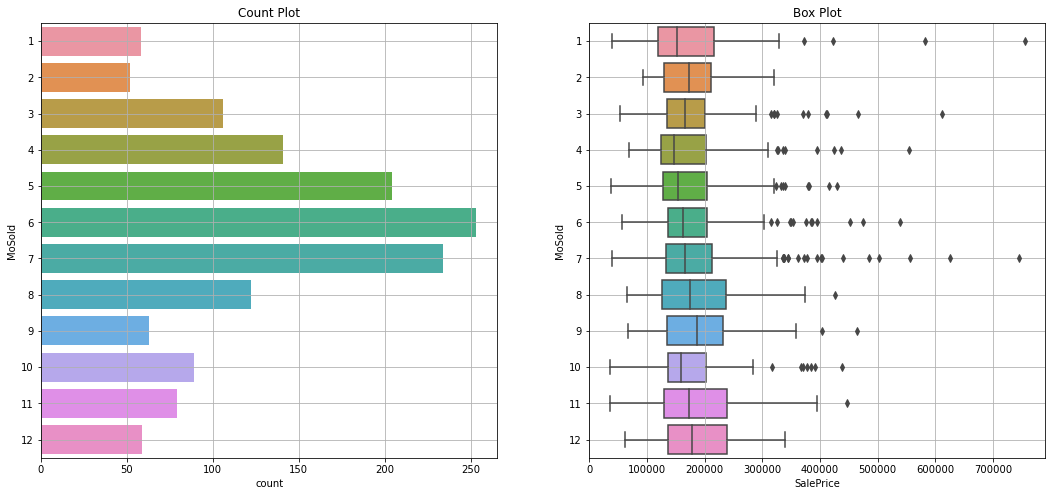

In [332]:
cat_analysis("MoSold")

## Functional

In [333]:
train.Functional.value_counts(dropna=True)

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [334]:
train.Functional = train.Functional.map(
    {
        "Sal" : 0,
        "Sev" : 1,
        "Maj2": 2,
        "Maj1": 3,
        "Mod" : 4,
        "Min2": 5,
        "Min1": 6,
        "Typ" : 7,
    }
)

## Number Of Floors

In [335]:
train["Floors_no"] = (train.loc[:,["1stFlrSF", "2ndFlrSF", "LowQualFinSF"]] != 0).sum(axis=1)

# Drop

In [336]:
[ _ for _ in train.columns if "SF" in _ ]

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'WoodDeckSF',
 'OpenPorchSF',
 'Total_SF']

In [337]:
train.drop(
    labels  =
    [
        "Utilities","Condition2","YearBuilt","RoofMatl","ExterCond","Heating","KitchenAbvGr","PoolArea","Fence",
        "MiscFeature","Street","Alley","PoolQC","LandSlope", "BsmtCond", "Id", "BsmtFinSF2","BsmtUnfSF",'1stFlrSF',
        '2ndFlrSF','WoodDeckSF','OpenPorchSF','EnclosedPorch',"Half_bath","Full_bath",'BsmtFullBath','BsmtHalfBath',
        'FullBath','HalfBath',
    ],
    axis    = 1,
    inplace = True
)

# Filter

In [338]:
train.select_dtypes("object")

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[1460 rows x 0 columns]

# Correlations

## For SalePrice

In [339]:
train.corr().loc[:,"SalePrice"].sort_values(ascending=False) * 100

SalePrice        100.000000
log_SalePrice     94.837373
Total_SF          81.008777
OverallQual       79.098160
GrLivArea         70.862448
Neighborhood      69.688224
ExterQual         68.263924
KitchenQual       65.959972
GarageCars        64.665180
GarageArea        62.343144
BsmtQual          62.292473
TotalBsmtSF       61.358055
All_bath          61.300461
GarageFinish      54.924676
TotRmsAbvGrd      53.513181
FireplaceQu       52.593236
YearRemodAdd      50.710097
Foundation        50.550317
GarageType        48.912999
GarageYrBlt       48.636168
MSSubClass        47.698243
MasVnrArea        47.261450
Fireplaces        46.954320
MasVnrType        42.369742
BsmtFinSF1        38.641981
BsmtExposure      37.469622
Exterior1st       36.022398
LotFrontage       35.179910
MSZoning          32.460953
BsmtFinType1      30.490787
GarageQual        28.084837
HouseStyle        27.307537
GarageCond        27.016925
LotShape          26.569896
LotArea           26.384335
CentralAir        25

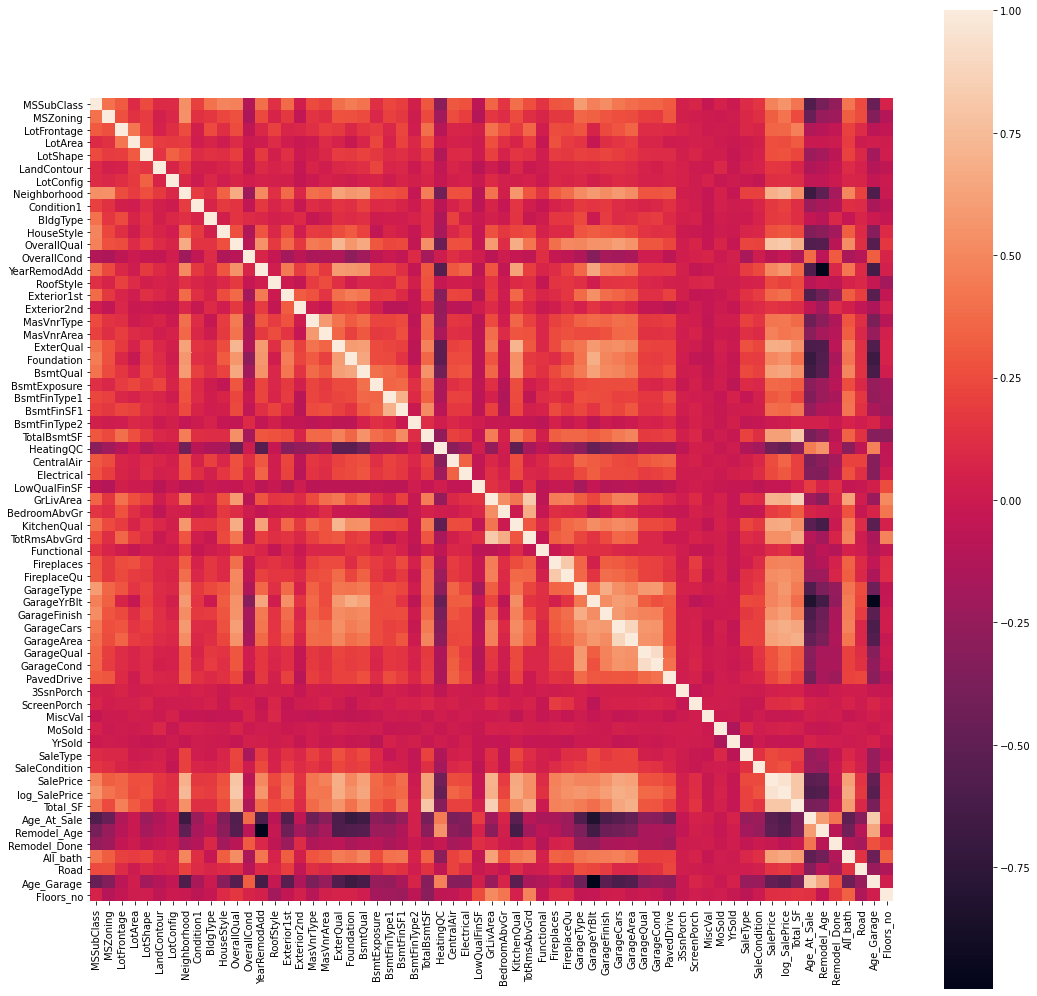

Wall time: 7.54 s


In [340]:
%%time
fig, ax = plt.subplots(1,1, figsize=(18,18))
sns.heatmap(train.corr(), square=True, annot=False)
plt.show()

In [341]:
train.corr().loc[:,"SalePrice"].abs().sort_values(ascending=False).nlargest(11)

SalePrice        1.000000
log_SalePrice    0.948374
Total_SF         0.810088
OverallQual      0.790982
GrLivArea        0.708624
Neighborhood     0.696882
ExterQual        0.682639
KitchenQual      0.659600
GarageCars       0.646652
GarageArea       0.623431
BsmtQual         0.622925
Name: SalePrice, dtype: float64

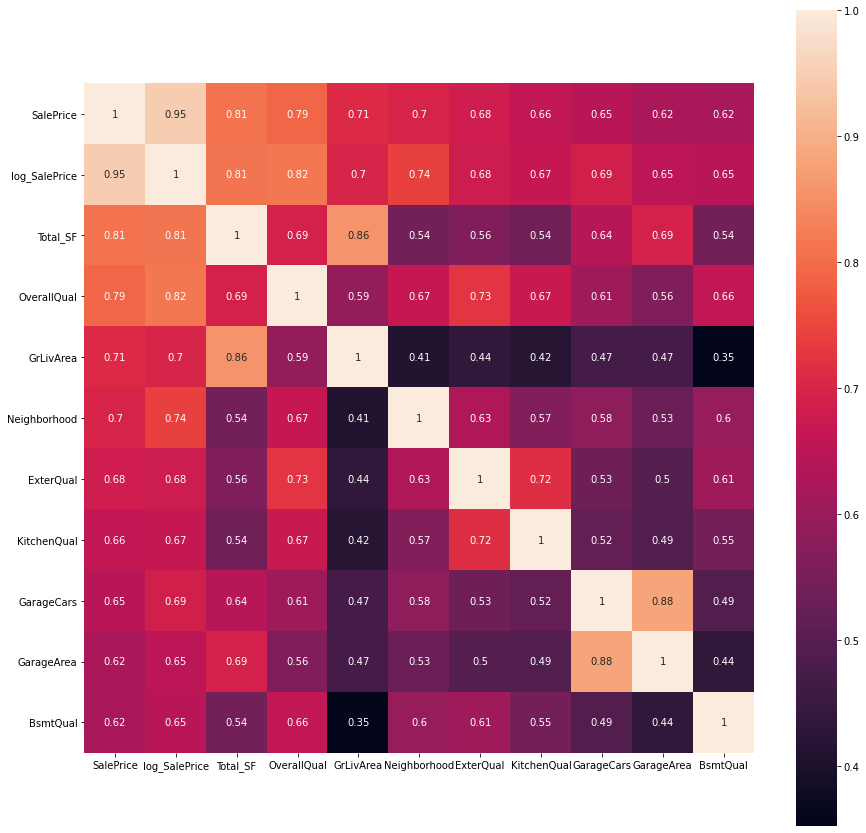

Wall time: 2.54 s


In [342]:
%%time
fig, ax = plt.subplots(1,1, figsize=(15,15))
sns.heatmap(train.loc[:,train.corr().loc[:,"SalePrice"].abs().sort_values(ascending=False).nlargest(11).index].corr(), square=True, annot=True)
plt.show()

In [343]:
train.loc[:,train.corr().loc[:,"SalePrice"].abs().sort_values(ascending=False).nlargest(11).index]

SalePrice  log_SalePrice  Total_SF  OverallQual  GrLivArea  \
0        208500      12.247694      3175            7       1710   
1        181500      12.109011      3282            6       1262   
2        223500      12.317167      3356            7       1786   
3        140000      11.849398      3422            7       1717   
4        250000      12.429216      4455            8       2198   
...         ...            ...       ...          ...        ...   
1455     175000      12.072541      3100            6       1647   
1456     210000      12.254863      4464            6       2073   
1457     266500      12.493130      3804            7       2340   
1458     142125      11.864462      2874            5       1078   
1459     147500      11.901583      3592            5       1256   

      Neighborhood  ExterQual  KitchenQual  GarageCars  GarageArea  BsmtQual  
0               16          2            2           2         548       2.0  
1               20          1            1           2         460       2.0  
2               16          2            2           2         608       2.0  
3               17          1            2           3         642       1.0  
4               24          2            2           3         836       2.0  
...            ...        ...          ...         ...         ...       ...  
1455            14          1            1           2         460       2.0  
1456            13          1            1           2         500       2.0  
1457            17          3            2           1         252       1.0  
1458            10          1            2           1         240       1.0  
1459             4          2            1           1         276       1.0  

[1460 rows x 11 columns]

In [344]:
high_corr_field = list(train.corr().loc[:,"SalePrice"].abs().sort_values(ascending=False).nlargest(12).index)[2:]; high_corr_field

['Total_SF',
 'OverallQual',
 'GrLivArea',
 'Neighborhood',
 'ExterQual',
 'KitchenQual',
 'GarageCars',
 'GarageArea',
 'BsmtQual',
 'TotalBsmtSF']

# Model

In [345]:
train.isna().sum()[ train.isna().sum() > 0 ]

LotFrontage    259
GarageYrBlt     81
Age_Garage      81
dtype: int64

In [346]:
%%time

from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline

QT = QuantileTransformer(output_distribution='normal')
KI = KNNImputer()

y_train = train.SalePrice
x_train = train.drop(labels=["SalePrice", "log_SalePrice"], axis=1)
train_QT = pd.DataFrame(QT.fit_transform(x_train), columns=x_train.columns, index=x_train.index)

x_train_impute = KI.fit_transform(train_QT)

x_train_filled = pd.DataFrame(QT.inverse_transform(x_train_impute), columns=x_train.columns, index=x_train.index)

Wall time: 473 ms


In [347]:
x_train_filled

MSSubClass  MSZoning  LotFrontage  LotArea  LotShape  LandContour  \
0           14.0       3.0         65.0   8450.0       0.0          1.0   
1           11.0       3.0         80.0   9600.0       0.0          1.0   
2           14.0       3.0         68.0  11250.0       1.0          1.0   
3            9.0       3.0         60.0   9550.0       1.0          1.0   
4           14.0       3.0         84.0  14260.0       1.0          1.0   
...          ...       ...          ...      ...       ...          ...   
1455        14.0       3.0         62.0   7917.0       0.0          1.0   
1456        11.0       3.0         85.0  13175.0       0.0          1.0   
1457         9.0       3.0         66.0   9042.0       0.0          1.0   
1458        11.0       3.0         68.0   9717.0       0.0          1.0   
1459        11.0       3.0         75.0   9937.0       0.0          1.0   

      LotConfig  Neighborhood  Condition1  BldgType  HouseStyle  OverallQual  \
0           0.0          16.0         4.0       4.0         6.0          7.0   
1           1.0          20.0         2.0       4.0         5.0          6.0   
2           0.0          16.0         4.0       4.0         6.0          7.0   
3           2.0          17.0         4.0       4.0         6.0          7.0   
4           1.0          24.0         4.0       4.0         6.0          8.0   
...         ...           ...         ...       ...         ...          ...   
1455        0.0          14.0         4.0       4.0         6.0          6.0   
1456        0.0          13.0         4.0       4.0         5.0          6.0   
1457        0.0          17.0         4.0       4.0         6.0          7.0   
1458        0.0          10.0         4.0       4.0         5.0          5.0   
1459        0.0           4.0         4.0       4.0         5.0          5.0   

      OverallCond  YearRemodAdd  RoofStyle  Exterior1st  Exterior2nd  \
0             5.0        2003.0        1.0         11.0          4.0   
1             8.0        1976.0        1.0          4.0          1.0   
2             5.0        2002.0        1.0         11.0          4.0   
3             5.0        1970.0        1.0          5.0          3.0   
4             5.0        2000.0        1.0         11.0          4.0   
...           ...           ...        ...          ...          ...   
1455          5.0        2000.0        1.0         11.0          4.0   
1456          6.0        1988.0        1.0          9.0          2.0   
1457          9.0        2006.0        1.0         12.0          3.0   
1458          6.0        1996.0        4.0          4.0          1.0   
1459          6.0        1965.0        1.0          8.0          0.0   

      MasVnrType  MasVnrArea  ExterQual  Foundation  BsmtQual  BsmtExposure  \
0            2.0       196.0        2.0         5.0       2.0           0.0   
1            1.0         0.0        1.0         2.0       2.0           3.0   
2            2.0       162.0        2.0         5.0       2.0           1.0   
3            1.0         0.0        1.0         1.0       1.0           0.0   
4            2.0       350.0        2.0         5.0       2.0           2.0   
...          ...         ...        ...         ...       ...           ...   
1455         1.0         0.0        1.0         5.0       2.0           0.0   
1456         3.0       119.0        1.0         2.0       2.0           0.0   
1457         1.0         0.0        3.0         3.0       1.0           0.0   
1458         1.0         0.0        1.0         2.0       1.0           1.0   
1459         1.0         0.0        2.0         2.0       1.0           0.0   

      BsmtFinType1  BsmtFinSF1  BsmtFinType2  TotalBsmtSF  HeatingQC  \
0              5.0       706.0           0.0        856.0        0.0   
1              4.0       978.0           0.0       1262.0        0.0   
2              5.0       486.0           0.0        920.0        0.0   
3              4.0       216.0           0

In [348]:
from sklearn.model_selection import RepeatedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree

cv = RepeatedKFold(random_state=1991)
dt = DecisionTreeRegressor()

In [349]:
%%time
dt.fit(x_train_filled, y_train)

Wall time: 44 ms


DecisionTreeRegressor()

In [350]:
dt.get_depth()

23

In [351]:
dt.get_n_leaves()

1404

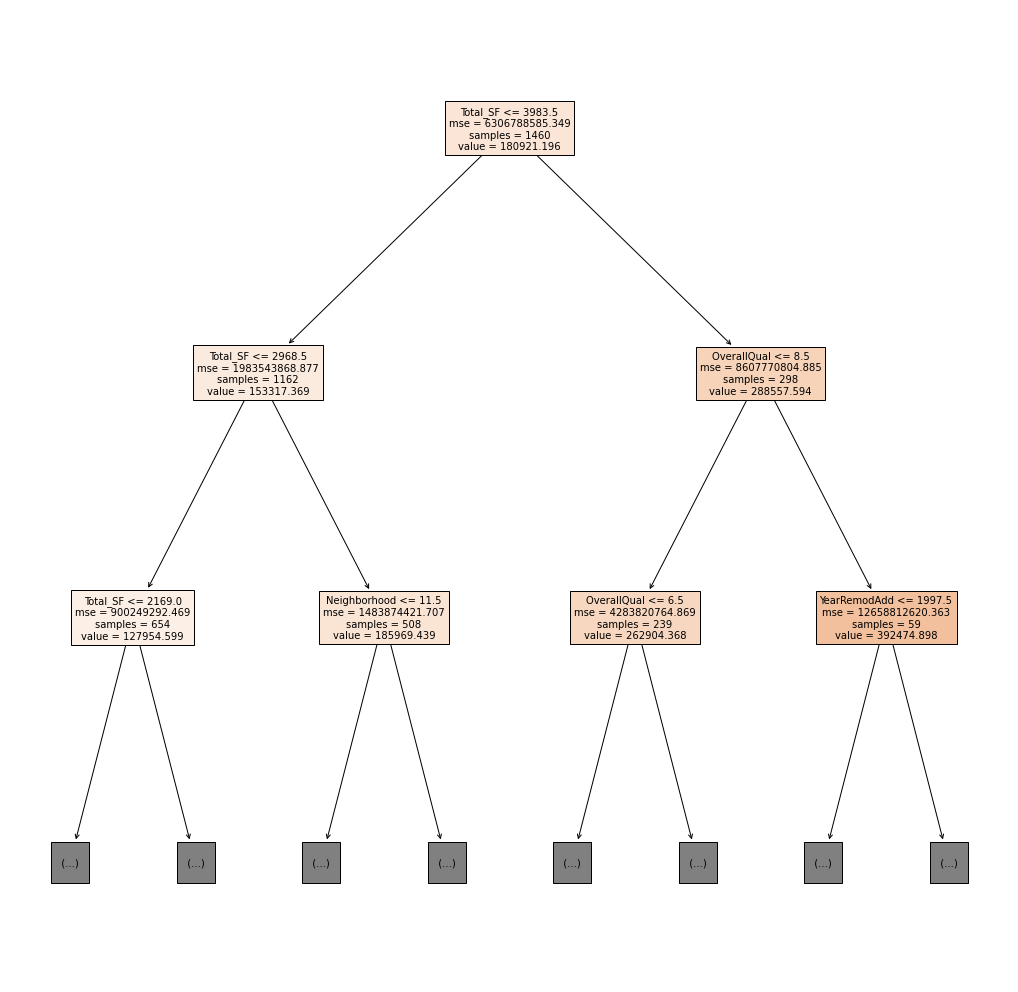

Wall time: 1.11 s


In [352]:
%%time
fig, ax = plt.subplots(1,1, figsize=(18,18))
plot_tree(dt, ax=ax, filled=True, feature_names=list(x_train_filled.columns), max_depth=2, fontsize=10)
plt.show()

In [353]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

param_dict = {
    "criterion": ["mse", "friedman_mse", "poisson"],
    "splitter" : ["best", "random"]
}

dt_gscv = GridSearchCV(
    DecisionTreeRegressor(),
    param_dict,
    scoring = "neg_mean_absolute_error",
    n_jobs  = -2,
    cv      = cv,
    verbose = 1,
)

dt_gscv.fit(x_train_filled, y_train)

Fitting 50 folds for each of 6 candidates, totalling 300 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=1991),
             estimator=DecisionTreeRegressor(), n_jobs=-2,
             param_grid={'criterion': ['mse', 'friedman_mse', 'poisson'],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error', verbose=1)

In [354]:
pd.DataFrame(dt_gscv.cv_results_).sort_values("rank_test_score").head(7)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2       0.081292      0.013399         0.008676        0.005428   
0       0.070118      0.011782         0.006198        0.001183   
1       0.048391      0.010072         0.008317        0.006001   
3       0.038317      0.006224         0.005977        0.001122   
4       0.520461      0.055808         0.010374        0.007151   
5       0.135421      0.034292         0.011115        0.009981   

  param_criterion param_splitter  \
2    friedman_mse           best   
0             mse           best   
1             mse         random   
3    friedman_mse         random   
4         poisson           best   
5         poisson         random   

                                              params  split0_test_score  \
2  {'criterion': 'friedman_mse', 'splitter': 'best'}      -25596.496575   
0           {'criterion': 'mse', 'splitter': 'best'}      -25798.558219   
1         {'criterion': 'mse', 'splitter': 'random'}      -23991.068493   
3  {'criterion': 'friedman_mse', 'splitter': 'ran...      -28363.339041   
4       {'criterion': 'poisson', 'splitter': 'best'}      -31813.089041   
5     {'criterion': 'poisson', 'splitter': 'random'}      -29997.017123   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
2      -26228.191781      -24750.578767      -21386.801370      -23029.616438   
0      -26966.664384      -23342.856164      -22138.119863      -23010.565068   
1      -24867.958904      -28433.236301      -23161.239726      -26519.969178   
3      -28577.092466      -25013.770548      -25747.188356      -23531.541096   
4      -33973.811644      -32470.582192      -28726.047945      -29997.284247   
5      -36757.352740      -33702.369863      -31894.684932      -29612.068493   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
2      -24946.465753      -21219.547945      -27084.671233      -26131.099315   
0      -26742.705479      -21692.753425      -26411.434932      -26124.071918   
1      -26594.239726      -26938.462329      -27090.681507      -30462.061644   
3      -27831.845890      -26818.585616      -25635.585616      -26066.767123   
4      -32807.106164      -27213.232877      -33049.027397      -31597.482877   
5      -29854.845890      -29342.434932      -32541.243151      -32300.010274   

   split9_test_score  split10_test_score  split11_test_score  \
2      -25369.917808       -24040.958904       -25480.633562   
0      -25209.113014       -25233.883562       -24578.373288   
1      -23729.821918       -21862.308219       -25963.243151   
3      -24987.191781       -24497.092466       -24738.904110   
4      -28405.458904       -30495.157534       -30128.065068   
5      -29458.804795       -27668.726027       -28973.465753   

   split12_test_score  split13_test_score  split14_test_score  \
2       -27050.989726       -26152.448630       -29563.910959   
0       -25393.020548       -26432.715753       -28980.486301   
1       -25860.335616       -25523.332192       -28919.359589   
3       -28022.934932       -28659.589041       -28590.386986   
4       -32676.184932       -29774.363014       -29797.448630   
5       -38672.708904       -31265.102740       -30126.301370   

   split15_test_score  split16_test_score  split17_test_score  \
2       -21941.773973       -23979.818493       -27542.325342   
0       -20985.537671       -23978.743151       -25769.260274   
1       -23077.136986       -25613.722603       -28600.205479   
3       -26528.760274       -28706.739726       -26407.260274   
4       -26960.842466       -29626.318493       -35234.934932   
5       -30746.407534       -28400.551370       -31619.462329   

   split18_test_score  split19_test_score  split20_test_score  \
2       -21926.171233       -29399.287671       -25601.270548   
0       -21595.674658       -27069.294521       -24723.705479   
1       -24291.544521       -29937.739726       -29452.455479 

In [355]:
%%time
from sklearn.ensemble import RandomForestRegressor

param_dict = {
    "n_estimators": [100],
    "n_jobs"      : [-2],
    "verbose"     : [1],
    "random_state": [2451],
    "warm_start"  : [1],
    "max_depth"   : [28, 30, 32, None]
}

rf_gscv = GridSearchCV(
    RandomForestRegressor(),
    param_dict,
    scoring = "neg_mean_absolute_error",
    n_jobs  = -2,
    cv      = cv,
    verbose = 1,
)

rf_gscv.fit(x_train_filled, y_train)

Fitting 50 folds for each of 4 candidates, totalling 200 fits


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.7s


Wall time: 3min 41s


[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    1.7s finished


GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=1991),
             estimator=RandomForestRegressor(), n_jobs=-2,
             param_grid={'max_depth': [28, 30, 32, None], 'n_estimators': [100],
                         'n_jobs': [-2], 'random_state': [2451], 'verbose': [1],
                         'warm_start': [1]},
             scoring='neg_mean_absolute_error', verbose=1)

In [356]:
pd.DataFrame(rf_gscv.cv_results_).sort_values("rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1       2.974518      0.555691         0.686110        0.354883   
3       2.692679      0.344106         0.345503        0.289754   
2       2.763852      0.437150         0.503961        0.293557   
0       2.743051      0.378772         0.384700        0.318033   

  param_max_depth param_n_estimators param_n_jobs param_random_state  \
1              30                100           -2               2451   
3            None                100           -2               2451   
2              32                100           -2               2451   
0              28                100           -2               2451   

  param_verbose param_warm_start  \
1             1                1   
3             1                1   
2             1                1   
0             1                1   

                                              params  split0_test_score  \
1  {'max_depth': 30, 'n_estimators': 100, 'n_jobs...      -17118.919555   
3  {'max_depth': None, 'n_estimators': 100, 'n_jo...      -17118.919555   
2  {'max_depth': 32, 'n_estimators': 100, 'n_jobs...      -17118.919555   
0  {'max_depth': 28, 'n_estimators': 100, 'n_jobs...      -17118.919555   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
1      -18301.884795      -16229.615719      -13816.366575      -16305.166336   
3      -18301.884795      -16229.615719      -13816.366575      -16305.166336   
2      -18301.884795      -16229.615719      -13816.366575      -16305.166336   
0      -18301.884795      -16229.615719      -13816.366575      -16305.166336   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
1      -16194.932226      -15034.980719      -17437.878425      -17225.881473   
3      -16194.932226      -15034.980719      -17437.878425      -17225.881473   
2      -16194.932226      -15034.980719      -17437.878425      -17225.881473   
0      -16194.932226      -15034.980719      -17437.878425      -17225.881473   

   split9_test_score  split10_test_score  split11_test_score  \
1      -16777.914521       -15405.935308       -14813.179932   
3      -16777.914521       -15405.935308       -14813.179932   
2      -16777.914521       -15405.935308       -14813.179932   
0      -16777.914521       -15405.935308       -14813.179932   

   split12_test_score  split13_test_score  split14_test_score  \
1       -16942.395479       -17165.310479       -18015.859829   
3       -16942.395479       -17165.310479       -18015.859829   
2       -16942.395479       -17165.310479       -18015.859829   
0       -16942.395479       -17165.310479       -18015.859829   

   split15_test_score  split16_test_score  split17_test_score  \
1       -15634.316644       -14466.744829       -17510.523562   
3       -15634.316644       -14466.744829       -17510.523562   
2       -15634.316644       -14466.744829       -17510.523562   
0       -15634.316644       -14466.744829       -17510.523562   

   split18_test_score  split19_test_score  split20_test_score  \
1       -15805.898082       -19062.055137       -17529.008116   
3       -15805.898082       -19062.055137       -17529.008116   
2       -15805.898082       -19062.055137       -17529.008116   
0       -15795.806975       -19062.055137       -17529.008116   

   split21_test_score  split22_test_score  split23_test_score  \
1       -16989.013253       -16126.862432       -16070.603733   
3       -16989.013253       -16126.862432       -16070.603733   
2       -16989.013253       -16126.862432       -16070.603733   
0       -16989.013253       -16126.862432       -16070.603733   

   split24_test_score  split25_test_score  split26_test_score  \
1       -16418.366507       -14035.150308       -15717.828493   
3       -16418.366507       -14035.150308       -15717.828493   
2       -16418.366507       -14035.150308       -15717.828493   
0       -16418.366507       -14061.151826       -157

In [357]:
pd.Series(rf_gscv.best_estimator_.feature_importances_, index=x_train_filled.columns).sort_values(ascending=False).round(4) * 100

Total_SF         62.69
OverallQual      12.68
Neighborhood      7.76
GrLivArea         1.82
BsmtFinSF1        1.15
BsmtQual          0.83
KitchenQual       0.82
LotArea           0.79
MasVnrArea        0.74
Age_At_Sale       0.68
TotalBsmtSF       0.65
YearRemodAdd      0.56
OverallCond       0.55
GarageArea        0.55
LotFrontage       0.54
Remodel_Age       0.54
ExterQual         0.48
GarageYrBlt       0.42
All_bath          0.40
Age_Garage        0.37
TotRmsAbvGrd      0.35
MoSold            0.32
FireplaceQu       0.30
GarageCars        0.27
BsmtExposure      0.26
MSSubClass        0.26
LandContour       0.25
Exterior2nd       0.21
SaleCondition     0.21
GarageType        0.21
BsmtFinType1      0.20
Exterior1st       0.19
Fireplaces        0.18
CentralAir        0.17
YrSold            0.15
MasVnrType        0.13
GarageFinish      0.13
BedroomAbvGr      0.11
ScreenPorch       0.10
LotShape          0.10
MSZoning          0.09
LotConfig         0.08
HouseStyle        0.08
SaleType   

In [358]:
%%time
rf_ml = RandomForestRegressor(**rf_gscv.best_params_)

rf_ml.fit(x_train_filled, y_train)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.7s


Wall time: 2.01 s


[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    1.8s finished


RandomForestRegressor(max_depth=30, n_jobs=-2, random_state=2451, verbose=1,
                      warm_start=1)

In [359]:
for _ in range(4):
    rf_ml.n_estimators += 100
    rf_ml.random_state += 101
    rf_ml.fit(x_train_filled, y_train)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    2.0s finished
